In [1]:
import os
# limit GPU allocation
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" #issue #152
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
from numpy.random import seed
seed(42)
from tensorflow import random
random.set_seed(42)
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, jaccard_score, roc_auc_score, accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.metrics import classification_report_imbalanced
from skimage.io import imsave
import tensorflow as tf
%matplotlib inline

# processed_dir = os.path.join(data_dir,'processed')
processed_dir = '/home/gabriel/research/jupyter_workspace/kbs_data' # for work on hal
model_dir = os.path.join(processed_dir,'models')
df_anomaly = pd.read_csv(os.path.join(processed_dir,"df_anomaly.csv"))
df_anomaly.set_index('time', inplace=True)
df_audsome = pd.read_csv(os.path.join(processed_dir,"df_audsome.csv"))
df_audsome.set_index('time', inplace=True)

2023-02-02 09:51:36.136683: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-02 09:51:36.221945: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-02 09:51:36.583843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-02 09:51:36.583887: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [2]:
def custom_scoring_reporting(y_pred,
                             y,
                             definitions,
                             prefix):
    """
    Custom function for handling scoring and reporting
    :param y_pred: model predictions
    :param y: ground truth
    :param definitions: variable class definitions (factorize)
    :param prefix: prefix to saved files and images
    :return: 0
    """
    print("Accuracy score is: {}".format(accuracy_score(y, y_pred)))
    print("Ballanced accuracy score is: {}".format(balanced_accuracy_score(y, y_pred)))
    print("Jaccard score (micro): {}".format(jaccard_score(y, y_pred, average='micro')))
    print("Jaccard score (macro): {}".format(jaccard_score(y, y_pred, average='macro')))
    print("Jaccard score (weighted): {}".format(jaccard_score(y, y_pred, average='weighted')))

    print("Full classification report")
    print(classification_report(y, y_pred, digits=4, target_names=definitions))
    report = classification_report(y, y_pred, digits=4, output_dict=True)
    df_classification_report = pd.DataFrame(report).transpose()
    classification_rep_name = "{}_classification_rep_best.csv".format(prefix)
    df_classification_report.to_csv(os.path.join(model_dir,classification_rep_name), index=False)

    print("Imbalanced Classification report")
    print(classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions))
    imb_report = classification_report_imbalanced(y, y_pred, digits=4, target_names=definitions, output_dict=True)
    df_imb_classification_report = pd.DataFrame(imb_report).transpose()
    classification_imb_rep_name = "{}_imb_classification_rep_best.csv".format(prefix)
    df_imb_classification_report.to_csv(os.path.join(model_dir,classification_imb_rep_name), index=False)


def generate_images(images,
                    train_data_index,
                    test_data_index,
                    labels):
    input_dir = os.path.join(processed_dir, 'input')
    if os.path.exists(input_dir):
        import shutil
        shutil.rmtree(input_dir)
        print("Removed existing training dir")
        os.mkdir(input_dir)
    else:
        os.mkdir(input_dir)

    for ind, label in enumerate(labels):
        if ind in train_data_index:
            train_dir = os.path.join(input_dir, 'training')
            label_dir = os.path.join(train_dir, str(label))
            if os.path.exists(label_dir):
                pass
            else:
                os.makedirs(label_dir)
        elif ind in test_data_index:
            val_dir = os.path.join(input_dir, 'validation')
            label_dir = os.path.join(val_dir, str(label))
            if os.path.exists(label_dir):
                pass
            else:
                os.makedirs(label_dir)
        else:
            print(ind)
            import sys
            sys.exit()
        im_name = f'data_{ind}.png'
        im_path = os.path.join(label_dir, im_name)
        imsave(im_path,images[ind].astype(np.uint8)) # fixed warnings
    return train_dir, val_dir

In [3]:
print("Dataset chosen ...")
data = df_anomaly
# drop_col = ['t1','t2','t3','t4']
# print("Remove unwanted columns ...")
print("Shape before drop: {}".format(data.shape))
# data.drop(drop_col, axis=1, inplace=True)
# print("Shape after drop: {}".format(data.shape))

Dataset chosen ...
Shape before drop: (5400, 90)


In [4]:
# Nice print
nice_y = data['target']

# Uncomment for removing dummy
print("Removed Dummy class")
data.loc[data.target == "dummy", 'target'] = "0"

#Creating the dependent variable class
factor = pd.factorize(data['target'])
data['target'] = factor[0]
definitions = factor[1]
# print(data.target.head())
# print(definitions)

Removed Dummy class


Ploting class distribution ..


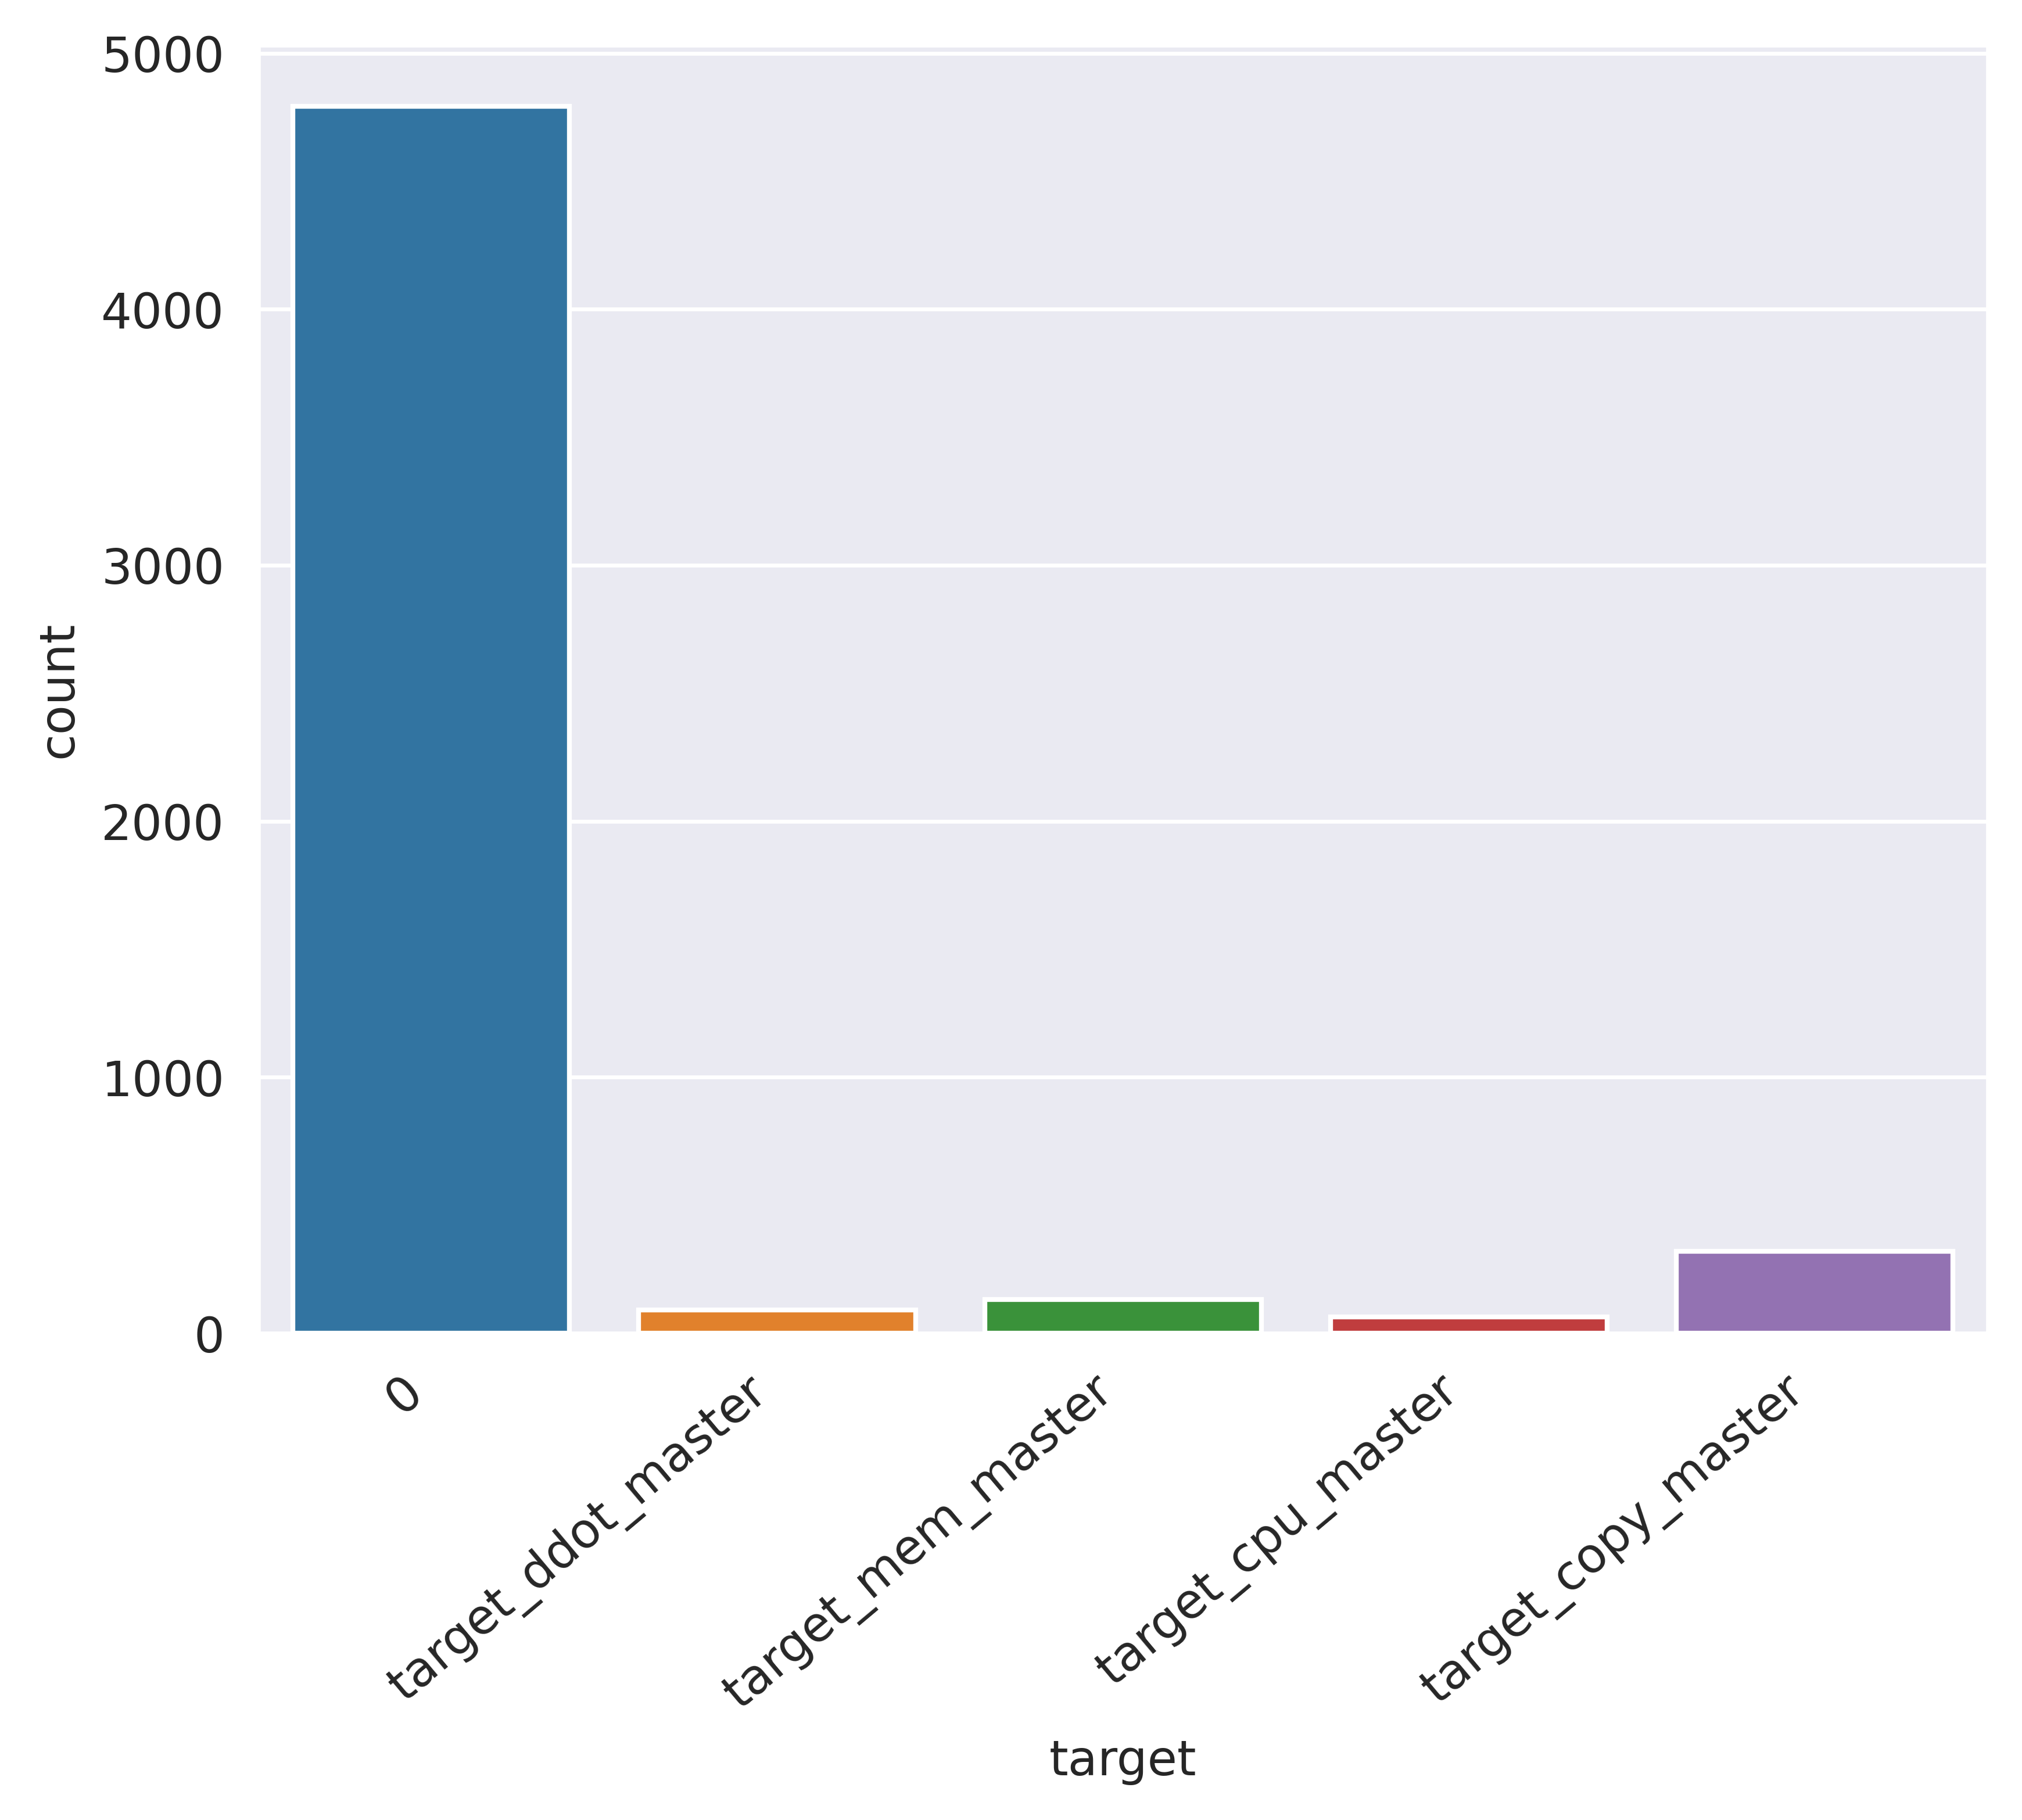

In [5]:
# Plot class distribution
print("Ploting class distribution ..")
plt.figure(dpi=600) #For publication only
class_dist_plot = sns.countplot(nice_y.to_frame(), x='target')
class_dist_plot.set_xticklabels(class_dist_plot.get_xticklabels(), rotation=40, ha="right")
fig_cd = class_dist_plot.get_figure()
fig_cd.savefig(os.path.join(model_dir,"class_dist_single_anomaly.png"), bbox_inches='tight')

In [6]:
print("Splitting dataset into training and ground truth ...")
X = data.drop('target', axis=1)
y = data['target']

Splitting dataset into training and ground truth ...


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 255), clip=True)

X_scaled = scaler.fit_transform(X)

X = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X

node_context_switches_total_10.251.0.114:9100  \
time                                                        
1626346422                                       0.000000   
1626346423                                       0.051999   
1626346424                                       0.092409   
1626346425                                       0.136219   
1626346426                                       0.181573   
...                                                   ...   
1626351817                                     254.825072   
1626351818                                     254.855128   
1626351819                                     254.905427   
1626351820                                     254.958895   
1626351821                                     255.000000   

            node_cpu_seconds_total_10.251.0.114:9100  \
time                                                   
1626346422                                  0.000000   
1626346423                                  0.000000   
1626346424                                  0.017110   
1626346425                                  0.034219   
1626346426                                  0.034219   
...                                              ...   
1626351817                                254.948671   
1626351818                                254.965781   
1626351819                                254.965781   
1626351820                                255.000000   
1626351821                                255.000000   

            node_disk_io_time_seconds_total_10.251.0.114:9100  \
time                                                            
1626346422                                           0.000000   
1626346423                                           0.831238   
1626346424                                           0.831238   
1626346425                                           0.831238   
1626346426                                           0.831238   
...                                                       ...   
1626351817                                         255.000000   
1626351818                                         255.000000   
1626351819                                         255.000000   
1626351820                                         255.000000   
1626351821                                         255.000000   

            node_disk_io_time_weighted_seconds_total_10.251.0.114:9100  \
time                                                                     
1626346422                                           0.000000            
1626346423                                           0.331007            
1626346424                                           0.331007            
1626346425                                           0.331007            
1626346426                                           0.331007            
...                                                       ...            
1626351817                                         255.000000            
1626351818                                         255.000000            
1626351819                                         255.000000            
1626351820                                         255.000000            
1626351821                                         255.000000            

            node_disk_read_bytes_total_10.251.0.114:9100  \
time                                                       
1626346422                                           0.0   
1626346423                                           0.0   
1626346424                                           0.0   
1626346425                                           0.0   
1626346426                                           0.0   
...                                                  ...   
1626351817                                         255.0   
1626351818                                         255.0   
1626351819                                         255.0   
1626351820          

In [8]:
# Tabular to image generation
from tab2img.converter import Tab2Img
model = Tab2Img()
images = model.fit_transform(np.asarray(X), np.asarray(y))
IMAGE_SHAPE = (8, 8)

In [9]:
def build_model_v2(num_classes,
                   layer_1=512,
                   layer_2=256,
                   layer_3=128,
                   drop_1=0.0,
                   drop_2=0.0,
                   drop_3=0.0,
                   drop_4=0.0,
                   drop_5=0.0,
                   drop_6=0.0,
                   activation_1='relu',
                   activation_2='relu',
                   activation_3='relu',
                   activation_4='relu',
                   activation_5='relu',
                   activation_6='relu'
                   ):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(8, 8, 1)))
    if drop_1:
        model.add(tf.keras.layers.Dropout(drop_1))
    model.add(tf.keras.layers.MaxPooling2D((1, 1)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation_1))
    if drop_2:
        model.add(tf.keras.layers.Dropout(drop_2))
    model.add(tf.keras.layers.MaxPooling2D((1, 1)))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation=activation_2))
    if drop_3:
        model.add(tf.keras.layers.Dropout(drop_3))
    model.add(tf.keras.layers.Flatten())
    if layer_1:
        model.add(tf.keras.layers.Dense(layer_1, activation=activation_3))
    if layer_2:
        model.add(tf.keras.layers.Dense(layer_2, activation=activation_4))
    if drop_4:
        model.add(tf.keras.layers.Dropout(drop_4))
    if layer_3:
        model.add(tf.keras.layers.Dense(layer_3, activation=activation_5))
    if drop_5:
        model.add(tf.keras.layers.Dropout(drop_5))
    model.add(tf.keras.layers.Dense(64, activation=activation_6))
    if drop_6:
        model.add(tf.keras.layers.Dropout(drop_6))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

Fold 0:
  Train: index=[4723 2474  344 ... 4083 1761 3475] with length 3780
  Test:  index=[4896  460 4961 ... 3473 4359 2243] with length 1620
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Epoch 1/200


2023-02-02 09:51:42.102331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 09:51:42.122236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 09:51:42.122409: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-02 09:51:42.122740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

 13/118 [==>...........................] - ETA: 0s - loss: 3.3790 - accuracy: 0.8462  

2023-02-02 09:51:43.771145: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


118/118 [==============================] - 2s 7ms/step - loss: 0.6566 - accuracy: 0.9128 - val_loss: 0.1332 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1890 - accuracy: 0.9405 - val_loss: 0.1134 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 3/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1275 - accuracy: 0.9573 - val_loss: 0.0910 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0775 - accuracy: 0.9688 - val_loss: 0.0935 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0769 - accuracy: 0.9704 - val_loss: 0.0964 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 6/200
118/118 [==============================] - 1s 4ms/step - loss: 0.1271 - accuracy: 0.9618 - val_loss: 0.0752 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/200
118/118 [==============================] - 1s 5ms/step - loss: 0

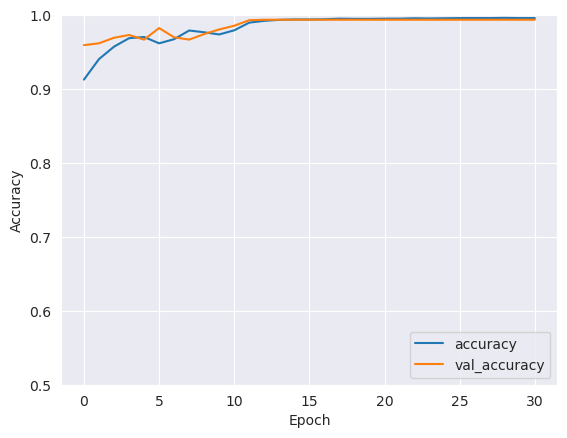

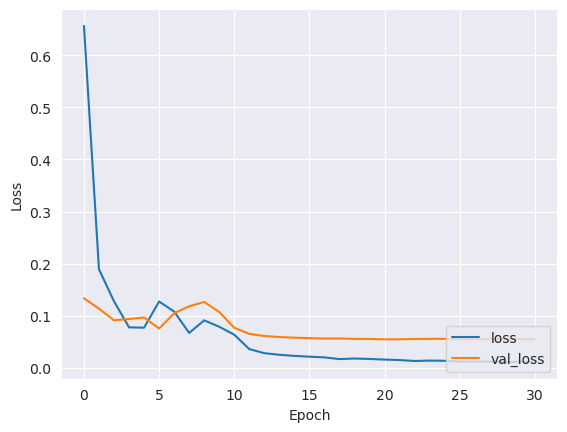

/tmp/ipykernel_1652449/1883706426.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(


Confusion matrix


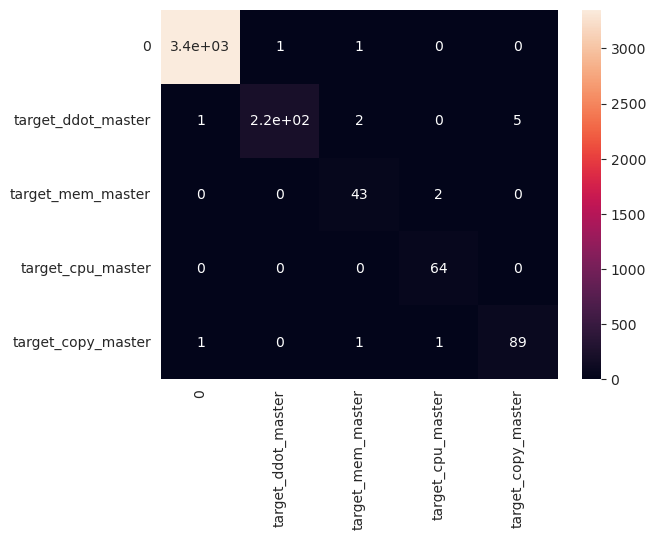

Accuracy score is: 0.996031746031746
Ballanced accuracy score is: 0.9773590002851883
Jaccard score (micro): 0.9920948616600791
Jaccard score (macro): 0.9418571540476535
Jaccard score (weighted): 0.992348863018432
Full classification report
                    precision    recall  f1-score   support

                 0     0.9994    0.9994    0.9994      3354
target_ddot_master     0.9954    0.9644    0.9797       225
 target_mem_master     0.9149    0.9556    0.9348        45
 target_cpu_master     0.9552    1.0000    0.9771        64
target_copy_master     0.9468    0.9674    0.9570        92

          accuracy                         0.9960      3780
         macro avg     0.9623    0.9774    0.9696      3780
      weighted avg     0.9961    0.9960    0.9961      3780

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9994    0.9994    0.9953    0.9994    0.9974    0.9951      3354
tar

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.3243 - accuracy: 0.8938 - val_loss: 0.8823 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 1s 5ms/step - loss: 0.4133 - accuracy: 0.9285 - val_loss: 0.1091 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1451 - accuracy: 0.9557 - val_loss: 0.1705 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 4/200
118/118 [==============================] - 1s 5ms/step - loss: 0.2469 - accuracy: 0.9557 - val_loss: 0.0969 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1448 - accuracy: 0.9485 - val_loss: 0.0724 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0889 - accuracy: 0.9666 - val_loss: 0.0500 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/200
118/118 [==============================] - 1s 5ms/step - loss: 0

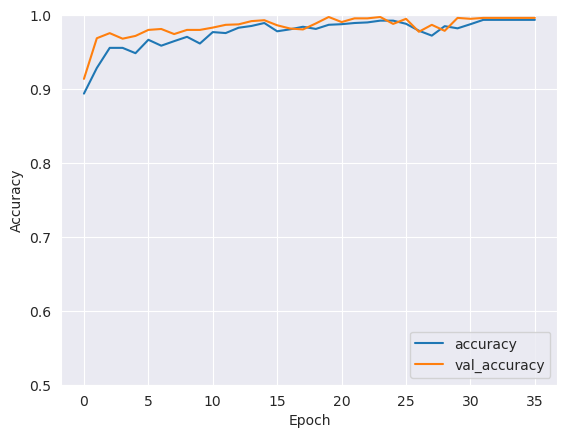

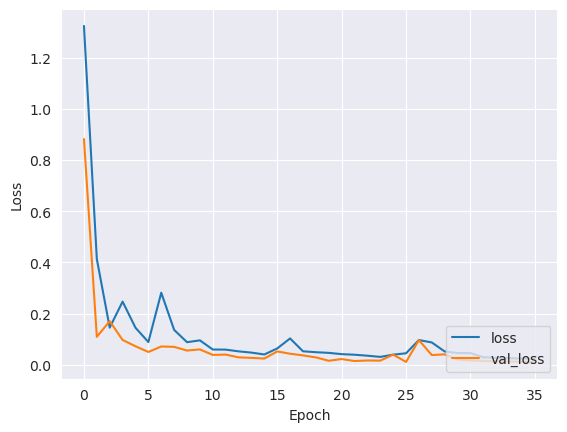

/tmp/ipykernel_1652449/1883706426.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(


Confusion matrix


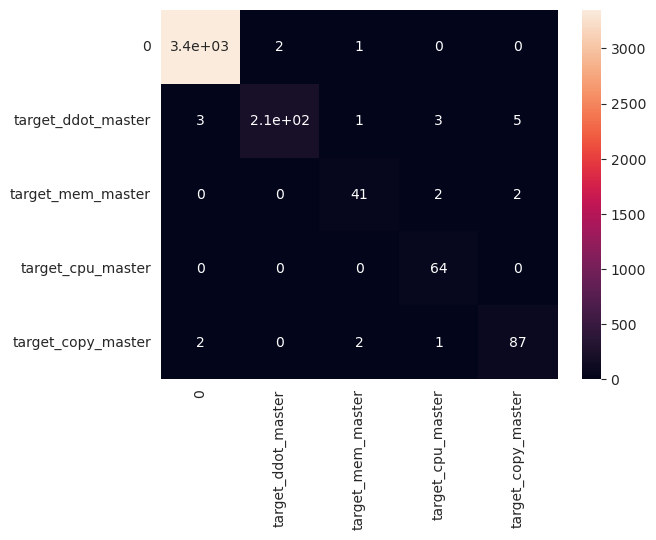

Accuracy score is: 0.9936507936507937
Ballanced accuracy score is: 0.960507099461599
Jaccard score (micro): 0.9873817034700315
Jaccard score (macro): 0.9131505233863756
Jaccard score (weighted): 0.9878706582304034
Full classification report
                    precision    recall  f1-score   support

                 0     0.9985    0.9991    0.9988      3354
target_ddot_master     0.9907    0.9467    0.9682       225
 target_mem_master     0.9111    0.9111    0.9111        45
 target_cpu_master     0.9143    1.0000    0.9552        64
target_copy_master     0.9255    0.9457    0.9355        92

          accuracy                         0.9937      3780
         macro avg     0.9480    0.9605    0.9538      3780
      weighted avg     0.9938    0.9937    0.9937      3780

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9985    0.9991    0.9883    0.9988    0.9937    0.9884      3354
ta

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5212 - accuracy: 0.8935 - val_loss: 0.1173 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1566 - accuracy: 0.9594 - val_loss: 0.0819 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1086 - accuracy: 0.9610 - val_loss: 0.0871 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0742 - accuracy: 0.9789 - val_loss: 0.0615 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0833 - accuracy: 0.9704 - val_loss: 0.0683 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0759 - accuracy: 0.9739 - val_loss: 0.0764 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/200
118/118 [==============================] - 1s 5ms/step - loss: 0

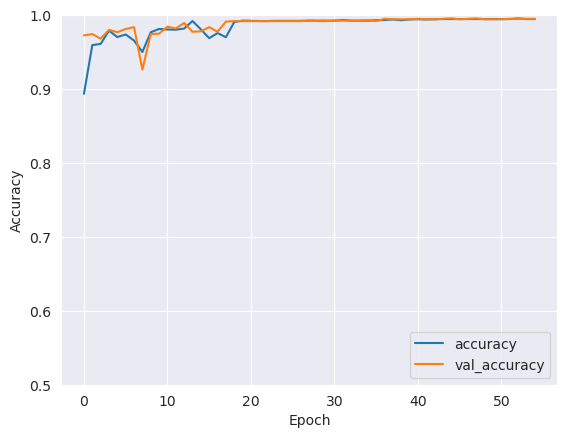

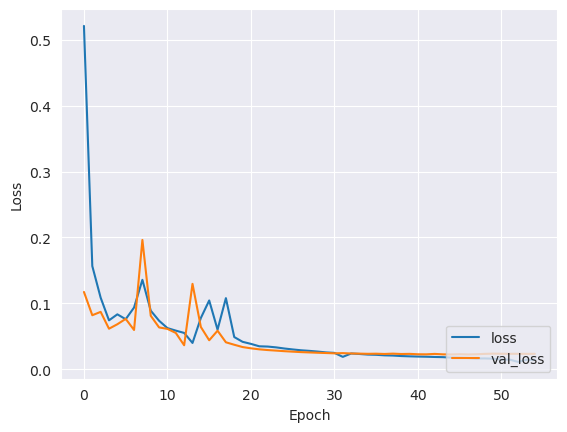

/tmp/ipykernel_1652449/1883706426.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(


Confusion matrix


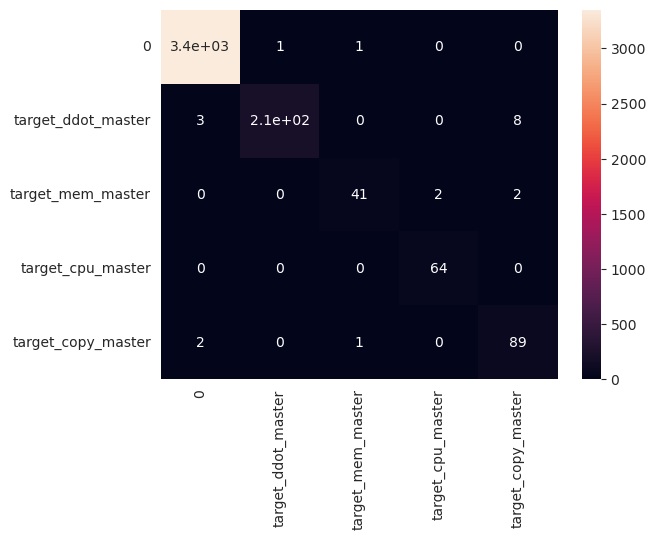

Accuracy score is: 0.9947089947089947
Ballanced accuracy score is: 0.9658034447296326
Jaccard score (micro): 0.9894736842105263
Jaccard score (macro): 0.9318810232292755
Jaccard score (weighted): 0.989855542890578
Full classification report
                    precision    recall  f1-score   support

                 0     0.9985    0.9994    0.9990      3354
target_ddot_master     0.9953    0.9511    0.9727       225
 target_mem_master     0.9535    0.9111    0.9318        45
 target_cpu_master     0.9697    1.0000    0.9846        64
target_copy_master     0.8990    0.9674    0.9319        92

          accuracy                         0.9947      3780
         macro avg     0.9632    0.9658    0.9640      3780
      weighted avg     0.9949    0.9947    0.9947      3780

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9985    0.9994    0.9883    0.9990    0.9938    0.9888      3354
ta

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7574 - accuracy: 0.9010 - val_loss: 0.4345 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 1s 5ms/step - loss: 0.3808 - accuracy: 0.9189 - val_loss: 0.1232 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 3/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1287 - accuracy: 0.9594 - val_loss: 0.0934 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/200
118/118 [==============================] - 1s 4ms/step - loss: 0.0848 - accuracy: 0.9693 - val_loss: 0.1322 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1724 - accuracy: 0.9525 - val_loss: 0.0680 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0832 - accuracy: 0.9666 - val_loss: 0.0644 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 7/200
118/118 [==============================] - 1s 4ms/step - loss: 0

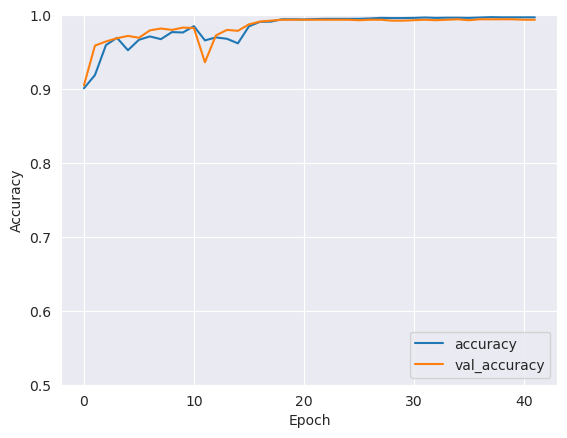

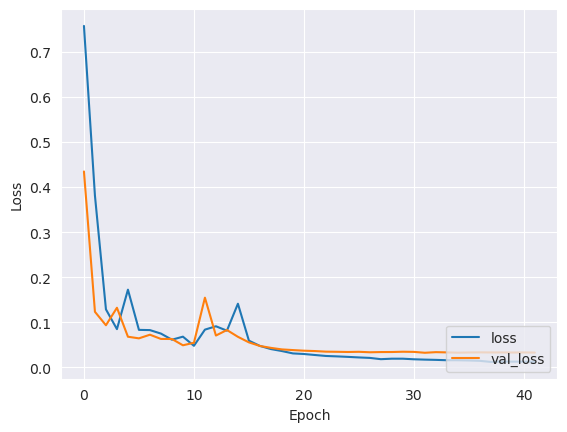

/tmp/ipykernel_1652449/1883706426.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(


Confusion matrix


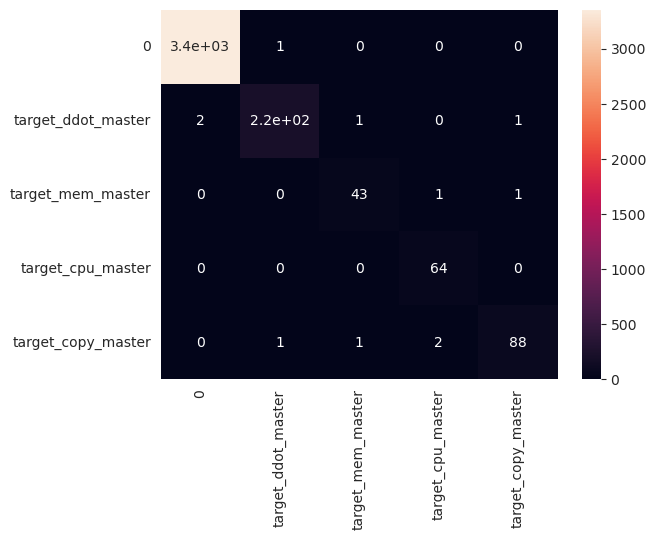

Accuracy score is: 0.9970899470899471
Ballanced accuracy score is: 0.9788002730894542
Jaccard score (micro): 0.9941967818517542
Jaccard score (macro): 0.9557924141975306
Jaccard score (weighted): 0.9943086909993195
Full classification report
                    precision    recall  f1-score   support

                 0     0.9994    0.9997    0.9996      3354
target_ddot_master     0.9910    0.9822    0.9866       225
 target_mem_master     0.9556    0.9556    0.9556        45
 target_cpu_master     0.9552    1.0000    0.9771        64
target_copy_master     0.9778    0.9565    0.9670        92

          accuracy                         0.9971      3780
         macro avg     0.9758    0.9788    0.9772      3780
      weighted avg     0.9971    0.9971    0.9971      3780

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9994    0.9997    0.9953    0.9996    0.9975    0.9954      3354
t

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 1.3983 - accuracy: 0.9010 - val_loss: 0.1414 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/200
118/118 [==============================] - 1s 5ms/step - loss: 0.2294 - accuracy: 0.9514 - val_loss: 0.1229 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 3/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1074 - accuracy: 0.9584 - val_loss: 0.0882 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1304 - accuracy: 0.9557 - val_loss: 0.1019 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 0.1148 - accuracy: 0.9653 - val_loss: 0.1761 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 6/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0950 - accuracy: 0.9637 - val_loss: 0.0681 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 7/200
118/118 [==============================] - 1s 5ms/step - loss: 0

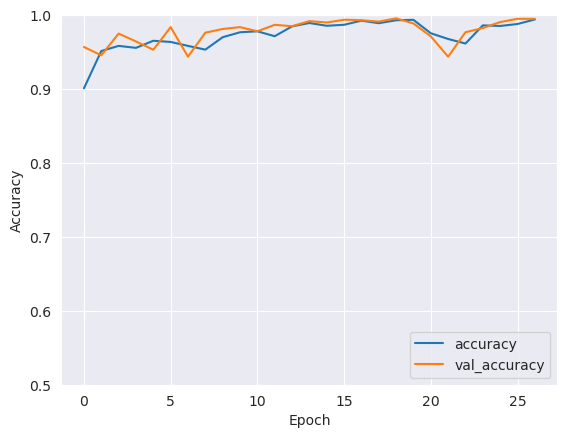

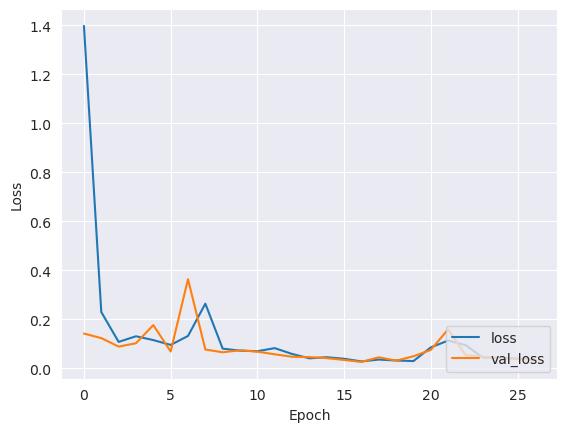

/tmp/ipykernel_1652449/1883706426.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(


Confusion matrix


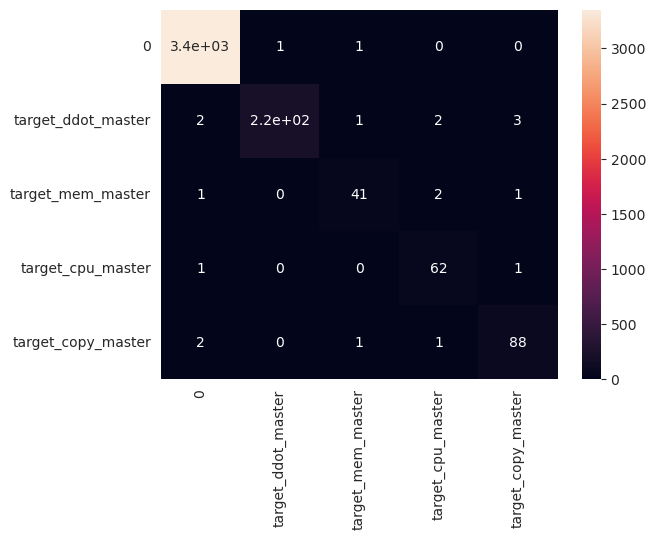

Accuracy score is: 0.9947089947089947
Ballanced accuracy score is: 0.9600461983528212
Jaccard score (micro): 0.9894736842105263
Jaccard score (macro): 0.9235459849838398
Jaccard score (weighted): 0.9898049663031006
Full classification report
                    precision    recall  f1-score   support

                 0     0.9982    0.9994    0.9988      3354
target_ddot_master     0.9954    0.9644    0.9797       225
 target_mem_master     0.9318    0.9111    0.9213        45
 target_cpu_master     0.9254    0.9688    0.9466        64
target_copy_master     0.9462    0.9565    0.9514        92

          accuracy                         0.9947      3780
         macro avg     0.9594    0.9600    0.9596      3780
      weighted avg     0.9948    0.9947    0.9947      3780

Imbalanced Classification report
                          pre       rec       spe        f1       geo       iba       sup

                 0     0.9982    0.9994    0.9859    0.9988    0.9926    0.9867      3354
t

In [10]:
# Split Training and validation
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

EPOCHS = 200
BATCH_SIZE = 32
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,)

# train_data_index = []
# test_data_index = []
for i, (train_index, test_index) in enumerate(sss.split(X, y)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index} with length {len(train_index)}")
    print(f"  Test:  index={test_index} with length {len(test_index)}")
    train_data_index = train_index
    test_data_index = test_index

    train_dir, val_dir = generate_images(images, train_data_index, test_data_index, labels=nice_y)

    datagen = tf.keras.preprocessing.image.ImageDataGenerator()
    train_generator = datagen.flow_from_directory(
        train_dir,
        color_mode='grayscale',
        shuffle=False,
        target_size=IMAGE_SHAPE,
        batch_size = 32,
        class_mode = 'categorical'
    )

    valid_generator = datagen.flow_from_directory(
        val_dir,
        color_mode='grayscale',
        shuffle=False,
        target_size=IMAGE_SHAPE,
        batch_size = 32,
        class_mode = 'categorical'
    )

    model = build_model_v2(num_classes=5)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=0.001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    # print(model.summary())
    history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator,
                    validation_steps= valid_generator.samples // BATCH_SIZE,
                    verbose=1,
                    callbacks=[es_callback, reduce_lr_callback]
                    )

    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    # plt.ylim([0.9, 2])
    plt.legend(loc='lower right')
    plt.show()

    train_generator.reset()
    y_pred = model.predict_generator(
        train_generator,
        # steps=train_generator.samples // BATCH_SIZE
    )

    y_test = train_generator.classes
    y_pred=np.argmax(y_pred,axis=1)

    print("Confusion matrix")
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns_cf = sns.heatmap(cf_matrix, annot=True, yticklabels=list(definitions), xticklabels=list(definitions))
    # cf_fig = "{}_cf_Fold{}.png".format("DNN", fold)
    # sns_cf.figure.savefig(os.path.join(model_dir, cf_fig))
    plt.show()

    custom_scoring_reporting(y_pred, y_test, definitions, f'conv_dnn_{i}')

1620.0
Removed existing training dir
Found 1134 images belonging to 5 classes.
Found 486 images belonging to 5 classes.
Epoch 1/200


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


35/35 [==============================] - 1s 10ms/step - loss: 0.9971 - accuracy: 0.6216 - val_loss: 0.3304 - val_accuracy: 0.9104 - lr: 1.0000e-04
Epoch 2/200
35/35 [==============================] - 0s 5ms/step - loss: 0.3021 - accuracy: 0.9074 - val_loss: 0.2179 - val_accuracy: 0.9167 - lr: 1.0000e-04
Epoch 3/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1941 - accuracy: 0.9456 - val_loss: 0.1365 - val_accuracy: 0.9646 - lr: 1.0000e-04
Epoch 4/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1468 - accuracy: 0.9655 - val_loss: 0.1053 - val_accuracy: 0.9708 - lr: 1.0000e-04
Epoch 5/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1156 - accuracy: 0.9583 - val_loss: 0.1133 - val_accuracy: 0.9583 - lr: 1.0000e-04
Epoch 6/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1175 - accuracy: 0.9673 - val_loss: 0.0726 - val_accuracy: 0.9708 - lr: 1.0000e-04
Epoch 7/200
35/35 [==============================] - 0s 5ms/ste

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


44/44 [==============================] - 1s 9ms/step - loss: 0.1188 - accuracy: 0.9807 - val_loss: 0.0395 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 2/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0200 - accuracy: 0.9943 - val_loss: 0.0374 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 3/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0189 - accuracy: 0.9950 - val_loss: 0.0344 - val_accuracy: 0.9967 - lr: 1.0000e-04
Epoch 4/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0283 - accuracy: 0.9871 - val_loss: 0.0416 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 5/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0190 - accuracy: 0.9964 - val_loss: 0.0387 - val_accuracy: 0.9934 - lr: 1.0000e-04
Epoch 6/200
44/44 [==============================] - 0s 5ms/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 0.0381 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 7/200
44/44 [==============================] - 0s 5ms/step

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 1s 11ms/step - loss: 0.0294 - accuracy: 0.9953 - val_loss: 0.0274 - val_accuracy: 0.9973 - lr: 1.0000e-04
Epoch 2/200
53/53 [==============================] - 0s 5ms/step - loss: 0.0242 - accuracy: 0.9953 - val_loss: 0.0309 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 3/200
53/53 [==============================] - 0s 5ms/step - loss: 0.0072 - accuracy: 0.9982 - val_loss: 0.0316 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 4/200
53/53 [==============================] - 0s 4ms/step - loss: 0.0132 - accuracy: 0.9923 - val_loss: 0.0545 - val_accuracy: 0.9864 - lr: 1.0000e-04
Epoch 5/200
53/53 [==============================] - 0s 5ms/step - loss: 0.0205 - accuracy: 0.9959 - val_loss: 0.0353 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 6/200
53/53 [==============================] - ETA: 0s - loss: 0.0110 - accuracy: 0.9982
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
53/53 [==============================] - 0s 5ms/st

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 1s 7ms/step - loss: 0.0242 - accuracy: 0.9936 - val_loss: 0.0264 - val_accuracy: 0.9954 - lr: 1.0000e-04
Epoch 2/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0115 - accuracy: 0.9970 - val_loss: 0.0262 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 3/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0187 - accuracy: 0.9906 - val_loss: 0.0256 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 4/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0148 - accuracy: 0.9950 - val_loss: 0.0392 - val_accuracy: 0.9954 - lr: 1.0000e-04
Epoch 5/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0142 - accuracy: 0.9960 - val_loss: 0.0348 - val_accuracy: 0.9942 - lr: 1.0000e-04
Epoch 6/200
63/63 [==============================] - 0s 5ms/step - loss: 0.0129 - accuracy: 0.9965 - val_loss: 0.0295 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 7/200
63/63 [==============================] - 0s 4ms/step

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


72/72 [==============================] - 1s 7ms/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0328 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 2/200
72/72 [==============================] - 0s 5ms/step - loss: 0.0049 - accuracy: 0.9982 - val_loss: 0.0316 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 3/200
72/72 [==============================] - 0s 4ms/step - loss: 0.0039 - accuracy: 0.9991 - val_loss: 0.0350 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 4/200
72/72 [==============================] - 0s 5ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0590 - val_accuracy: 0.9917 - lr: 1.0000e-04
Epoch 5/200
72/72 [==============================] - 0s 5ms/step - loss: 0.0067 - accuracy: 0.9969 - val_loss: 0.1052 - val_accuracy: 0.9823 - lr: 1.0000e-04
Epoch 6/200
72/72 [==============================] - 0s 5ms/step - loss: 0.0828 - accuracy: 0.9860 - val_loss: 0.0997 - val_accuracy: 0.9740 - lr: 1.0000e-04
Epoch 7/200
71/72 [============================>.] - ETA: 0s - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


81/81 [==============================] - 1s 7ms/step - loss: 0.2815 - accuracy: 0.9673 - val_loss: 0.0802 - val_accuracy: 0.9761 - lr: 1.0000e-04
Epoch 2/200
81/81 [==============================] - 0s 5ms/step - loss: 0.0442 - accuracy: 0.9833 - val_loss: 0.0686 - val_accuracy: 0.9862 - lr: 1.0000e-04
Epoch 3/200
81/81 [==============================] - 0s 5ms/step - loss: 0.0357 - accuracy: 0.9891 - val_loss: 0.0864 - val_accuracy: 0.9789 - lr: 1.0000e-04
Epoch 4/200
81/81 [==============================] - 0s 5ms/step - loss: 0.0700 - accuracy: 0.9782 - val_loss: 0.0770 - val_accuracy: 0.9881 - lr: 1.0000e-04
Epoch 5/200
81/81 [==============================] - 0s 5ms/step - loss: 0.0292 - accuracy: 0.9891 - val_loss: 0.0762 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 6/200
81/81 [==============================] - 0s 4ms/step - loss: 0.0273 - accuracy: 0.9930 - val_loss: 0.0841 - val_accuracy: 0.9835 - lr: 1.0000e-04
Epoch 7/200
81/81 [==============================] - 0s 5ms/step

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


90/90 [==============================] - 1s 6ms/step - loss: 0.1553 - accuracy: 0.9655 - val_loss: 0.0345 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 2/200
90/90 [==============================] - 0s 5ms/step - loss: 0.0316 - accuracy: 0.9899 - val_loss: 0.0307 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 3/200
90/90 [==============================] - 0s 4ms/step - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.0271 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 4/200
90/90 [==============================] - 0s 4ms/step - loss: 0.0230 - accuracy: 0.9962 - val_loss: 0.0282 - val_accuracy: 0.9942 - lr: 1.0000e-04
Epoch 5/200
90/90 [==============================] - 0s 5ms/step - loss: 0.0191 - accuracy: 0.9951 - val_loss: 0.0334 - val_accuracy: 0.9910 - lr: 1.0000e-04
Epoch 6/200
90/90 [==============================] - 0s 5ms/step - loss: 0.0254 - accuracy: 0.9913 - val_loss: 0.0330 - val_accuracy: 0.9951 - lr: 1.0000e-04
Epoch 7/200
90/90 [==============================] - 0s 5ms/step

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


99/99 [==============================] - 1s 8ms/step - loss: 0.0319 - accuracy: 0.9905 - val_loss: 0.0266 - val_accuracy: 0.9940 - lr: 1.0000e-04
Epoch 2/200
99/99 [==============================] - 1s 5ms/step - loss: 0.0189 - accuracy: 0.9940 - val_loss: 0.0186 - val_accuracy: 0.9978 - lr: 1.0000e-04
Epoch 3/200
99/99 [==============================] - 0s 5ms/step - loss: 0.0177 - accuracy: 0.9937 - val_loss: 0.0338 - val_accuracy: 0.9933 - lr: 1.0000e-04
Epoch 4/200
99/99 [==============================] - 0s 5ms/step - loss: 0.0184 - accuracy: 0.9956 - val_loss: 0.0237 - val_accuracy: 0.9963 - lr: 1.0000e-04
Epoch 5/200
99/99 [==============================] - 0s 5ms/step - loss: 0.0124 - accuracy: 0.9978 - val_loss: 0.0190 - val_accuracy: 0.9970 - lr: 1.0000e-04
Epoch 6/200
99/99 [==============================] - 0s 5ms/step - loss: 0.0102 - accuracy: 0.9975 - val_loss: 0.0198 - val_accuracy: 0.9970 - lr: 1.0000e-04
Epoch 7/200
96/99 [============================>.] - ETA: 0s - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


108/108 [==============================] - 1s 6ms/step - loss: 0.0131 - accuracy: 0.9974 - val_loss: 0.0215 - val_accuracy: 0.9973 - lr: 1.0000e-04
Epoch 2/200
108/108 [==============================] - 1s 5ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0523 - val_accuracy: 0.9891 - lr: 1.0000e-04
Epoch 3/200
108/108 [==============================] - 1s 5ms/step - loss: 0.0247 - accuracy: 0.9933 - val_loss: 0.0408 - val_accuracy: 0.9918 - lr: 1.0000e-04
Epoch 4/200
108/108 [==============================] - 1s 5ms/step - loss: 0.0205 - accuracy: 0.9942 - val_loss: 0.0273 - val_accuracy: 0.9959 - lr: 1.0000e-04
Epoch 5/200
108/108 [==============================] - 1s 5ms/step - loss: 0.0084 - accuracy: 0.9980 - val_loss: 0.0339 - val_accuracy: 0.9952 - lr: 1.0000e-04
Epoch 6/200
 94/108 [=========================>....] - ETA: 0s - loss: 0.0062 - accuracy: 0.9983
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
108/108 [==============================

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.0285 - accuracy: 0.9941 - val_loss: 0.0204 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 2/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0206 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 3/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.0188 - val_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 4/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.0192 - val_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 5/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0073 - accuracy: 0.9984 - val_loss: 0.0192 - val_accuracy: 0.9981 - lr: 1.0000e-04
Epoch 6/200
118/118 [==============================] - 1s 5ms/step - loss: 0.0069 - accuracy: 0.9981 - val_loss: 0.0211 - val_accuracy: 0.9975 - lr: 1.0000e-04
Epoch 7/200
118/118 [==============================]

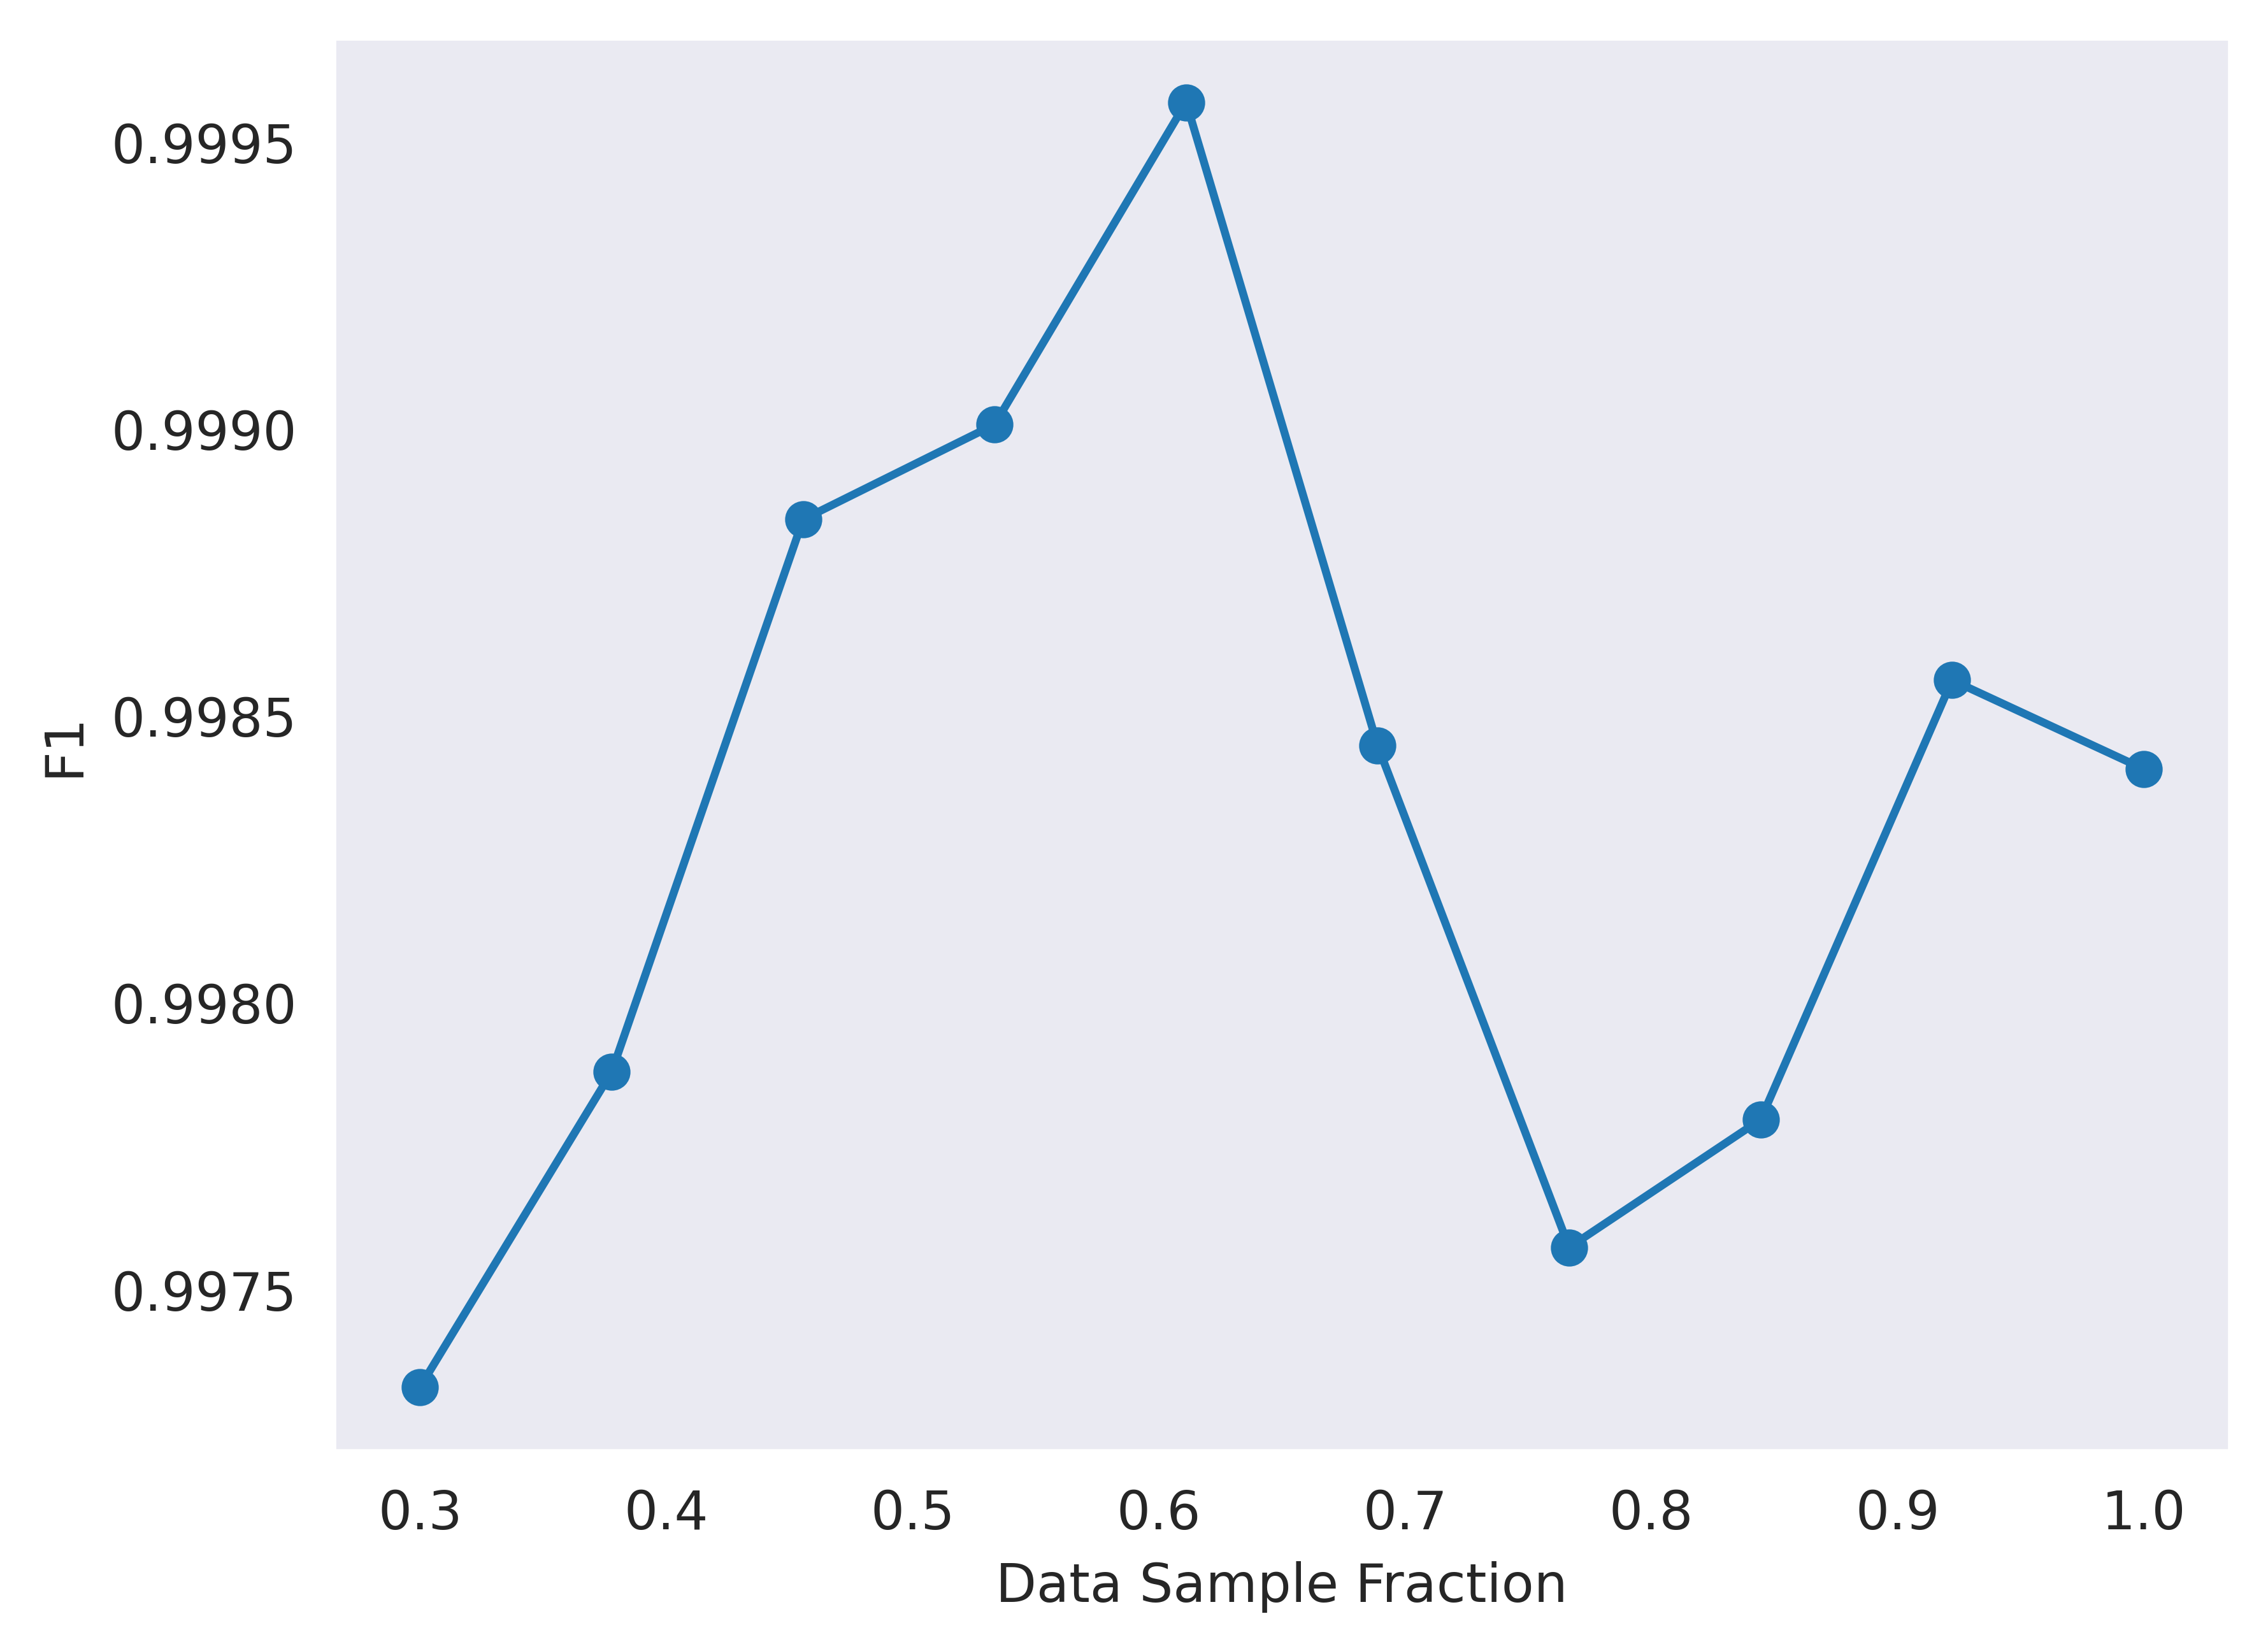

In [11]:
# Custom Learning Curve
from sklearn.metrics import f1_score
# from sklearn.learning_curve import learning_curve
plt.figure(dpi=600)
plt.grid()
ml_method = 'cnn_single_subsample'
dist = np.linspace(0.3, 1.0, 10)
score_sets = []

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,)

clf_subsample_model = build_model_v2(num_classes=5)
sss_sub = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for frac in dist:
    # X_subset = X.sample(frac=frac, random_state=42)
    # y_subset = y.sample(frac=frac, random_state=42)
    tf.keras.backend.clear_session()
    print(X.shape[0]*frac)

    # 1/0
    X_subset = X.head(int(X.shape[0]*frac))
    y_subset = y.head(int(X.shape[0]*frac))
    # print(images.shape)
    # images_subset = images.sample(frac=frac)

    patience=5
    batch_size=32
    epochs=1000

    # train_data_index = []
    # test_data_index = []
    for i, (train_index, test_index) in enumerate(sss_sub.split(X_subset, y_subset)):
        # print(f"Fold {i}:")
        # print(f"  Train: index={train_index} with length {len(train_index)}")
        # print(f"  Test:  index={test_index} with length {len(test_index)}")
        train_data_index = train_index
        test_data_index = test_index
        # print(len(train_index))
        # print(len(test_index))
        # print(type(images))
    # sys.exit()
    train_dir, val_dir = generate_images(images, train_index, test_index, labels=y_subset)

    datagen_sub = tf.keras.preprocessing.image.ImageDataGenerator()
    train_generator_sub = datagen_sub.flow_from_directory(
        train_dir,
        color_mode='grayscale',
        shuffle=False,
        target_size=IMAGE_SHAPE,
        batch_size = 32,
        class_mode = 'categorical'
    )

    valid_generator_sub = datagen_sub.flow_from_directory(
        val_dir,
        color_mode='grayscale',
        shuffle=False,
        target_size=IMAGE_SHAPE,
        batch_size = 32,
        class_mode = 'categorical'
    )
    clf_subsample_model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
    history = clf_subsample_model.fit(train_generator_sub,
                    steps_per_epoch=train_generator_sub.samples // BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=valid_generator_sub,
                    validation_steps= valid_generator_sub.samples // BATCH_SIZE,
                    verbose=1,
                    callbacks=[es_callback, reduce_lr_callback]
                    )
    train_generator_sub.reset()
    y_pred = clf_subsample_model.predict(
        train_generator_sub,
        # steps=train_generator.samples // BATCH_SIZE
    )
    y_test = train_generator_sub.classes
    print(len(y_test))
    print(len(y_pred))
    y_pred=np.argmax(y_pred,axis=1)
    f1_weighted_score=f1_score(y_test, y_pred, average='weighted')
    score_sets.append(f1_weighted_score)
    # Save history
    df_history = pd.DataFrame(history.history)
    history_name = "{}_{}_history_learningcurve.csv".format(ml_method, frac)
    df_history.to_csv(os.path.join(model_dir, history_name), index=False)

    # Plot learningcurve dnn
plt.plot(dist,score_sets, marker='o')
plt.ylabel('F1')
plt.xlabel('Data Sample Fraction')
plt.savefig(os.path.join(model_dir, f"{ml_method}_learningcurve.png"))
plt.show()

Params are set to: {'optimizer': 'adagrad', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adagrad
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4043 - accuracy: 0.9178 - val_loss: 0.1249 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1366 - accuracy: 0.9597 - val_loss: 0.0849 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0966 - accuracy: 0.9669 - val_loss: 0.0679 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0858 - accuracy: 0.9691 - val_loss: 0.0675 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0728 - accuracy: 0.9765 - val_loss: 0.0617 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0651 - accuracy: 0.9792 - val_loss: 0.0564 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.2908 - accuracy: 0.9320 - val_loss: 0.1145 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1426 - accuracy: 0.9597 - val_loss: 0.0792 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1059 - accuracy: 0.9712 - val_loss: 0.0601 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0879 - accuracy: 0.9691 - val_loss: 0.0528 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0763 - accuracy: 0.9717 - val_loss: 0.0483 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0741 - accuracy: 0.9768 - val_loss: 0.0421 - val_accuracy: 0.9925 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.3847 - accuracy: 0.9055 - val_loss: 0.1204 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1423 - accuracy: 0.9600 - val_loss: 0.0832 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1012 - accuracy: 0.9674 - val_loss: 0.0665 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0795 - accuracy: 0.9787 - val_loss: 0.0544 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0666 - accuracy: 0.9808 - val_loss: 0.0480 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0592 - accuracy: 0.9811 - val_loss: 0.0422 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5429 - accuracy: 0.8973 - val_loss: 0.1348 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1126 - accuracy: 0.9696 - val_loss: 0.0807 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0897 - accuracy: 0.9717 - val_loss: 0.0633 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0669 - accuracy: 0.9808 - val_loss: 0.0638 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0646 - accuracy: 0.9805 - val_loss: 0.0509 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0554 - accuracy: 0.9827 - val_loss: 0.0516 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.3623 - accuracy: 0.9112 - val_loss: 0.1471 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1473 - accuracy: 0.9578 - val_loss: 0.1080 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1103 - accuracy: 0.9674 - val_loss: 0.0847 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9757 - val_loss: 0.0712 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0777 - accuracy: 0.9763 - val_loss: 0.0671 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0703 - accuracy: 0.9800 - val_loss: 0.0602 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5079 - accuracy: 0.9015 - val_loss: 0.1362 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1941 - accuracy: 0.9544 - val_loss: 0.0991 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9592 - val_loss: 0.0905 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2043 - accuracy: 0.9330 - val_loss: 0.5798 - val_accuracy: 0.7713 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.3131 - accuracy: 0.9330 - val_loss: 0.0890 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0886 - accuracy: 0.9674 - val_loss: 0.0804 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.9546 - accuracy: 0.8981 - val_loss: 0.1285 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1679 - accuracy: 0.9581 - val_loss: 0.1463 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1005 - accuracy: 0.9677 - val_loss: 0.0923 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1045 - accuracy: 0.9720 - val_loss: 0.0717 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0998 - accuracy: 0.9650 - val_loss: 0.0841 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0786 - accuracy: 0.9733 - val_loss: 0.0994 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6493 - accuracy: 0.8989 - val_loss: 0.0967 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1488 - accuracy: 0.9496 - val_loss: 0.1282 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1696 - accuracy: 0.9370 - val_loss: 0.0744 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1245 - accuracy: 0.9626 - val_loss: 0.0672 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1216 - accuracy: 0.9573 - val_loss: 0.0714 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0909 - accuracy: 0.9669 - val_loss: 0.0453 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6921 - accuracy: 0.8938 - val_loss: 0.2696 - val_accuracy: 0.8906 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2428 - accuracy: 0.9429 - val_loss: 0.0830 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1041 - accuracy: 0.9562 - val_loss: 0.0867 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0947 - accuracy: 0.9661 - val_loss: 0.0809 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0769 - accuracy: 0.9741 - val_loss: 0.0647 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0874 - accuracy: 0.9699 - val_loss: 0.0782 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1195 - accuracy: 0.9021 - val_loss: 0.2820 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2102 - accuracy: 0.9426 - val_loss: 0.1580 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0991 - accuracy: 0.9669 - val_loss: 0.0999 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1282 - accuracy: 0.9624 - val_loss: 0.1023 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0981 - accuracy: 0.9731 - val_loss: 0.1113 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0989 - accuracy: 0.9728 - val_loss: 0.0810 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7239 - accuracy: 0.8981 - val_loss: 0.3745 - val_accuracy: 0.9656 - lr: 0.0100
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1694 - accuracy: 0.9528 - val_loss: 0.1048 - val_accuracy: 0.9650 - lr: 0.0100
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1066 - accuracy: 0.9608 - val_loss: 0.0953 - val_accuracy: 0.9675 - lr: 0.0100
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1512 - accuracy: 0.9592 - val_loss: 0.0988 - val_accuracy: 0.9619 - lr: 0.0100
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0891 - accuracy: 0.9661 - val_loss: 0.0755 - val_accuracy: 0.9706 - lr: 0.0100
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0740 - accuracy: 0.9712 - val_loss: 0.0761 - val_accuracy: 0.9737 - lr: 0.0100
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.0046 - accuracy: 0.8228 - val_loss: 0.1924 - val_accuracy: 0.9019 - lr: 0.0100
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2466 - accuracy: 0.9256 - val_loss: 0.1524 - val_accuracy: 0.9513 - lr: 0.0100
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2249 - accuracy: 0.9552 - val_loss: 0.1208 - val_accuracy: 0.9663 - lr: 0.0100
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1075 - accuracy: 0.9669 - val_loss: 0.0858 - val_accuracy: 0.9619 - lr: 0.0100
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1093 - accuracy: 0.9624 - val_loss: 0.0747 - val_accuracy: 0.9706 - lr: 0.0100
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0830 - accuracy: 0.9685 - val_loss: 0.0593 - val_accuracy: 0.9806 - lr: 0.0100
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8145 - accuracy: 0.8935 - val_loss: 0.1660 - val_accuracy: 0.9581 - lr: 0.0100
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1956 - accuracy: 0.9224 - val_loss: 0.2008 - val_accuracy: 0.9031 - lr: 0.0100
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1608 - accuracy: 0.9352 - val_loss: 0.1579 - val_accuracy: 0.9656 - lr: 0.0100
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0993 - accuracy: 0.9640 - val_loss: 0.0720 - val_accuracy: 0.9694 - lr: 0.0100
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0877 - accuracy: 0.9661 - val_loss: 0.0666 - val_accuracy: 0.9712 - lr: 0.0100
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0755 - accuracy: 0.9755 - val_loss: 0.0604 - val_accuracy: 0.9725 - lr: 0.0100
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 1.7108 - accuracy: 0.7850 - val_loss: 0.2120 - val_accuracy: 0.9531 - lr: 0.0100
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3079 - accuracy: 0.9304 - val_loss: 0.1668 - val_accuracy: 0.9556 - lr: 0.0100
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1455 - accuracy: 0.9477 - val_loss: 0.0897 - val_accuracy: 0.9669 - lr: 0.0100
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0902 - accuracy: 0.9616 - val_loss: 0.0806 - val_accuracy: 0.9712 - lr: 0.0100
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0941 - accuracy: 0.9661 - val_loss: 0.0833 - val_accuracy: 0.9712 - lr: 0.0100
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0873 - accuracy: 0.9653 - val_loss: 0.1182 - val_accuracy: 0.9575 - lr: 0.0100
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5888 - accuracy: 0.8591 - val_loss: 0.1361 - val_accuracy: 0.9581 - lr: 0.0100
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1364 - accuracy: 0.9568 - val_loss: 0.3330 - val_accuracy: 0.9256 - lr: 0.0100
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1066 - accuracy: 0.9637 - val_loss: 0.3613 - val_accuracy: 0.9250 - lr: 0.0100
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0873 - accuracy: 0.9674 - val_loss: 0.0625 - val_accuracy: 0.9806 - lr: 0.0100
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0657 - accuracy: 0.9792 - val_loss: 0.0556 - val_accuracy: 0.9862 - lr: 0.0100
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0634 - accuracy: 0.9840 - val_loss: 0.0523 - val_accuracy: 0.9875 - lr: 0.0100
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

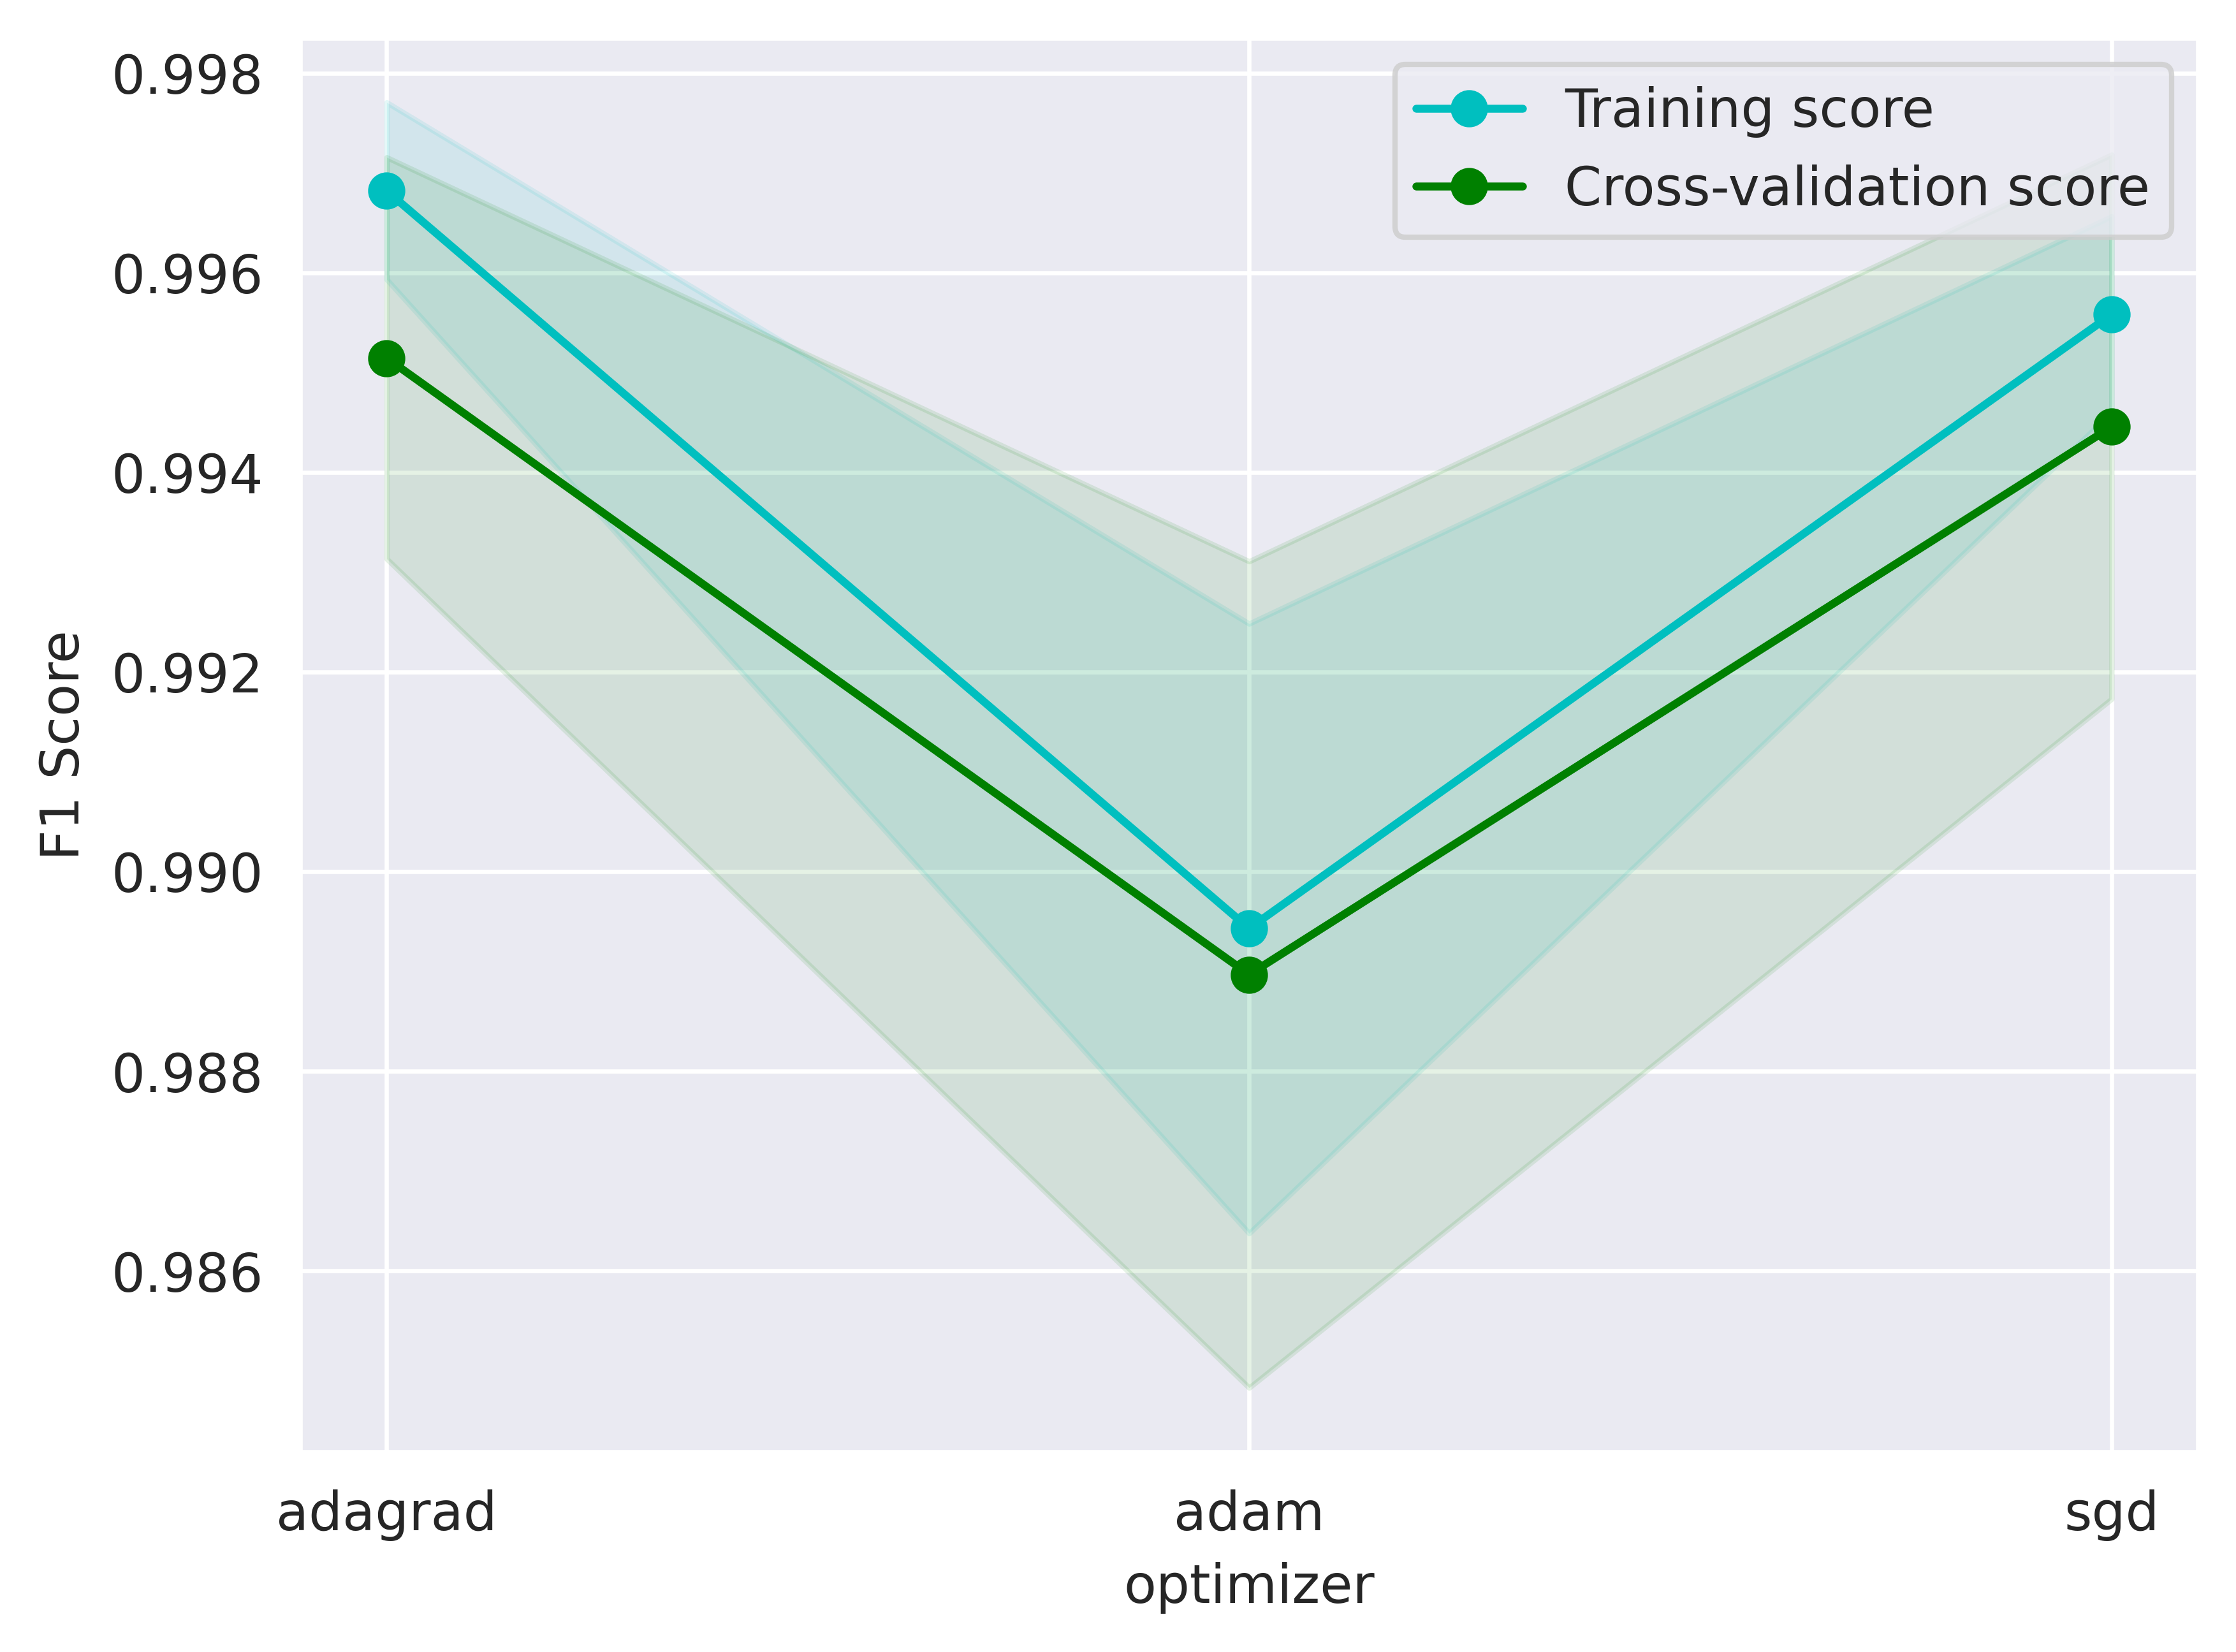

In [12]:
#Type of optimizers Validation Score
plt.figure(dpi=600)

param_range = [
    {"optimizer":"adagrad"},
    {"optimizer":"adam"},
    {"optimizer":"sgd"},
    ]

params = {"optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

score_sets = []

np_train_scores = np.empty((0, sss.n_splits))
np_test_scores = np.empty((0, sss.n_splits))

# Get param name and values
param_values = []
param_name = list(param_range[0].keys())[0]
for d in param_range:
    param_values.append(list(d.values())[0])
param_labels = param_values

# Check if param values have string type
if any(isinstance(item, str) for item in param_values):
    len_param_values = len(param_values)
    param_values = list(range(0,len_param_values))

sss_validation_curve = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

for param in param_range:
    params.update(param)
    print(f"Params are set to: {params}")
    cv_scores_train = []
    cv_scores_test = []
    fold=1
    for train_index, test_index in sss_validation_curve.split(X, y):
        tf.keras.backend.clear_session()
        train_data_index = train_index
        test_data_index = test_index

        train_dir, val_dir = generate_images(images, train_data_index,test_data_index, labels=nice_y)

        datagen_val = tf.keras.preprocessing.image.ImageDataGenerator()
        train_generator_val = datagen_val.flow_from_directory(
            train_dir,
            color_mode='grayscale',
            shuffle=False,
            target_size=IMAGE_SHAPE,
            batch_size = 32,
            class_mode = 'categorical'
        )

        valid_generator_val = datagen_val.flow_from_directory(
            val_dir,
            color_mode='grayscale',
            shuffle=False,
            target_size=IMAGE_SHAPE,
            batch_size = 32,
            class_mode = 'categorical'
        )
        optimizer = params.pop('optimizer', tf.keras.optimizers.Adam(lr=0.0001))
        # optimizer = params.pop('optimizer', None)
        print(f"Optimizer is set to: {optimizer}")

        model_clf = build_model_v2(**params)
        model_clf.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])
        params.update({"optimizer": optimizer})
        history = model_clf.fit(train_generator_val,
                steps_per_epoch=train_generator_val.samples // BATCH_SIZE,
                epochs=1000,
                validation_data=valid_generator_val,
                validation_steps= valid_generator_val.samples // BATCH_SIZE,
                verbose=1,
                callbacks=[es_callback, reduce_lr_callback]
                )

        # Score train set
        train_generator_val.reset()
        y_pred_train = model_clf.predict(
            train_generator_val,
            # steps=train_generator.samples // BATCH_SIZE
        )
        y_test_train = train_generator_val.classes
        y_pred_train=np.argmax(y_pred_train,axis=1)
        f1_weighted_score_train=f1_score(y_test_train, y_pred_train, average='weighted')

        # Score test set
        valid_generator_val.reset()
        y_pred_test = model_clf.predict(
            valid_generator_val,
            # steps=train_generator.samples // BATCH_SIZE
        )
        y_test_test = valid_generator_val.classes
        y_pred_test=np.argmax(y_pred_test,axis=1)
        f1_weighted_score_test=f1_score(y_test_test, y_pred_test, average='weighted')

        cv_scores_test.append(f1_weighted_score_test)
        cv_scores_train.append(f1_weighted_score_train)

        # Save history
        df_history = pd.DataFrame(history.history)
        history_name = "{}_{}_history_Fold{}_{}_learningcurve.csv".format(ml_method, param, fold, "optimizer")
        df_history.to_csv(os.path.join(model_dir, history_name), index=False)

        fold+=1

    np_train_scores = np.append(np_train_scores,[cv_scores_train], axis=0)
    np_test_scores = np.append(np_test_scores,[cv_scores_test], axis=0)

# Compute for fill_between plot
np_train_scores_mean = np.mean(np_train_scores, axis=1)
np_train_scores_std = np.std(np_train_scores, axis=1)
np_test_scores_mean = np.mean(np_test_scores, axis=1)
np_test_scores_std = np.std(np_test_scores, axis=1)

# Plot
plt.grid()
plt.fill_between(param_values, np_train_scores_mean - np_train_scores_std,
             np_train_scores_mean + np_train_scores_std, alpha=0.1,
             color="c")
plt.fill_between(param_values, np_test_scores_mean - np_test_scores_std,
             np_test_scores_mean + np_test_scores_std, alpha=0.1, color="g")
plt.plot(param_values, np_train_scores_mean, 'o-', color="c",
     label="Training score")
plt.plot(param_values, np_test_scores_mean, 'o-', color="g",
     label="Cross-validation score")

# Labels and legends
plt.xticks(ticks=param_values, labels=param_labels)
plt.ylabel("F1 Score")
plt.xlabel(param_name)
# plt.legend(loc='upper right')
plt.legend(loc="best")
plt.savefig(os.path.join(model_dir, f"{ml_method}_optimizer_learningcurve.png"))
plt.grid()
plt.show()

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 0, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1822 - accuracy: 0.9189 - val_loss: 0.1012 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1453 - accuracy: 0.9464 - val_loss: 0.1706 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1294 - accuracy: 0.9664 - val_loss: 0.0875 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0701 - accuracy: 0.9808 - val_loss: 0.0661 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0904 - accuracy: 0.9760 - val_loss: 0.0546 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0717 - accuracy: 0.9789 - val_loss: 0.0620 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 1.0959 - accuracy: 0.8639 - val_loss: 0.1482 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2459 - accuracy: 0.9354 - val_loss: 0.0729 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1382 - accuracy: 0.9637 - val_loss: 0.0959 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1358 - accuracy: 0.9632 - val_loss: 0.0697 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1105 - accuracy: 0.9666 - val_loss: 0.0537 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1139 - accuracy: 0.9757 - val_loss: 0.0799 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.7953 - accuracy: 0.8914 - val_loss: 0.1439 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9506 - val_loss: 0.0865 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1302 - accuracy: 0.9605 - val_loss: 0.1824 - val_accuracy: 0.9406 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1818 - accuracy: 0.9549 - val_loss: 0.1822 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1932 - accuracy: 0.9546 - val_loss: 0.1136 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1357 - accuracy: 0.9640 - val_loss: 0.0776 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.9688 - accuracy: 0.9317 - val_loss: 0.1310 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1334 - accuracy: 0.9541 - val_loss: 0.1026 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1432 - accuracy: 0.9552 - val_loss: 0.0919 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0952 - accuracy: 0.9637 - val_loss: 0.0616 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.9779 - val_loss: 0.0866 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1214 - accuracy: 0.9618 - val_loss: 0.0686 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.0429 - accuracy: 0.8941 - val_loss: 0.1066 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1334 - accuracy: 0.9637 - val_loss: 0.0667 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0950 - accuracy: 0.9725 - val_loss: 0.0717 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0793 - accuracy: 0.9760 - val_loss: 0.1532 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0801 - accuracy: 0.9760 - val_loss: 0.0465 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0597 - accuracy: 0.9795 - val_loss: 0.1670 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.4679 - accuracy: 0.8973 - val_loss: 0.2376 - val_accuracy: 0.9125 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2586 - accuracy: 0.9346 - val_loss: 0.1422 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2778 - accuracy: 0.9168 - val_loss: 0.0980 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1109 - accuracy: 0.9626 - val_loss: 0.0707 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9682 - val_loss: 0.0718 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0736 - accuracy: 0.9704 - val_loss: 0.0781 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6346 - accuracy: 0.9055 - val_loss: 0.1281 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2237 - accuracy: 0.9389 - val_loss: 0.1511 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1820 - accuracy: 0.9362 - val_loss: 0.0917 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1363 - accuracy: 0.9610 - val_loss: 0.0765 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0947 - accuracy: 0.9610 - val_loss: 0.0633 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1110 - accuracy: 0.9621 - val_loss: 0.0673 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4140 - accuracy: 0.8925 - val_loss: 0.1362 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1666 - accuracy: 0.9536 - val_loss: 0.1052 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2037 - accuracy: 0.9488 - val_loss: 0.1159 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1150 - accuracy: 0.9618 - val_loss: 0.0643 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0788 - accuracy: 0.9666 - val_loss: 0.0630 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0875 - accuracy: 0.9685 - val_loss: 0.0557 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5621 - accuracy: 0.8943 - val_loss: 0.1837 - val_accuracy: 0.9388 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1780 - accuracy: 0.9322 - val_loss: 0.1147 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1239 - accuracy: 0.9621 - val_loss: 0.0954 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0939 - accuracy: 0.9584 - val_loss: 0.0817 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.9733 - val_loss: 0.0740 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0704 - accuracy: 0.9725 - val_loss: 0.0767 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5377 - accuracy: 0.9101 - val_loss: 0.2275 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1798 - accuracy: 0.9488 - val_loss: 0.1420 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1264 - accuracy: 0.9568 - val_loss: 0.0900 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1023 - accuracy: 0.9650 - val_loss: 0.0790 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1084 - accuracy: 0.9602 - val_loss: 0.0834 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1082 - accuracy: 0.9650 - val_loss: 0.0702 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9084 - accuracy: 0.8855 - val_loss: 0.1748 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1595 - accuracy: 0.9477 - val_loss: 0.0905 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1319 - accuracy: 0.9613 - val_loss: 0.0984 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1243 - accuracy: 0.9677 - val_loss: 0.0736 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0817 - accuracy: 0.9717 - val_loss: 0.0636 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1488 - accuracy: 0.9525 - val_loss: 0.2780 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6324 - accuracy: 0.8791 - val_loss: 0.1994 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2267 - accuracy: 0.9509 - val_loss: 0.1345 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1505 - accuracy: 0.9512 - val_loss: 0.0698 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1116 - accuracy: 0.9672 - val_loss: 0.1541 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2242 - accuracy: 0.9354 - val_loss: 0.2405 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1576 - accuracy: 0.9674 - val_loss: 0.0663 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9069 - accuracy: 0.9184 - val_loss: 0.1112 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2042 - accuracy: 0.9498 - val_loss: 0.0761 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1032 - accuracy: 0.9648 - val_loss: 0.0612 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0884 - accuracy: 0.9685 - val_loss: 0.0711 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0870 - accuracy: 0.9674 - val_loss: 0.0560 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0781 - accuracy: 0.9685 - val_loss: 0.0560 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7817 - accuracy: 0.8706 - val_loss: 0.1441 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2699 - accuracy: 0.9456 - val_loss: 0.2223 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1724 - accuracy: 0.9610 - val_loss: 0.1691 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1147 - accuracy: 0.9576 - val_loss: 0.0959 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0907 - accuracy: 0.9645 - val_loss: 0.1182 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0855 - accuracy: 0.9669 - val_loss: 0.0699 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4765 - accuracy: 0.9112 - val_loss: 0.2290 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1535 - accuracy: 0.9629 - val_loss: 0.0998 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1306 - accuracy: 0.9661 - val_loss: 0.1352 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1039 - accuracy: 0.9680 - val_loss: 0.0746 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9592 - val_loss: 0.1558 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2206 - accuracy: 0.9557 - val_loss: 0.0827 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6245 - accuracy: 0.8957 - val_loss: 0.1907 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 0.9504 - val_loss: 0.1891 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2198 - accuracy: 0.9354 - val_loss: 0.1556 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1338 - accuracy: 0.9613 - val_loss: 0.0858 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0957 - accuracy: 0.9640 - val_loss: 0.0753 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0845 - accuracy: 0.9656 - val_loss: 0.0823 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7154 - accuracy: 0.8589 - val_loss: 0.2596 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2109 - accuracy: 0.9285 - val_loss: 0.2541 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1855 - accuracy: 0.9626 - val_loss: 0.1484 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1258 - accuracy: 0.9704 - val_loss: 0.0648 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0930 - accuracy: 0.9701 - val_loss: 0.0791 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1004 - accuracy: 0.9712 - val_loss: 0.0911 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5771 - accuracy: 0.8877 - val_loss: 0.2536 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3431 - accuracy: 0.8989 - val_loss: 0.1743 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1120 - accuracy: 0.9578 - val_loss: 0.1499 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1083 - accuracy: 0.9658 - val_loss: 0.0620 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1068 - accuracy: 0.9653 - val_loss: 0.0969 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0808 - accuracy: 0.9747 - val_loss: 0.0645 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7076 - accuracy: 0.8922 - val_loss: 0.1172 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2289 - accuracy: 0.9509 - val_loss: 0.2019 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1334 - accuracy: 0.9554 - val_loss: 0.0642 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1015 - accuracy: 0.9688 - val_loss: 0.0742 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0862 - accuracy: 0.9752 - val_loss: 0.1209 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1268 - accuracy: 0.9707 - val_loss: 0.0940 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4770 - accuracy: 0.9066 - val_loss: 0.1410 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2133 - accuracy: 0.9490 - val_loss: 0.0962 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1182 - accuracy: 0.9528 - val_loss: 0.1023 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1347 - accuracy: 0.9597 - val_loss: 0.0745 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0867 - accuracy: 0.9666 - val_loss: 0.0754 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0681 - accuracy: 0.9744 - val_loss: 0.0783 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5637 - accuracy: 0.8994 - val_loss: 0.0983 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1705 - accuracy: 0.9650 - val_loss: 0.0966 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1333 - accuracy: 0.9624 - val_loss: 0.0878 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0973 - accuracy: 0.9685 - val_loss: 0.0627 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1412 - accuracy: 0.9629 - val_loss: 0.0563 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1789 - accuracy: 0.9552 - val_loss: 0.0968 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5840 - accuracy: 0.9018 - val_loss: 0.0872 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1442 - accuracy: 0.9584 - val_loss: 0.0695 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1198 - accuracy: 0.9691 - val_loss: 0.0846 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1066 - accuracy: 0.9642 - val_loss: 0.0845 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0960 - accuracy: 0.9674 - val_loss: 0.0477 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9634 - val_loss: 0.0503 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7671 - accuracy: 0.8997 - val_loss: 0.1242 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1498 - accuracy: 0.9560 - val_loss: 0.0899 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1054 - accuracy: 0.9629 - val_loss: 0.0742 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1497 - accuracy: 0.9514 - val_loss: 0.0877 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1134 - accuracy: 0.9576 - val_loss: 0.0616 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0829 - accuracy: 0.9693 - val_loss: 0.0574 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6291 - accuracy: 0.9170 - val_loss: 0.6605 - val_accuracy: 0.9006 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2590 - accuracy: 0.9426 - val_loss: 0.0941 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0898 - accuracy: 0.9666 - val_loss: 0.1061 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0768 - accuracy: 0.9725 - val_loss: 0.1912 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1409 - accuracy: 0.9688 - val_loss: 0.0835 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1261 - accuracy: 0.9666 - val_loss: 0.1290 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7539 - accuracy: 0.9181 - val_loss: 0.2771 - val_accuracy: 0.8900 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2331 - accuracy: 0.9498 - val_loss: 0.0922 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1761 - accuracy: 0.9538 - val_loss: 0.0881 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1584 - accuracy: 0.9570 - val_loss: 0.0749 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9650 - val_loss: 0.0739 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9731 - val_loss: 0.0534 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6481 - accuracy: 0.8871 - val_loss: 0.4224 - val_accuracy: 0.8781 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1597 - accuracy: 0.9493 - val_loss: 0.1098 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1324 - accuracy: 0.9562 - val_loss: 0.0942 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1545 - accuracy: 0.9485 - val_loss: 0.0743 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0981 - accuracy: 0.9621 - val_loss: 0.0868 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0825 - accuracy: 0.9693 - val_loss: 0.0703 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 2.1761 - accuracy: 0.8898 - val_loss: 0.2701 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3161 - accuracy: 0.9330 - val_loss: 0.1033 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1518 - accuracy: 0.9613 - val_loss: 0.0622 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1053 - accuracy: 0.9645 - val_loss: 0.0848 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0957 - accuracy: 0.9666 - val_loss: 0.0579 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0797 - accuracy: 0.9768 - val_loss: 0.0590 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.5263 - accuracy: 0.9125 - val_loss: 0.1464 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1977 - accuracy: 0.9290 - val_loss: 0.0842 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1103 - accuracy: 0.9570 - val_loss: 0.0666 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0944 - accuracy: 0.9704 - val_loss: 0.0694 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0996 - accuracy: 0.9648 - val_loss: 0.0680 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0904 - accuracy: 0.9688 - val_loss: 0.0536 - val_accuracy: 0.9894 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7955 - accuracy: 0.8834 - val_loss: 0.1350 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1315 - accuracy: 0.9589 - val_loss: 0.1082 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1658 - accuracy: 0.9544 - val_loss: 0.1303 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1218 - accuracy: 0.9717 - val_loss: 0.0920 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0846 - accuracy: 0.9731 - val_loss: 0.0694 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0741 - accuracy: 0.9717 - val_loss: 0.0662 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6539 - accuracy: 0.8914 - val_loss: 0.1028 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1731 - accuracy: 0.9386 - val_loss: 0.1422 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9640 - val_loss: 0.1093 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1167 - accuracy: 0.9552 - val_loss: 0.1146 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1057 - accuracy: 0.9688 - val_loss: 0.0785 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0637 - accuracy: 0.9765 - val_loss: 0.0581 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.0162 - accuracy: 0.8930 - val_loss: 0.1109 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9602 - val_loss: 0.1098 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0950 - accuracy: 0.9661 - val_loss: 0.0747 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0862 - accuracy: 0.9773 - val_loss: 0.1485 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.5087 - accuracy: 0.9109 - val_loss: 0.2148 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1596 - accuracy: 0.9429 - val_loss: 0.0806 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8168 - accuracy: 0.9090 - val_loss: 0.1168 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1437 - accuracy: 0.9522 - val_loss: 0.1432 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1134 - accuracy: 0.9586 - val_loss: 0.0618 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0874 - accuracy: 0.9680 - val_loss: 0.0573 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0956 - accuracy: 0.9755 - val_loss: 0.0714 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1577 - accuracy: 0.9472 - val_loss: 0.2167 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 1.8569 - accuracy: 0.8842 - val_loss: 0.2801 - val_accuracy: 0.9337 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2554 - accuracy: 0.9218 - val_loss: 0.1124 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1388 - accuracy: 0.9538 - val_loss: 0.0683 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1689 - accuracy: 0.9464 - val_loss: 0.2144 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2097 - accuracy: 0.9437 - val_loss: 0.1194 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1239 - accuracy: 0.9616 - val_loss: 0.0764 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6120 - accuracy: 0.9053 - val_loss: 0.1078 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2545 - accuracy: 0.9421 - val_loss: 0.1118 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1134 - accuracy: 0.9658 - val_loss: 0.1505 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9701 - val_loss: 0.0587 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0781 - accuracy: 0.9680 - val_loss: 0.0531 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1017 - accuracy: 0.9674 - val_loss: 0.0701 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1006 - accuracy: 0.8818 - val_loss: 0.3028 - val_accuracy: 0.9137 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1810 - accuracy: 0.9506 - val_loss: 0.2460 - val_accuracy: 0.9194 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1273 - accuracy: 0.9573 - val_loss: 0.0991 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0924 - accuracy: 0.9629 - val_loss: 0.0705 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0940 - accuracy: 0.9642 - val_loss: 0.1035 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0785 - accuracy: 0.9696 - val_loss: 0.0950 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

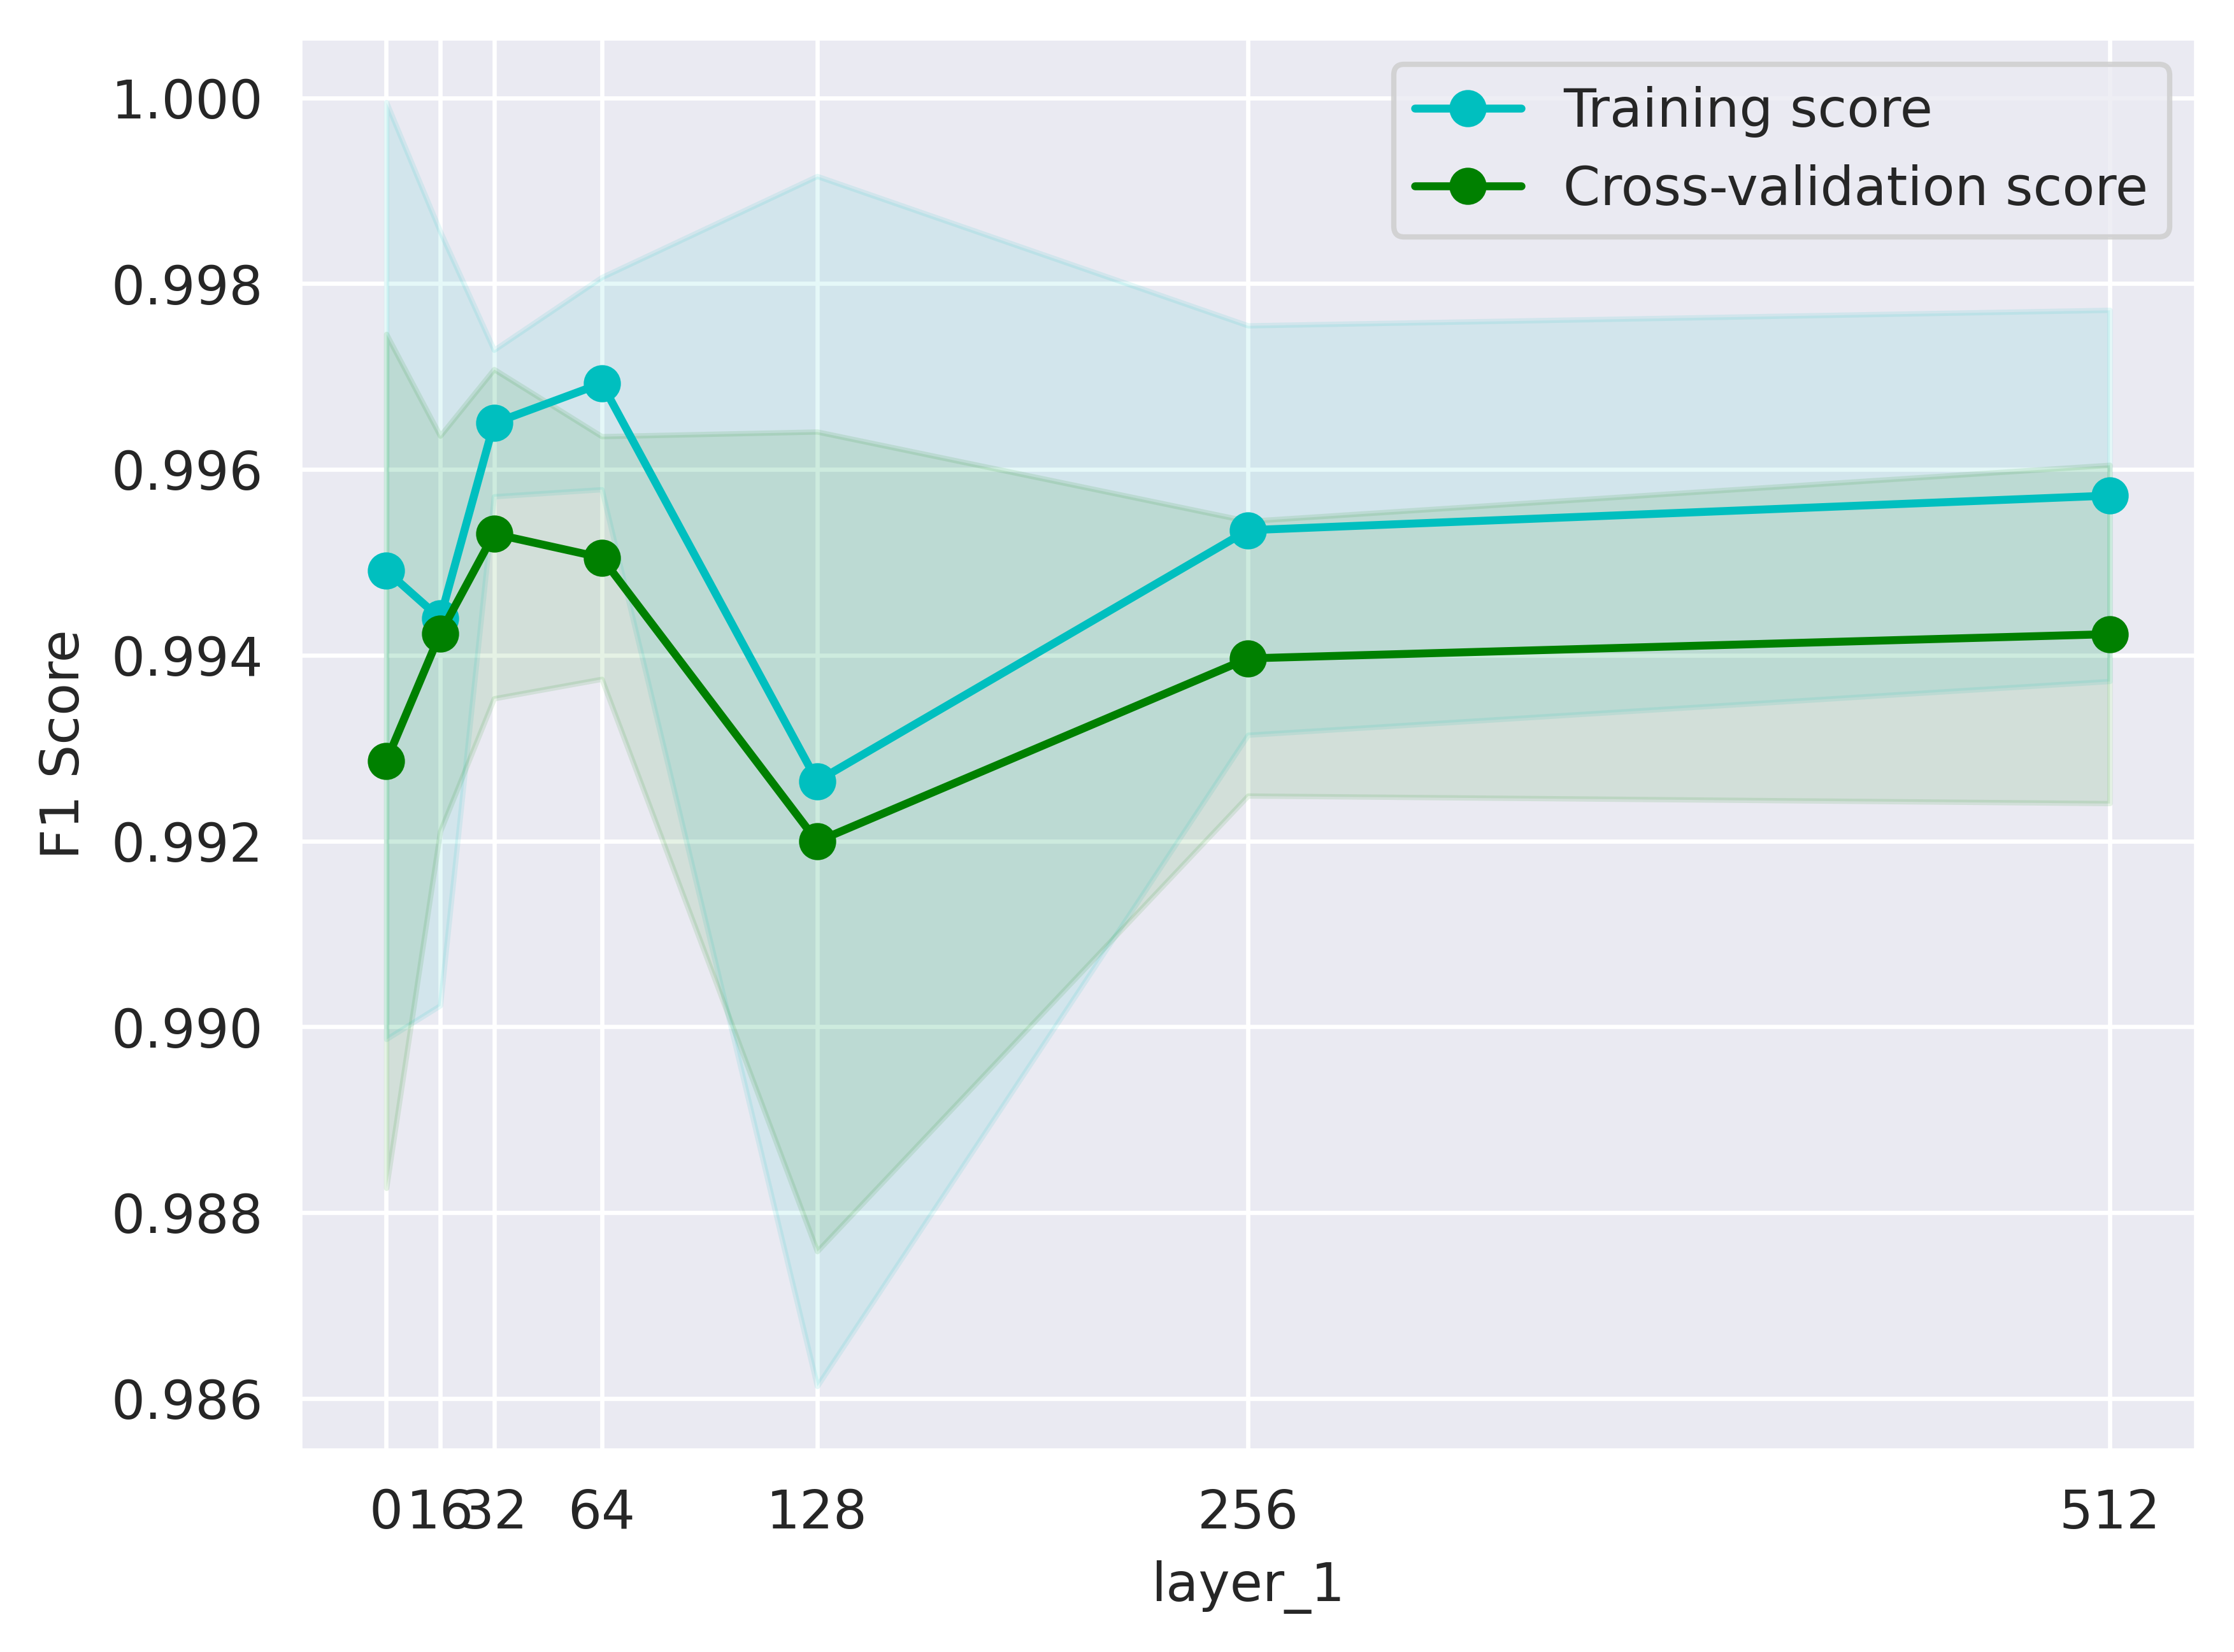

In [13]:
def param_learning_curve(X,
                         y,
                         params,
                         param_range,
                         ml_method,
                         label,
                         cv
                         ):
    """
    :param X: Dataset for training
    :param y: Ground Truth of training data
    :param params: dictionary of DNN params
    :param param_range: parameter range for dict
    :param ml_method: ml_method unique identifier
    :param label: label for X axis of visualziation
    :param patience: patience for early stopping
    :param batch_size: batch size for training
    :param epochs: Number of epoch for training
    :return:
    """
    plt.figure(dpi=600)
    score_sets_p = []

    np_train_scores = np.empty((0, sss.n_splits))
    np_test_scores = np.empty((0, sss.n_splits))

    # Get param name and values
    param_values = []
    param_name = list(param_range[0].keys())[0]
    for d in param_range:
        param_values.append(list(d.values())[0])
    param_labels = param_values

    # Check if param values have string type
    if any(isinstance(item, str) for item in param_values):
        len_param_values = len(param_values)
        param_values = list(range(0,len_param_values))

    for param in param_range:
        params.update(param)
        print(f"Starting params: {params}")
        cv_scores_train = []
        cv_scores_test = []

        fold=1
        for train_index, test_index in cv.split(X, y):
            tf.keras.backend.clear_session()
            train_data_index = train_index
            test_data_index = test_index

            train_dir, val_dir = generate_images(images, train_data_index,test_data_index, labels=nice_y)

            datagen_val = tf.keras.preprocessing.image.ImageDataGenerator()
            train_generator_val = datagen_val.flow_from_directory(
                train_dir,
                color_mode='grayscale',
                shuffle=False,
                target_size=IMAGE_SHAPE,
                batch_size = 32,
                class_mode = 'categorical'
            )

            valid_generator_val = datagen_val.flow_from_directory(
                val_dir,
                color_mode='grayscale',
                shuffle=False,
                target_size=IMAGE_SHAPE,
                batch_size = 32,
                class_mode = 'categorical'
            )
            optimizer = params.pop('optimizer', tf.keras.optimizers.Adam(lr=0.0001))
            # optimizer = params.pop('optimizer', None)
            print(f"Optimizer is set to: {optimizer}")

            model_clf = build_model_v2(**params)
            model_clf.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
            params.update({"optimizer": optimizer})
            history = model_clf.fit(train_generator_val,
                steps_per_epoch=train_generator_val.samples // BATCH_SIZE,
                epochs=1000,
                validation_data=valid_generator_val,
                validation_steps= valid_generator_val.samples // BATCH_SIZE,
                verbose=1,
                callbacks=[es_callback, reduce_lr_callback]
                )

            # Score train set
            train_generator_val.reset()
            y_pred_train = model_clf.predict(
                train_generator_val,
                # steps=train_generator.samples // BATCH_SIZE
            )
            y_test_train = train_generator_val.classes
            y_pred_train=np.argmax(y_pred_train,axis=1)
            f1_weighted_score_train=f1_score(y_test_train, y_pred_train, average='weighted')

            # Score test set
            valid_generator_val.reset()
            y_pred_test = model_clf.predict(
                valid_generator_val,
                # steps=train_generator.samples // BATCH_SIZE
            )
            y_test_test = valid_generator_val.classes
            y_pred_test=np.argmax(y_pred_test,axis=1)
            f1_weighted_score_test=f1_score(y_test_test, y_pred_test, average='weighted')

            cv_scores_test.append(f1_weighted_score_test)
            cv_scores_train.append(f1_weighted_score_train)

            # Save history
            df_history = pd.DataFrame(history.history)
            history_name = "{}_{}_history_{}_Fold{}_learningcurve.csv".format(ml_method, param, label, fold)
            df_history.to_csv(os.path.join(model_dir, history_name), index=False)
            train_generator_val.reset()
            train_generator_val.reset()
            fold+=1
        np_train_scores = np.append(np_train_scores,[cv_scores_train], axis=0)
        np_test_scores = np.append(np_test_scores,[cv_scores_test], axis=0)

    # Compute for fill_between plot
    np_train_scores_mean = np.mean(np_train_scores, axis=1)
    np_train_scores_std = np.std(np_train_scores, axis=1)
    np_test_scores_mean = np.mean(np_test_scores, axis=1)
    np_test_scores_std = np.std(np_test_scores, axis=1)


   # Plot
    plt.grid()
    plt.fill_between(param_values, np_train_scores_mean - np_train_scores_std,
                 np_train_scores_mean + np_train_scores_std, alpha=0.1,
                 color="c")
    plt.fill_between(param_values, np_test_scores_mean - np_test_scores_std,
                 np_test_scores_mean + np_test_scores_std, alpha=0.1, color="g")
    plt.plot(param_values, np_train_scores_mean, 'o-', color="c",
         label="Training score")
    plt.plot(param_values, np_test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

    # Labels and legends
    plt.xticks(ticks=param_values, labels=param_labels)
    plt.ylabel("F1 Score")
    plt.xlabel(param_name)
    # plt.legend(loc='upper right')
    plt.legend(loc="best")
    plt.savefig(os.path.join(model_dir, f"{ml_method}_{label}_learningcurve.png"))
    plt.grid()
    plt.show()

params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"layer_1": 0},
    {"layer_1": 16},
    {"layer_1": 32},
    {"layer_1": 64},
    {"layer_1": 128},
    {"layer_1": 256},
    {"layer_1": 512},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Layer_1", cv=sss_validation_curve)

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 0, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.6610 - accuracy: 0.8954 - val_loss: 0.1098 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1320 - accuracy: 0.9629 - val_loss: 0.1188 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1167 - accuracy: 0.9648 - val_loss: 0.1911 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2133 - accuracy: 0.9541 - val_loss: 0.1543 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1377 - accuracy: 0.9661 - val_loss: 0.0784 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1102 - accuracy: 0.9648 - val_loss: 0.0708 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.4742 - accuracy: 0.9026 - val_loss: 0.1626 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1587 - accuracy: 0.9554 - val_loss: 0.1926 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1722 - accuracy: 0.9592 - val_loss: 0.0883 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1226 - accuracy: 0.9496 - val_loss: 0.0562 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0820 - accuracy: 0.9741 - val_loss: 0.0422 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1021 - accuracy: 0.9656 - val_loss: 0.0786 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6459 - accuracy: 0.8943 - val_loss: 0.1360 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1216 - accuracy: 0.9554 - val_loss: 0.1030 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1735 - accuracy: 0.9576 - val_loss: 0.0926 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1046 - accuracy: 0.9682 - val_loss: 0.0540 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1932 - accuracy: 0.9512 - val_loss: 0.0969 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9757 - val_loss: 0.0557 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 1.3412 - accuracy: 0.8981 - val_loss: 0.1905 - val_accuracy: 0.9456 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1965 - accuracy: 0.9538 - val_loss: 0.4719 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3520 - accuracy: 0.9277 - val_loss: 0.0925 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1186 - accuracy: 0.9618 - val_loss: 0.0953 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0884 - accuracy: 0.9704 - val_loss: 0.0824 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0705 - accuracy: 0.9795 - val_loss: 0.0441 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7182 - accuracy: 0.8869 - val_loss: 0.6631 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2738 - accuracy: 0.9464 - val_loss: 0.0980 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1207 - accuracy: 0.9592 - val_loss: 0.0949 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0900 - accuracy: 0.9664 - val_loss: 0.0757 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0805 - accuracy: 0.9709 - val_loss: 0.0658 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0854 - accuracy: 0.9720 - val_loss: 0.0911 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7023 - accuracy: 0.8495 - val_loss: 0.1852 - val_accuracy: 0.9131 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2429 - accuracy: 0.9253 - val_loss: 0.1118 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1341 - accuracy: 0.9509 - val_loss: 0.0890 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1246 - accuracy: 0.9512 - val_loss: 0.0896 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1033 - accuracy: 0.9618 - val_loss: 0.0771 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0955 - accuracy: 0.9701 - val_loss: 0.0775 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8540 - accuracy: 0.8338 - val_loss: 0.1727 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.3066 - accuracy: 0.9029 - val_loss: 0.2113 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1973 - accuracy: 0.9442 - val_loss: 0.1399 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1132 - accuracy: 0.9602 - val_loss: 0.1070 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1704 - accuracy: 0.9602 - val_loss: 0.0892 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1301 - accuracy: 0.9685 - val_loss: 0.0758 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5742 - accuracy: 0.8671 - val_loss: 0.2023 - val_accuracy: 0.9469 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2090 - accuracy: 0.9280 - val_loss: 0.1794 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2230 - accuracy: 0.9349 - val_loss: 0.0982 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1275 - accuracy: 0.9456 - val_loss: 0.0992 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1126 - accuracy: 0.9650 - val_loss: 0.0784 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1002 - accuracy: 0.9648 - val_loss: 0.0812 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9930 - accuracy: 0.8863 - val_loss: 0.2235 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2760 - accuracy: 0.9117 - val_loss: 0.2500 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2476 - accuracy: 0.9357 - val_loss: 0.1787 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1744 - accuracy: 0.9490 - val_loss: 0.1469 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1596 - accuracy: 0.9405 - val_loss: 0.1252 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1699 - accuracy: 0.9448 - val_loss: 0.1619 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.8583 - accuracy: 0.8834 - val_loss: 0.1408 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1871 - accuracy: 0.9370 - val_loss: 0.1112 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2043 - accuracy: 0.9605 - val_loss: 0.0981 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1301 - accuracy: 0.9616 - val_loss: 0.0800 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1213 - accuracy: 0.9642 - val_loss: 0.0832 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1178 - accuracy: 0.9642 - val_loss: 0.0763 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6564 - accuracy: 0.8647 - val_loss: 0.1634 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1807 - accuracy: 0.9493 - val_loss: 0.1311 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1177 - accuracy: 0.9632 - val_loss: 0.0941 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0862 - accuracy: 0.9691 - val_loss: 0.0856 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0797 - accuracy: 0.9656 - val_loss: 0.0763 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0991 - accuracy: 0.9661 - val_loss: 0.1616 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.3226 - accuracy: 0.9133 - val_loss: 0.1894 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1587 - accuracy: 0.9536 - val_loss: 0.0811 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1040 - accuracy: 0.9656 - val_loss: 0.0855 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0885 - accuracy: 0.9682 - val_loss: 0.0632 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0785 - accuracy: 0.9755 - val_loss: 0.1211 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1725 - accuracy: 0.9672 - val_loss: 0.1421 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.3551 - accuracy: 0.9114 - val_loss: 0.1398 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1708 - accuracy: 0.9458 - val_loss: 0.0914 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1220 - accuracy: 0.9594 - val_loss: 0.0756 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0977 - accuracy: 0.9674 - val_loss: 0.0583 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1038 - accuracy: 0.9725 - val_loss: 0.0675 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0804 - accuracy: 0.9688 - val_loss: 0.0586 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.5762 - accuracy: 0.8938 - val_loss: 0.1748 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1237 - accuracy: 0.9600 - val_loss: 0.0800 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0913 - accuracy: 0.9666 - val_loss: 0.0809 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0909 - accuracy: 0.9680 - val_loss: 0.0767 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1566 - accuracy: 0.9560 - val_loss: 0.2003 - val_accuracy: 0.9419 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1174 - accuracy: 0.9581 - val_loss: 0.0759 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6577 - accuracy: 0.8906 - val_loss: 0.2920 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.4216 - accuracy: 0.8930 - val_loss: 0.1814 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1511 - accuracy: 0.9618 - val_loss: 0.0808 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1043 - accuracy: 0.9664 - val_loss: 0.0746 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1838 - accuracy: 0.9642 - val_loss: 0.1542 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2139 - accuracy: 0.9525 - val_loss: 0.1832 - val_accuracy: 0.9362 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7458 - accuracy: 0.8770 - val_loss: 0.2296 - val_accuracy: 0.9287 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2229 - accuracy: 0.9437 - val_loss: 0.0870 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1006 - accuracy: 0.9752 - val_loss: 0.0975 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0942 - accuracy: 0.9589 - val_loss: 0.0705 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0729 - accuracy: 0.9773 - val_loss: 0.1146 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0813 - accuracy: 0.9669 - val_loss: 0.0630 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6209 - accuracy: 0.9101 - val_loss: 0.1526 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2125 - accuracy: 0.9386 - val_loss: 0.0768 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1055 - accuracy: 0.9656 - val_loss: 0.0694 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0931 - accuracy: 0.9661 - val_loss: 0.1494 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0916 - accuracy: 0.9712 - val_loss: 0.0841 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0927 - accuracy: 0.9709 - val_loss: 0.3297 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.5922 - accuracy: 0.8791 - val_loss: 0.1712 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2203 - accuracy: 0.9245 - val_loss: 0.5637 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1786 - accuracy: 0.9549 - val_loss: 0.1071 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1282 - accuracy: 0.9624 - val_loss: 0.0649 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0839 - accuracy: 0.9685 - val_loss: 0.0721 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1214 - accuracy: 0.9674 - val_loss: 0.0816 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5191 - accuracy: 0.8999 - val_loss: 0.1182 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2079 - accuracy: 0.9384 - val_loss: 0.1822 - val_accuracy: 0.9156 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2708 - accuracy: 0.9250 - val_loss: 0.0939 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1131 - accuracy: 0.9669 - val_loss: 0.0952 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0939 - accuracy: 0.9731 - val_loss: 0.0920 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 6ms/step - loss: 0.1186 - accuracy: 0.9573 - val_loss: 0.1008 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5979 - accuracy: 0.8927 - val_loss: 0.1524 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1261 - accuracy: 0.9642 - val_loss: 0.1267 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1171 - accuracy: 0.9637 - val_loss: 0.0753 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1531 - accuracy: 0.9592 - val_loss: 0.1052 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1064 - accuracy: 0.9629 - val_loss: 0.0733 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1184 - accuracy: 0.9621 - val_loss: 0.0780 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.4838 - accuracy: 0.8311 - val_loss: 0.2480 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1869 - accuracy: 0.9253 - val_loss: 0.1521 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2278 - accuracy: 0.9437 - val_loss: 0.0916 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1258 - accuracy: 0.9570 - val_loss: 0.0878 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0945 - accuracy: 0.9597 - val_loss: 0.1983 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1121 - accuracy: 0.9578 - val_loss: 0.0674 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.7500 - accuracy: 0.8789 - val_loss: 0.1513 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1375 - accuracy: 0.9514 - val_loss: 0.0832 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1004 - accuracy: 0.9731 - val_loss: 0.1089 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1130 - accuracy: 0.9656 - val_loss: 0.0684 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0862 - accuracy: 0.9691 - val_loss: 0.0636 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0865 - accuracy: 0.9725 - val_loss: 0.0653 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5765 - accuracy: 0.8906 - val_loss: 0.1703 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.3081 - accuracy: 0.9450 - val_loss: 0.1446 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2593 - accuracy: 0.9496 - val_loss: 0.0782 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1141 - accuracy: 0.9573 - val_loss: 0.0639 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0834 - accuracy: 0.9728 - val_loss: 0.0518 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0763 - accuracy: 0.9709 - val_loss: 0.0550 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.7132 - accuracy: 0.8874 - val_loss: 0.1254 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1464 - accuracy: 0.9477 - val_loss: 0.0757 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0980 - accuracy: 0.9666 - val_loss: 0.0818 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1119 - accuracy: 0.9544 - val_loss: 0.0736 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0950 - accuracy: 0.9688 - val_loss: 0.0810 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0898 - accuracy: 0.9712 - val_loss: 0.1122 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.8144 - accuracy: 0.8930 - val_loss: 0.1615 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1302 - accuracy: 0.9578 - val_loss: 0.0935 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1070 - accuracy: 0.9602 - val_loss: 0.0792 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0873 - accuracy: 0.9707 - val_loss: 0.1104 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1911 - accuracy: 0.9541 - val_loss: 0.0856 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1319 - accuracy: 0.9701 - val_loss: 0.1180 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8326 - accuracy: 0.9082 - val_loss: 0.1106 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1844 - accuracy: 0.9335 - val_loss: 0.0981 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1301 - accuracy: 0.9541 - val_loss: 0.1220 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1017 - accuracy: 0.9584 - val_loss: 0.0700 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0972 - accuracy: 0.9560 - val_loss: 0.1300 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2277 - accuracy: 0.9413 - val_loss: 0.1022 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.0092 - accuracy: 0.8893 - val_loss: 0.6397 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2425 - accuracy: 0.9573 - val_loss: 0.1743 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1807 - accuracy: 0.9589 - val_loss: 0.0877 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1125 - accuracy: 0.9578 - val_loss: 0.0948 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0958 - accuracy: 0.9637 - val_loss: 0.0589 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0774 - accuracy: 0.9712 - val_loss: 0.0477 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8006 - accuracy: 0.9074 - val_loss: 0.1869 - val_accuracy: 0.9106 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1619 - accuracy: 0.9365 - val_loss: 0.0833 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9624 - val_loss: 0.0858 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1048 - accuracy: 0.9653 - val_loss: 0.1066 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1100 - accuracy: 0.9650 - val_loss: 0.0709 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1096 - accuracy: 0.9736 - val_loss: 0.1150 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5953 - accuracy: 0.8863 - val_loss: 0.1369 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.9562 - val_loss: 0.0757 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0979 - accuracy: 0.9664 - val_loss: 0.0726 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0802 - accuracy: 0.9685 - val_loss: 0.0649 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1470 - accuracy: 0.9610 - val_loss: 0.0919 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1513 - accuracy: 0.9520 - val_loss: 0.0745 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1008 - accuracy: 0.8738 - val_loss: 0.1603 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2608 - accuracy: 0.9501 - val_loss: 0.1039 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0823 - accuracy: 0.9749 - val_loss: 0.2557 - val_accuracy: 0.9212 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1419 - accuracy: 0.9594 - val_loss: 0.0794 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0783 - accuracy: 0.9712 - val_loss: 0.0754 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0799 - accuracy: 0.9757 - val_loss: 0.0903 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6165 - accuracy: 0.9117 - val_loss: 0.3129 - val_accuracy: 0.9069 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2675 - accuracy: 0.9298 - val_loss: 0.1124 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0988 - accuracy: 0.9640 - val_loss: 0.1036 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1144 - accuracy: 0.9632 - val_loss: 0.2851 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3360 - accuracy: 0.9522 - val_loss: 0.3530 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2107 - accuracy: 0.9477 - val_loss: 0.0731 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 1.2628 - accuracy: 0.8914 - val_loss: 0.1090 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1535 - accuracy: 0.9477 - val_loss: 0.1335 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1915 - accuracy: 0.9442 - val_loss: 0.2404 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1193 - accuracy: 0.9696 - val_loss: 0.1191 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 0.9528 - val_loss: 0.2897 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0999 - accuracy: 0.9685 - val_loss: 0.0558 - val_accuracy: 0.9950 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 5ms/step - loss: 0.9941 - accuracy: 0.8925 - val_loss: 0.1392 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1573 - accuracy: 0.9528 - val_loss: 0.1511 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1609 - accuracy: 0.9525 - val_loss: 0.0864 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1338 - accuracy: 0.9576 - val_loss: 0.0956 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0850 - accuracy: 0.9629 - val_loss: 0.0716 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1155 - accuracy: 0.9624 - val_loss: 0.0722 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8721 - accuracy: 0.8610 - val_loss: 0.2295 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2474 - accuracy: 0.9373 - val_loss: 0.2918 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2171 - accuracy: 0.9512 - val_loss: 0.2173 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1484 - accuracy: 0.9618 - val_loss: 0.0892 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0914 - accuracy: 0.9672 - val_loss: 0.0648 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0701 - accuracy: 0.9696 - val_loss: 0.0586 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.3961 - accuracy: 0.9026 - val_loss: 0.1806 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2120 - accuracy: 0.9490 - val_loss: 0.1322 - val_accuracy: 0.9481 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1624 - accuracy: 0.9597 - val_loss: 0.3027 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3109 - accuracy: 0.9346 - val_loss: 0.0769 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1327 - accuracy: 0.9562 - val_loss: 0.0745 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0853 - accuracy: 0.9664 - val_loss: 0.0641 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

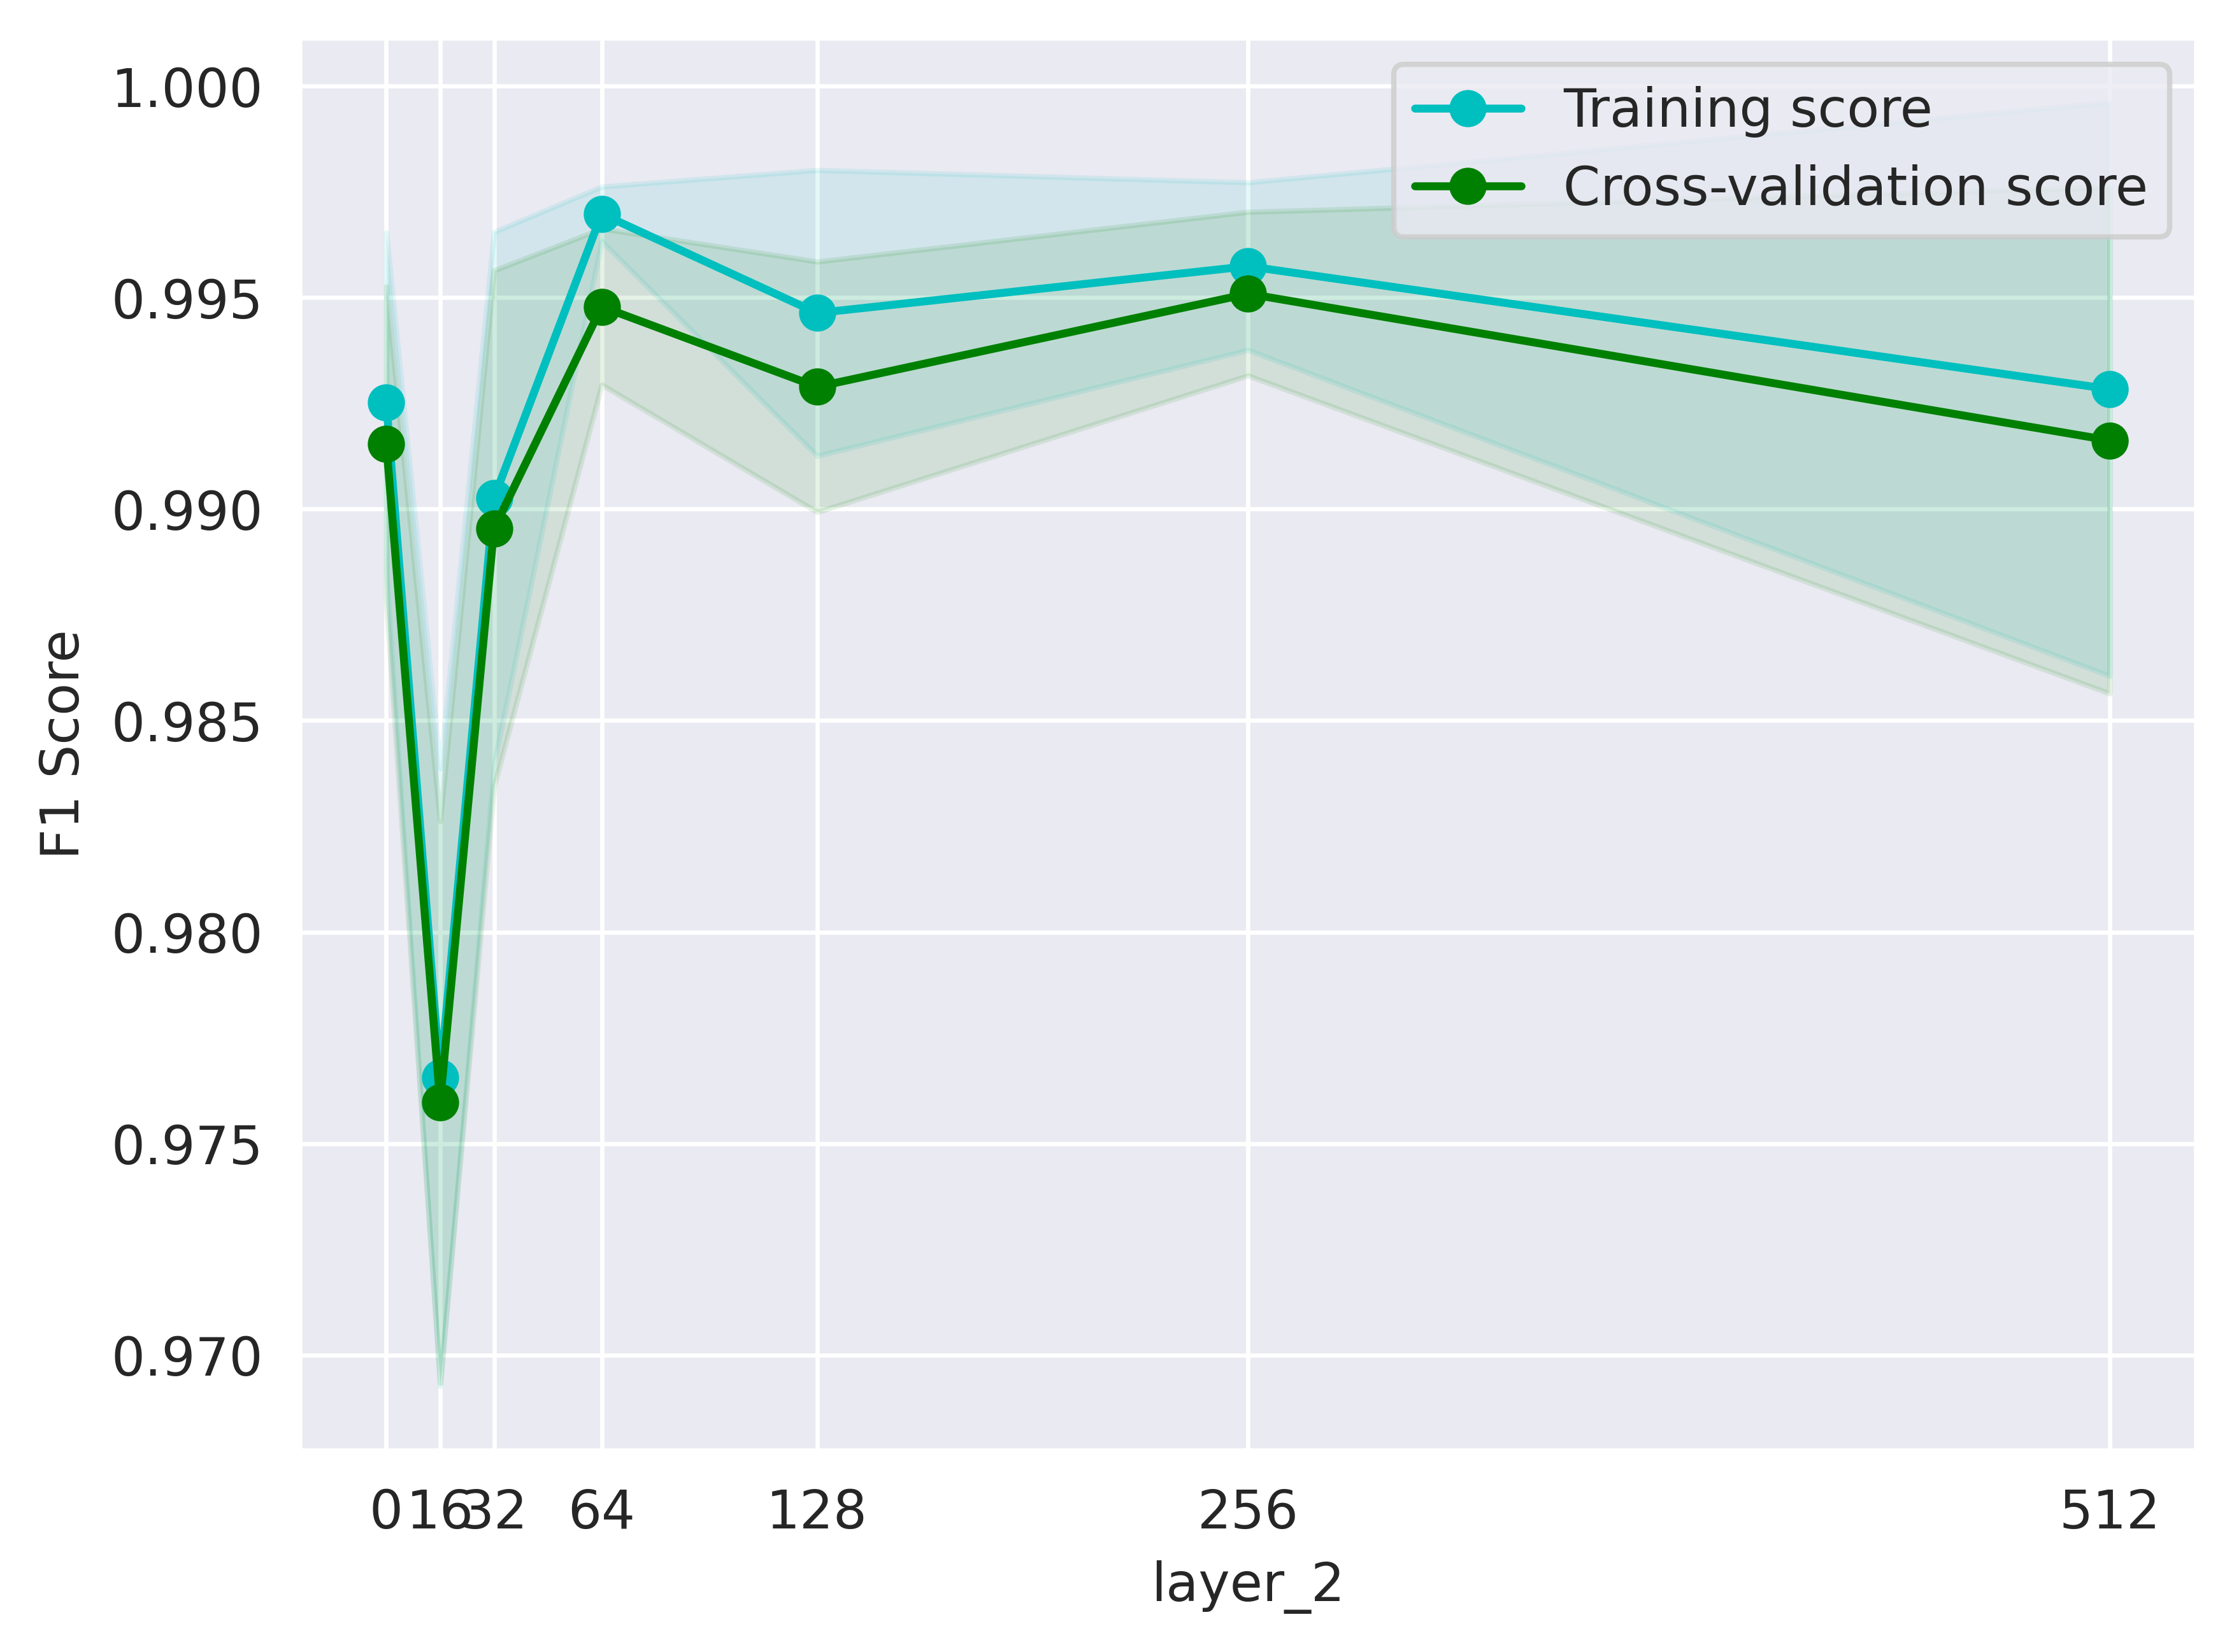

In [14]:
params = {
        "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"layer_2": 0},
    {"layer_2": 16},
    {"layer_2": 32},
    {"layer_2": 64},
    {"layer_2": 128},
    {"layer_2": 256},
    {"layer_2": 512},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Layer_2", cv=sss_validation_curve)

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 0, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.9900 - accuracy: 0.9045 - val_loss: 0.1246 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2341 - accuracy: 0.9565 - val_loss: 0.0863 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0959 - accuracy: 0.9629 - val_loss: 0.0776 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0840 - accuracy: 0.9699 - val_loss: 0.0770 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0892 - accuracy: 0.9699 - val_loss: 0.0713 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1292 - accuracy: 0.9602 - val_loss: 0.0785 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 1.1226 - accuracy: 0.8973 - val_loss: 0.1188 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1279 - accuracy: 0.9514 - val_loss: 0.0575 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0970 - accuracy: 0.9680 - val_loss: 0.0561 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0901 - accuracy: 0.9731 - val_loss: 0.0533 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0754 - accuracy: 0.9768 - val_loss: 0.0803 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0966 - accuracy: 0.9680 - val_loss: 0.0662 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8972 - accuracy: 0.9010 - val_loss: 0.2192 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2730 - accuracy: 0.9605 - val_loss: 0.1232 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1261 - accuracy: 0.9586 - val_loss: 0.0845 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1072 - accuracy: 0.9632 - val_loss: 0.0749 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0878 - accuracy: 0.9688 - val_loss: 0.0451 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0629 - accuracy: 0.9760 - val_loss: 0.0305 - val_accuracy: 0.9962 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 1.4229 - accuracy: 0.9042 - val_loss: 0.1047 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0879 - accuracy: 0.9755 - val_loss: 0.1357 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1388 - accuracy: 0.9677 - val_loss: 0.0818 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1124 - accuracy: 0.9661 - val_loss: 0.0813 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1042 - accuracy: 0.9672 - val_loss: 0.1327 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0896 - accuracy: 0.9717 - val_loss: 0.0816 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 1.2507 - accuracy: 0.8914 - val_loss: 0.1366 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1650 - accuracy: 0.9653 - val_loss: 0.0981 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1038 - accuracy: 0.9578 - val_loss: 0.0772 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0891 - accuracy: 0.9674 - val_loss: 0.0990 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1039 - accuracy: 0.9642 - val_loss: 0.2726 - val_accuracy: 0.9175 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2449 - accuracy: 0.9456 - val_loss: 0.0794 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7561 - accuracy: 0.8869 - val_loss: 0.1715 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3506 - accuracy: 0.9488 - val_loss: 0.1009 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1296 - accuracy: 0.9629 - val_loss: 0.0855 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1104 - accuracy: 0.9605 - val_loss: 0.0749 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0894 - accuracy: 0.9626 - val_loss: 0.0974 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0944 - accuracy: 0.9602 - val_loss: 0.0856 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7436 - accuracy: 0.8730 - val_loss: 0.1310 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1492 - accuracy: 0.9506 - val_loss: 0.0751 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1012 - accuracy: 0.9624 - val_loss: 0.0752 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1075 - accuracy: 0.9674 - val_loss: 0.0695 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1368 - accuracy: 0.9541 - val_loss: 0.2674 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.5106 - accuracy: 0.9136 - val_loss: 0.1503 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6390 - accuracy: 0.9109 - val_loss: 0.1314 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2299 - accuracy: 0.9458 - val_loss: 0.0897 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1098 - accuracy: 0.9666 - val_loss: 0.0766 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0760 - accuracy: 0.9749 - val_loss: 0.0619 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0849 - accuracy: 0.9653 - val_loss: 0.0670 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0713 - accuracy: 0.9666 - val_loss: 0.0841 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6979 - accuracy: 0.9042 - val_loss: 0.1560 - val_accuracy: 0.9256 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1594 - accuracy: 0.9522 - val_loss: 0.0931 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0922 - accuracy: 0.9642 - val_loss: 0.0780 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1229 - accuracy: 0.9626 - val_loss: 0.0792 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2195 - accuracy: 0.9440 - val_loss: 0.0982 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1028 - accuracy: 0.9613 - val_loss: 0.0692 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.4629 - accuracy: 0.8981 - val_loss: 0.3172 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1748 - accuracy: 0.9576 - val_loss: 0.1032 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1050 - accuracy: 0.9640 - val_loss: 0.1440 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1284 - accuracy: 0.9645 - val_loss: 0.1300 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1837 - accuracy: 0.9653 - val_loss: 0.2193 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2127 - accuracy: 0.9434 - val_loss: 0.0939 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5605 - accuracy: 0.9104 - val_loss: 0.1877 - val_accuracy: 0.9356 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1358 - accuracy: 0.9562 - val_loss: 0.1150 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1382 - accuracy: 0.9565 - val_loss: 0.1014 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1017 - accuracy: 0.9621 - val_loss: 0.0853 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0722 - accuracy: 0.9747 - val_loss: 0.0643 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0791 - accuracy: 0.9720 - val_loss: 0.0623 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7548 - accuracy: 0.8863 - val_loss: 0.1265 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1834 - accuracy: 0.9525 - val_loss: 0.1614 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2186 - accuracy: 0.9376 - val_loss: 0.0996 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1177 - accuracy: 0.9600 - val_loss: 0.1079 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0971 - accuracy: 0.9661 - val_loss: 0.0728 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0961 - accuracy: 0.9629 - val_loss: 0.0597 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9994 - accuracy: 0.8887 - val_loss: 0.1356 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2043 - accuracy: 0.9528 - val_loss: 0.0890 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1198 - accuracy: 0.9589 - val_loss: 0.0624 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0884 - accuracy: 0.9669 - val_loss: 0.0554 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0720 - accuracy: 0.9771 - val_loss: 0.0546 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1600 - accuracy: 0.9538 - val_loss: 0.0738 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6600 - accuracy: 0.8858 - val_loss: 0.1842 - val_accuracy: 0.9044 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1450 - accuracy: 0.9490 - val_loss: 0.1119 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1168 - accuracy: 0.9549 - val_loss: 0.0861 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0900 - accuracy: 0.9688 - val_loss: 0.0670 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1447 - accuracy: 0.9472 - val_loss: 0.1134 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0915 - accuracy: 0.9669 - val_loss: 0.0612 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6374 - accuracy: 0.8893 - val_loss: 0.1308 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2320 - accuracy: 0.9325 - val_loss: 0.0941 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1172 - accuracy: 0.9570 - val_loss: 0.0861 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1393 - accuracy: 0.9627 - val_loss: 0.0946 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0957 - accuracy: 0.9624 - val_loss: 0.0751 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0911 - accuracy: 0.9656 - val_loss: 0.0714 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4913 - accuracy: 0.8981 - val_loss: 0.1550 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2995 - accuracy: 0.9464 - val_loss: 0.5801 - val_accuracy: 0.8550 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1762 - accuracy: 0.9482 - val_loss: 0.1162 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1171 - accuracy: 0.9629 - val_loss: 0.0633 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0808 - accuracy: 0.9674 - val_loss: 0.1316 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0880 - accuracy: 0.9691 - val_loss: 0.0653 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6164 - accuracy: 0.9045 - val_loss: 0.1308 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1677 - accuracy: 0.9397 - val_loss: 0.0913 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1420 - accuracy: 0.9480 - val_loss: 0.0835 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1315 - accuracy: 0.9648 - val_loss: 0.1294 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0958 - accuracy: 0.9629 - val_loss: 0.0605 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1109 - accuracy: 0.9640 - val_loss: 0.0784 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5164 - accuracy: 0.8922 - val_loss: 0.1092 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1118 - accuracy: 0.9597 - val_loss: 0.0872 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1249 - accuracy: 0.9592 - val_loss: 0.0745 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0959 - accuracy: 0.9685 - val_loss: 0.0848 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0880 - accuracy: 0.9650 - val_loss: 0.0624 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1275 - accuracy: 0.9624 - val_loss: 0.1133 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.4632 - accuracy: 0.8986 - val_loss: 0.1144 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1468 - accuracy: 0.9584 - val_loss: 0.0809 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0899 - accuracy: 0.9680 - val_loss: 0.0701 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0677 - accuracy: 0.9776 - val_loss: 0.0509 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0719 - accuracy: 0.9811 - val_loss: 0.0441 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1211 - accuracy: 0.9618 - val_loss: 0.0707 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.5723 - accuracy: 0.8946 - val_loss: 0.1635 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1775 - accuracy: 0.9456 - val_loss: 0.1596 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1866 - accuracy: 0.9602 - val_loss: 0.1168 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 0.9629 - val_loss: 0.0883 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0945 - accuracy: 0.9616 - val_loss: 0.0992 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1265 - accuracy: 0.9525 - val_loss: 0.1773 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6559 - accuracy: 0.9074 - val_loss: 0.1267 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1830 - accuracy: 0.9573 - val_loss: 0.1074 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1295 - accuracy: 0.9613 - val_loss: 0.1199 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1000 - accuracy: 0.9653 - val_loss: 0.1034 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1013 - accuracy: 0.9669 - val_loss: 0.0885 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0837 - accuracy: 0.9650 - val_loss: 0.0790 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5608 - accuracy: 0.9088 - val_loss: 0.1699 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 0.9538 - val_loss: 0.1721 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1434 - accuracy: 0.9485 - val_loss: 0.1695 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1569 - accuracy: 0.9589 - val_loss: 0.1366 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1109 - accuracy: 0.9650 - val_loss: 0.1167 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1303 - accuracy: 0.9562 - val_loss: 0.0603 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.2062 - accuracy: 0.8794 - val_loss: 0.6620 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1486 - accuracy: 0.9605 - val_loss: 0.0976 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1154 - accuracy: 0.9688 - val_loss: 0.1176 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1085 - accuracy: 0.9642 - val_loss: 0.2715 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1007 - accuracy: 0.9672 - val_loss: 0.0662 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9755 - val_loss: 0.0947 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6015 - accuracy: 0.9061 - val_loss: 0.2657 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1612 - accuracy: 0.9469 - val_loss: 0.6406 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2368 - accuracy: 0.9480 - val_loss: 0.1113 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1092 - accuracy: 0.9600 - val_loss: 0.0815 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0862 - accuracy: 0.9699 - val_loss: 0.0787 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0826 - accuracy: 0.9696 - val_loss: 0.0736 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4422 - accuracy: 0.9042 - val_loss: 0.1552 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2109 - accuracy: 0.9346 - val_loss: 0.1043 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1013 - accuracy: 0.9650 - val_loss: 0.0829 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0845 - accuracy: 0.9677 - val_loss: 0.0736 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0759 - accuracy: 0.9704 - val_loss: 0.0747 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0704 - accuracy: 0.9739 - val_loss: 0.0579 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6769 - accuracy: 0.8954 - val_loss: 0.1522 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2421 - accuracy: 0.9472 - val_loss: 0.0908 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1334 - accuracy: 0.9584 - val_loss: 0.1068 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1810 - accuracy: 0.9442 - val_loss: 0.3005 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1750 - accuracy: 0.9621 - val_loss: 0.0823 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0786 - accuracy: 0.9696 - val_loss: 0.0912 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.4851 - accuracy: 0.8775 - val_loss: 0.1929 - val_accuracy: 0.9225 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3757 - accuracy: 0.9405 - val_loss: 0.0992 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9653 - val_loss: 0.0576 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1095 - accuracy: 0.9621 - val_loss: 0.0761 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1022 - accuracy: 0.9704 - val_loss: 0.0544 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0638 - accuracy: 0.9768 - val_loss: 0.0377 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6670 - accuracy: 0.8869 - val_loss: 0.1094 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1283 - accuracy: 0.9613 - val_loss: 0.0658 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1193 - accuracy: 0.9629 - val_loss: 0.0697 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3706 - accuracy: 0.9392 - val_loss: 0.0872 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1326 - accuracy: 0.9629 - val_loss: 0.0587 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0885 - accuracy: 0.9728 - val_loss: 0.1143 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.6140 - accuracy: 0.8983 - val_loss: 0.1150 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1942 - accuracy: 0.9541 - val_loss: 0.0790 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0882 - accuracy: 0.9682 - val_loss: 0.0752 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0801 - accuracy: 0.9704 - val_loss: 0.0629 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1046 - accuracy: 0.9613 - val_loss: 0.0784 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1147 - accuracy: 0.9699 - val_loss: 0.0740 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6161 - accuracy: 0.9181 - val_loss: 0.1720 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1466 - accuracy: 0.9610 - val_loss: 0.1118 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0854 - accuracy: 0.9685 - val_loss: 0.0901 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0822 - accuracy: 0.9725 - val_loss: 0.0696 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 6ms/step - loss: 0.0941 - accuracy: 0.9741 - val_loss: 0.0745 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0802 - accuracy: 0.9733 - val_loss: 0.1352 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.9572 - accuracy: 0.9218 - val_loss: 0.1198 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2241 - accuracy: 0.9522 - val_loss: 0.1100 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1267 - accuracy: 0.9653 - val_loss: 0.0877 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0858 - accuracy: 0.9699 - val_loss: 0.0850 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0859 - accuracy: 0.9677 - val_loss: 0.0742 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0672 - accuracy: 0.9755 - val_loss: 0.0678 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7383 - accuracy: 0.8695 - val_loss: 0.1221 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1398 - accuracy: 0.9429 - val_loss: 0.0994 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1705 - accuracy: 0.9437 - val_loss: 0.0765 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1153 - accuracy: 0.9648 - val_loss: 0.0757 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1362 - accuracy: 0.9661 - val_loss: 0.0771 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1071 - accuracy: 0.9664 - val_loss: 0.0631 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1675 - accuracy: 0.9002 - val_loss: 0.1940 - val_accuracy: 0.9081 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1591 - accuracy: 0.9386 - val_loss: 0.0729 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1128 - accuracy: 0.9645 - val_loss: 0.0778 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1089 - accuracy: 0.9648 - val_loss: 0.0798 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1603 - accuracy: 0.9381 - val_loss: 0.0754 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0997 - accuracy: 0.9648 - val_loss: 0.0637 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.6706 - accuracy: 0.9039 - val_loss: 0.1188 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2269 - accuracy: 0.9394 - val_loss: 0.1072 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2180 - accuracy: 0.9370 - val_loss: 0.1261 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1022 - accuracy: 0.9613 - val_loss: 0.0832 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0842 - accuracy: 0.9707 - val_loss: 0.1065 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0858 - accuracy: 0.9674 - val_loss: 0.0784 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5652 - accuracy: 0.9192 - val_loss: 0.2460 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3741 - accuracy: 0.9341 - val_loss: 0.2818 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1715 - accuracy: 0.9552 - val_loss: 0.1400 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1075 - accuracy: 0.9642 - val_loss: 0.0670 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0750 - accuracy: 0.9739 - val_loss: 0.0785 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1050 - accuracy: 0.9749 - val_loss: 0.1502 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

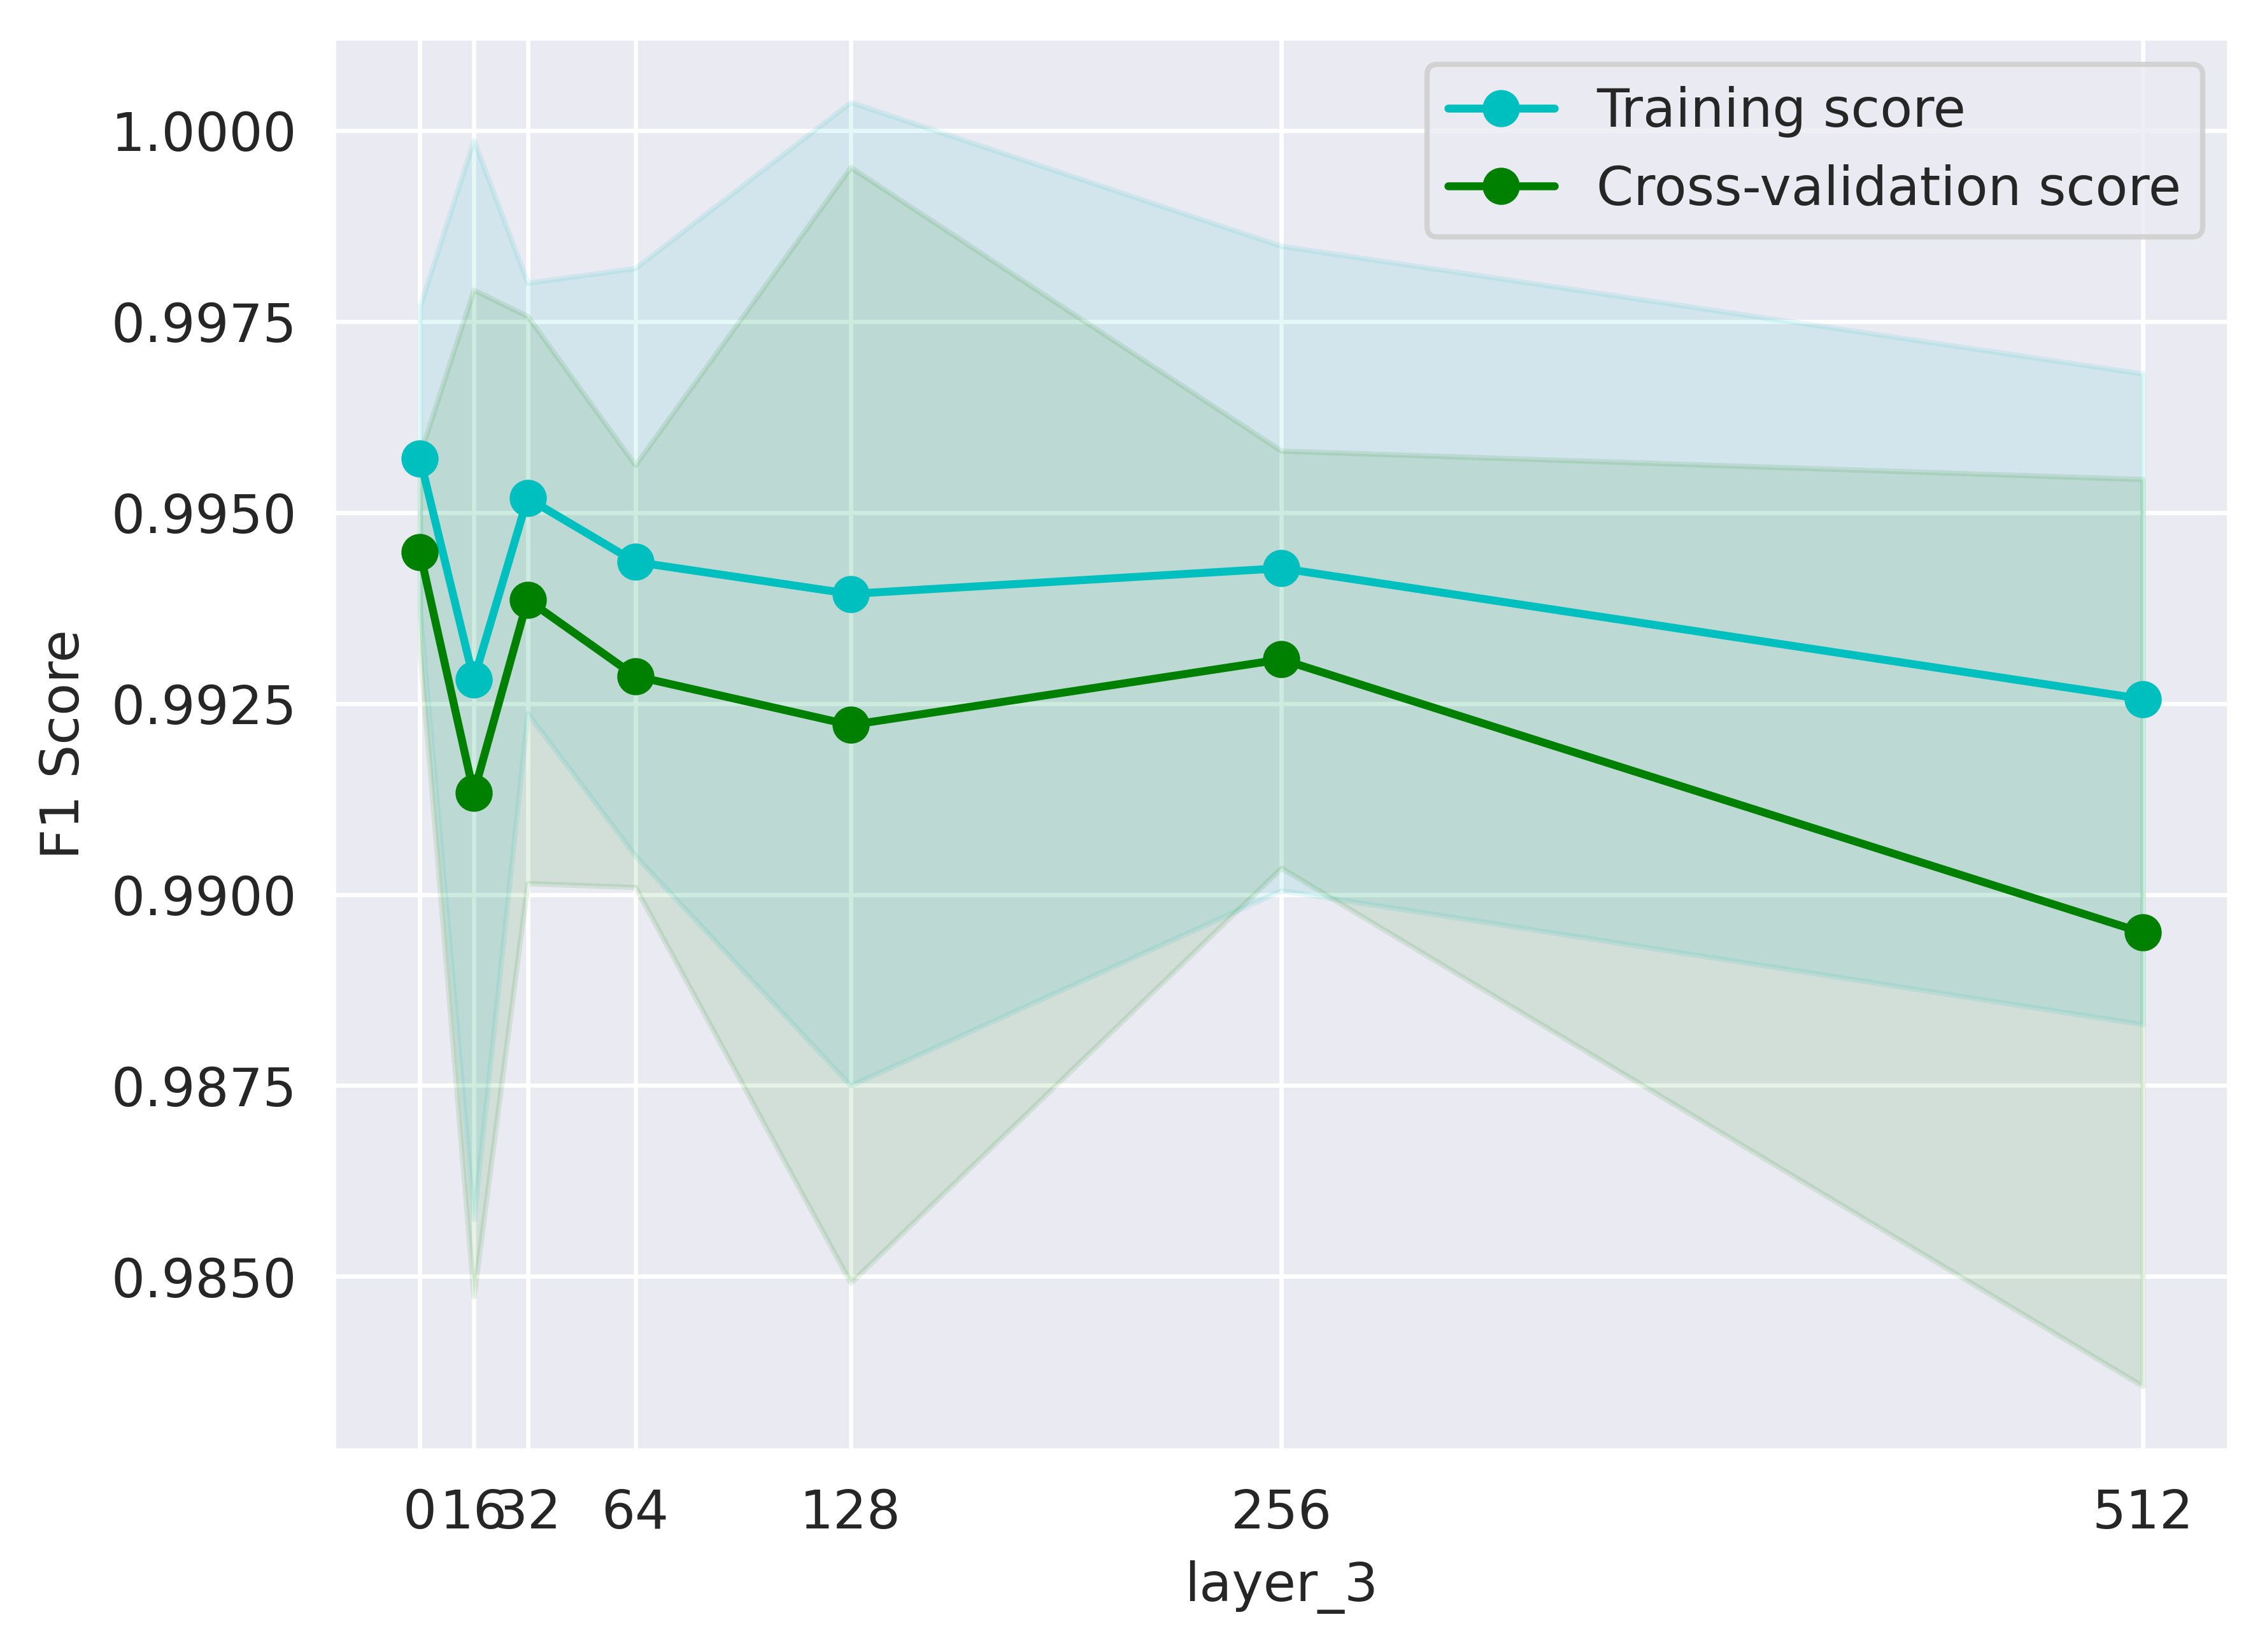

In [15]:
params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"layer_3": 0},
    {"layer_3": 16},
    {"layer_3": 32},
    {"layer_3": 64},
    {"layer_3": 128},
    {"layer_3": 256},
    {"layer_3": 512},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Layer_3", cv=sss_validation_curve)

In [ ]:
params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"drop_1": 0.0},
    {"drop_1": 0.2},
    {"drop_1": 0.5},
    {"drop_1": 0.7},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Drop_1", cv=sss_validation_curve)

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.9631 - accuracy: 0.8559 - val_loss: 0.1450 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1367 - accuracy: 0.9521 - val_loss: 0.1123 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1186 - accuracy: 0.9624 - val_loss: 0.0763 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0897 - accuracy: 0.9666 - val_loss: 0.0880 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1007 - accuracy: 0.9699 - val_loss: 0.0899 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1250 - accuracy: 0.9637 - val_loss: 0.0852 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.2885 - accuracy: 0.8722 - val_loss: 0.1128 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2095 - accuracy: 0.9402 - val_loss: 0.1049 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1413 - accuracy: 0.9626 - val_loss: 0.0708 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1134 - accuracy: 0.9597 - val_loss: 0.2470 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1505 - accuracy: 0.9629 - val_loss: 0.0868 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1269 - accuracy: 0.9618 - val_loss: 0.0911 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4680 - accuracy: 0.9216 - val_loss: 0.1238 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2201 - accuracy: 0.9529 - val_loss: 0.1195 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1511 - accuracy: 0.9568 - val_loss: 0.1353 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0980 - accuracy: 0.9650 - val_loss: 0.0753 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0817 - accuracy: 0.9688 - val_loss: 0.0786 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0637 - accuracy: 0.9707 - val_loss: 0.1179 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7592 - accuracy: 0.8965 - val_loss: 0.1848 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1630 - accuracy: 0.9594 - val_loss: 0.0950 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1348 - accuracy: 0.9554 - val_loss: 0.0623 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1293 - accuracy: 0.9605 - val_loss: 0.0681 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1108 - accuracy: 0.9554 - val_loss: 0.0517 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0935 - accuracy: 0.9674 - val_loss: 0.0719 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7293 - accuracy: 0.8821 - val_loss: 0.1252 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2697 - accuracy: 0.9352 - val_loss: 0.0839 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1364 - accuracy: 0.9576 - val_loss: 0.1601 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1161 - accuracy: 0.9632 - val_loss: 0.0662 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0823 - accuracy: 0.9691 - val_loss: 0.0572 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1053 - accuracy: 0.9677 - val_loss: 0.0999 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.0407 - accuracy: 0.8978 - val_loss: 0.1673 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1897 - accuracy: 0.9506 - val_loss: 0.1249 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1365 - accuracy: 0.9610 - val_loss: 0.0758 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0913 - accuracy: 0.9693 - val_loss: 0.0696 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0689 - accuracy: 0.9747 - val_loss: 0.0669 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1111 - accuracy: 0.9650 - val_loss: 0.0778 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.7386 - accuracy: 0.8743 - val_loss: 0.1607 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1861 - accuracy: 0.9584 - val_loss: 0.0880 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1200 - accuracy: 0.9648 - val_loss: 0.1000 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1265 - accuracy: 0.9608 - val_loss: 0.0697 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0907 - accuracy: 0.9693 - val_loss: 0.0695 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1250 - accuracy: 0.9589 - val_loss: 0.0843 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.2280 - accuracy: 0.8930 - val_loss: 0.1806 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2035 - accuracy: 0.9440 - val_loss: 0.1508 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2001 - accuracy: 0.9536 - val_loss: 0.0763 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0885 - accuracy: 0.9739 - val_loss: 0.0767 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0993 - accuracy: 0.9637 - val_loss: 0.0996 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.9624 - val_loss: 0.0776 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7347 - accuracy: 0.8946 - val_loss: 0.1393 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2053 - accuracy: 0.9453 - val_loss: 0.0827 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1248 - accuracy: 0.9629 - val_loss: 0.0916 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1190 - accuracy: 0.9658 - val_loss: 0.0867 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1115 - accuracy: 0.9624 - val_loss: 0.0623 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0825 - accuracy: 0.9645 - val_loss: 0.0556 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4534 - accuracy: 0.9216 - val_loss: 0.1132 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1444 - accuracy: 0.9618 - val_loss: 0.0691 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1201 - accuracy: 0.9578 - val_loss: 0.0930 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0963 - accuracy: 0.9645 - val_loss: 0.0858 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0984 - accuracy: 0.9688 - val_loss: 0.0524 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0750 - accuracy: 0.9720 - val_loss: 0.0465 - val_accuracy: 0.9887 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6196 - accuracy: 0.8901 - val_loss: 1.4832 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2099 - accuracy: 0.9346 - val_loss: 0.0949 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1183 - accuracy: 0.9573 - val_loss: 0.1134 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0980 - accuracy: 0.9600 - val_loss: 0.0837 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0961 - accuracy: 0.9672 - val_loss: 0.0724 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0795 - accuracy: 0.9723 - val_loss: 0.0786 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1702 - accuracy: 0.8906 - val_loss: 0.1637 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1668 - accuracy: 0.9578 - val_loss: 0.0925 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1224 - accuracy: 0.9608 - val_loss: 0.0883 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1215 - accuracy: 0.9616 - val_loss: 0.0808 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0997 - accuracy: 0.9696 - val_loss: 0.1021 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0985 - accuracy: 0.9720 - val_loss: 0.0742 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9890 - accuracy: 0.8735 - val_loss: 0.1960 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2307 - accuracy: 0.9237 - val_loss: 0.1149 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1649 - accuracy: 0.9498 - val_loss: 0.0848 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1076 - accuracy: 0.9634 - val_loss: 0.0763 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1449 - accuracy: 0.9605 - val_loss: 0.0781 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1122 - accuracy: 0.9624 - val_loss: 0.0814 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5127 - accuracy: 0.8882 - val_loss: 0.1166 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1777 - accuracy: 0.9568 - val_loss: 0.0914 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1183 - accuracy: 0.9586 - val_loss: 0.0701 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0995 - accuracy: 0.9640 - val_loss: 0.0579 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0989 - accuracy: 0.9672 - val_loss: 0.0592 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1024 - accuracy: 0.9688 - val_loss: 0.1094 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.9305 - accuracy: 0.8634 - val_loss: 0.1919 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2256 - accuracy: 0.9496 - val_loss: 0.2261 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1331 - accuracy: 0.9584 - val_loss: 0.0686 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1107 - accuracy: 0.9560 - val_loss: 0.0644 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1013 - accuracy: 0.9621 - val_loss: 0.0652 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0912 - accuracy: 0.9682 - val_loss: 0.0538 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7421 - accuracy: 0.8538 - val_loss: 0.2721 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2438 - accuracy: 0.9285 - val_loss: 0.1960 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1527 - accuracy: 0.9445 - val_loss: 0.0992 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1146 - accuracy: 0.9661 - val_loss: 0.0741 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1056 - accuracy: 0.9648 - val_loss: 0.0700 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0900 - accuracy: 0.9669 - val_loss: 0.0677 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.8400 - accuracy: 0.8946 - val_loss: 0.2372 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1751 - accuracy: 0.9525 - val_loss: 0.0890 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1376 - accuracy: 0.9616 - val_loss: 0.0992 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0965 - accuracy: 0.9650 - val_loss: 0.0913 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1042 - accuracy: 0.9656 - val_loss: 0.0786 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1176 - accuracy: 0.9645 - val_loss: 0.0914 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 1.2033 - accuracy: 0.8829 - val_loss: 0.1894 - val_accuracy: 0.9200 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2757 - accuracy: 0.9229 - val_loss: 0.1497 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1420 - accuracy: 0.9554 - val_loss: 0.0861 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1197 - accuracy: 0.9618 - val_loss: 0.0741 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0979 - accuracy: 0.9624 - val_loss: 0.0847 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0939 - accuracy: 0.9661 - val_loss: 0.0740 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 1.4830 - accuracy: 0.8762 - val_loss: 0.3331 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3043 - accuracy: 0.9181 - val_loss: 0.1574 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1662 - accuracy: 0.9421 - val_loss: 0.1068 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1334 - accuracy: 0.9608 - val_loss: 0.0716 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1135 - accuracy: 0.9642 - val_loss: 0.0618 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1136 - accuracy: 0.9624 - val_loss: 0.0533 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9963 - accuracy: 0.8631 - val_loss: 0.2070 - val_accuracy: 0.9013 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2580 - accuracy: 0.9245 - val_loss: 0.1460 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2538 - accuracy: 0.9458 - val_loss: 0.0830 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1284 - accuracy: 0.9610 - val_loss: 0.0703 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1185 - accuracy: 0.9602 - val_loss: 0.0674 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1264 - accuracy: 0.9589 - val_loss: 0.0718 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 0.9461 - accuracy: 0.8695 - val_loss: 0.1839 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2246 - accuracy: 0.9274 - val_loss: 0.0875 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1612 - accuracy: 0.9518 - val_loss: 0.0885 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1216 - accuracy: 0.9594 - val_loss: 0.0853 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1162 - accuracy: 0.9592 - val_loss: 0.0767 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0986 - accuracy: 0.9656 - val_loss: 0.0695 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.3933 - accuracy: 0.8687 - val_loss: 0.1962 - val_accuracy: 0.9025 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2816 - accuracy: 0.9277 - val_loss: 0.1451 - val_accuracy: 0.9513 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1806 - accuracy: 0.9480 - val_loss: 0.0889 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9576 - val_loss: 0.1135 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1162 - accuracy: 0.9560 - val_loss: 0.0786 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1230 - accuracy: 0.9605 - val_loss: 0.0823 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

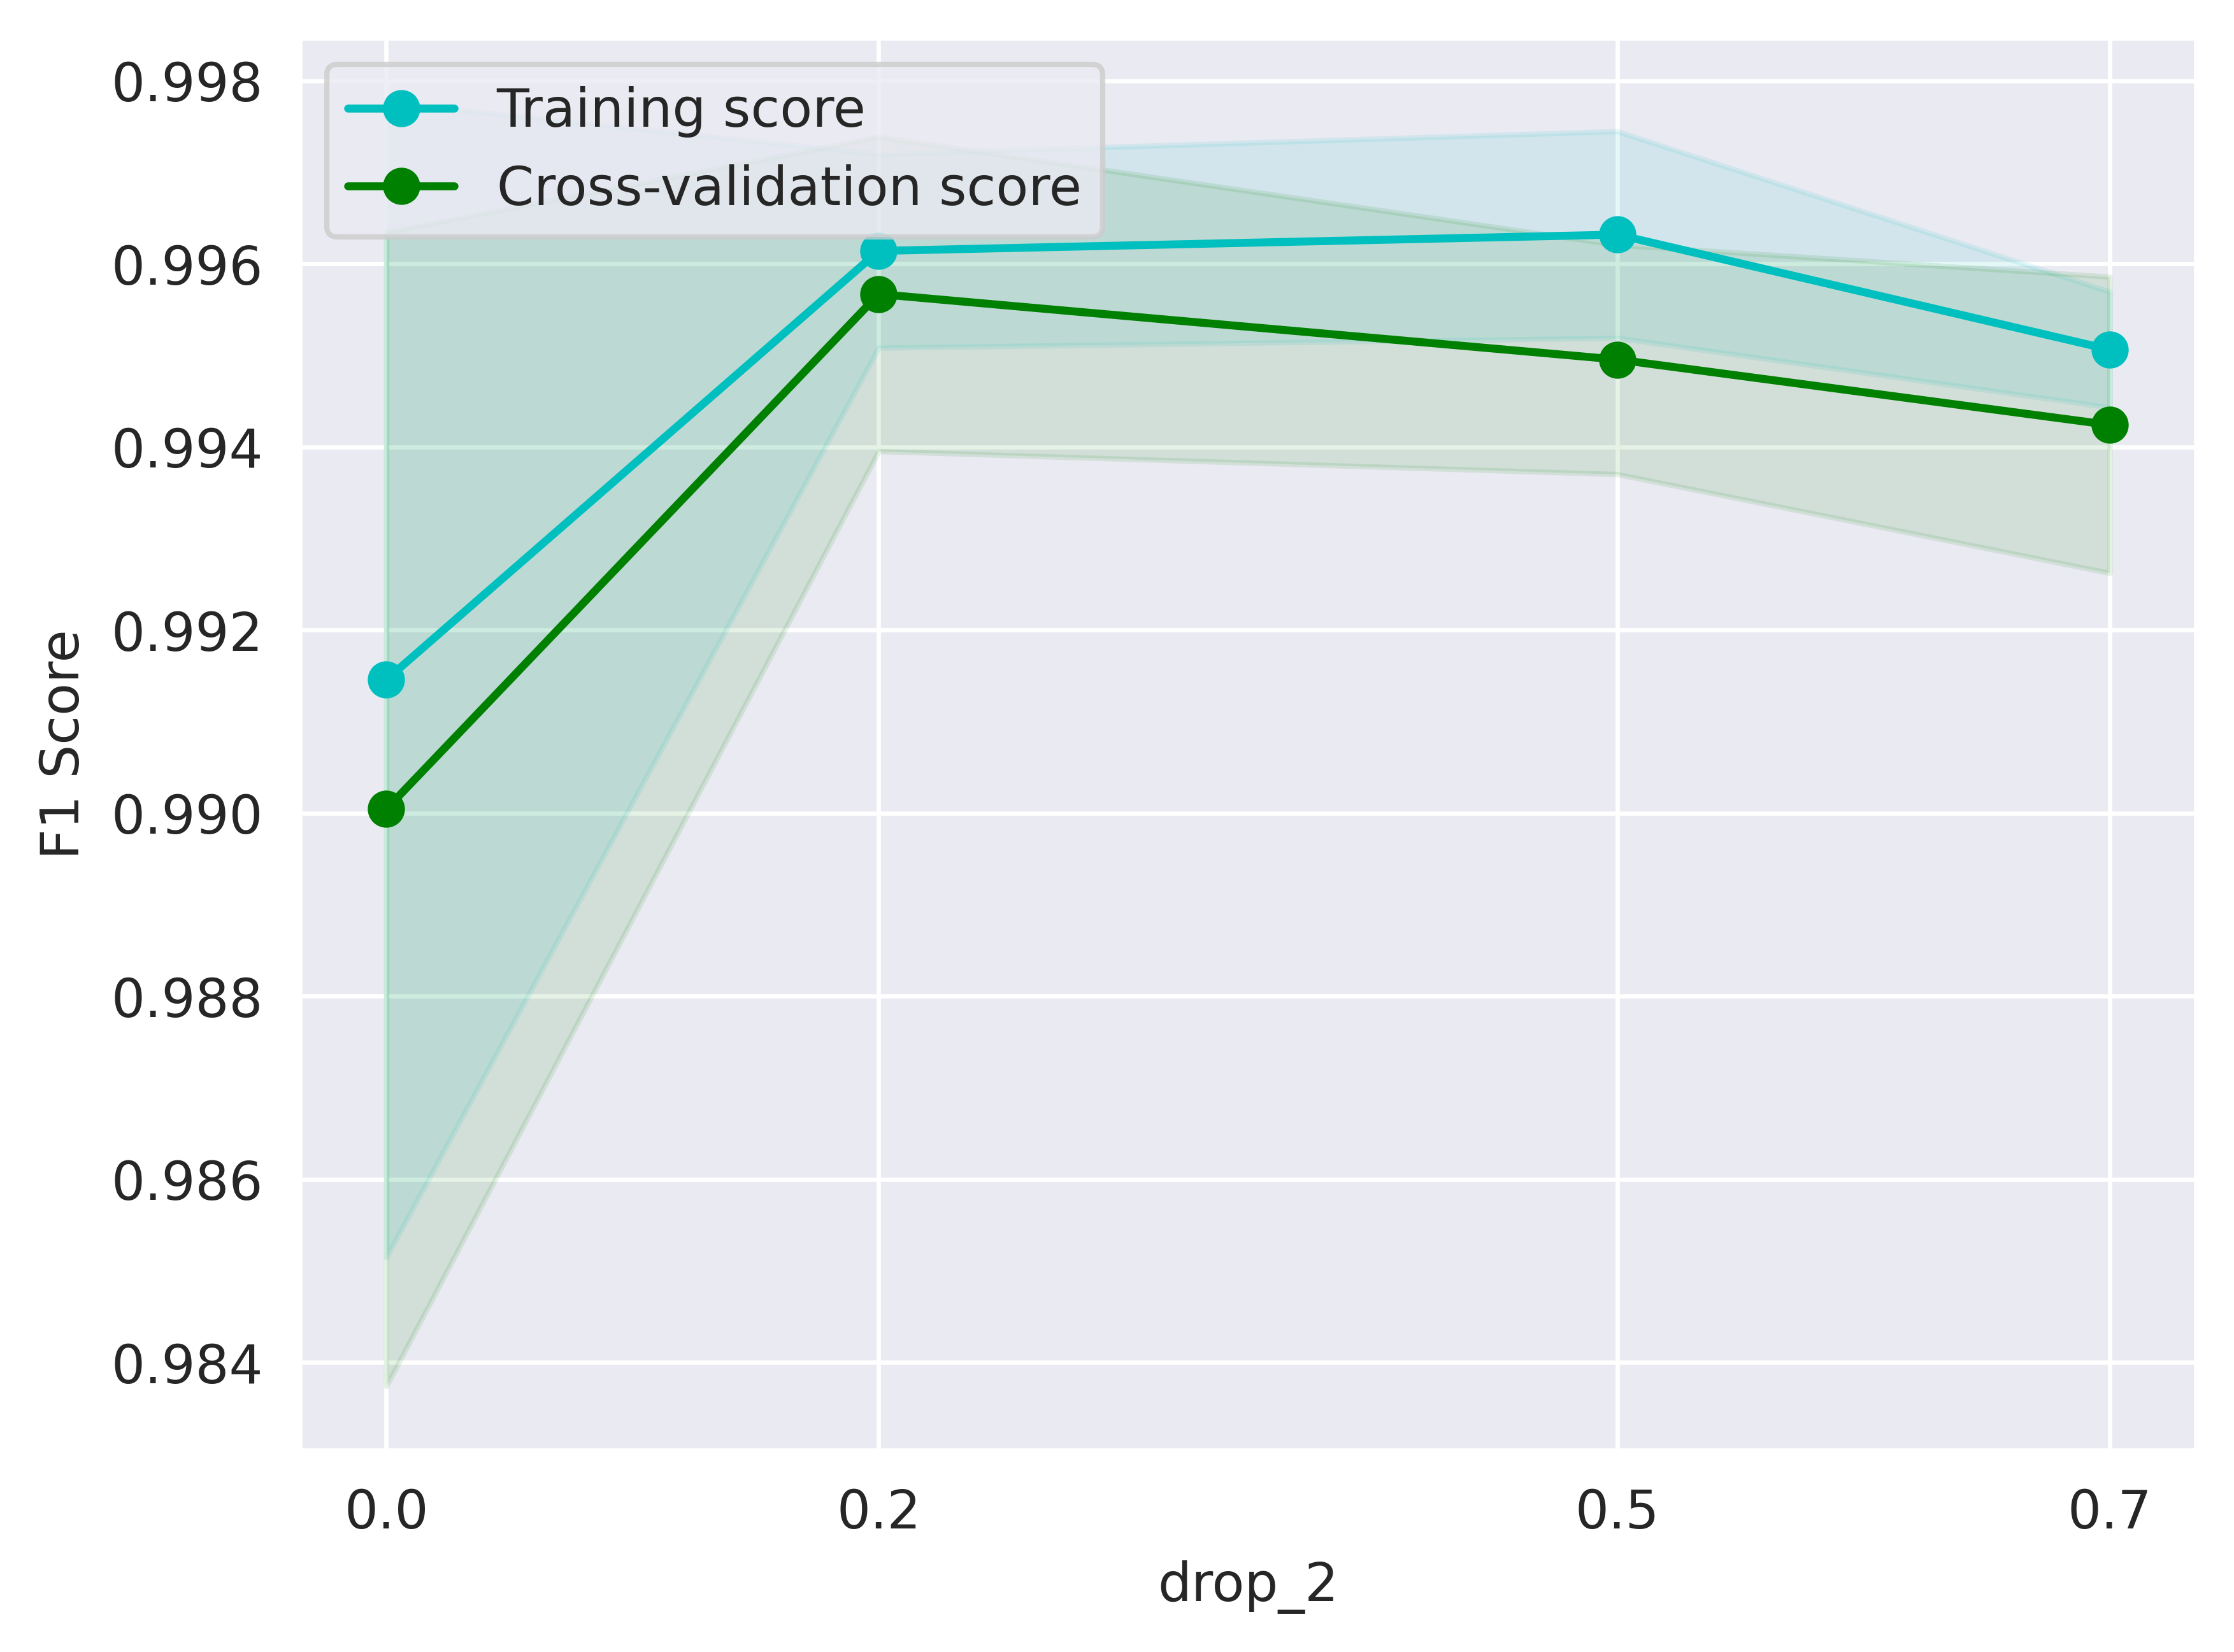

In [19]:
params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"drop_2": 0.0},
    {"drop_2": 0.2},
    {"drop_2": 0.5},
    {"drop_2": 0.7},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Drop_2", cv=sss_validation_curve)

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.9960 - accuracy: 0.8850 - val_loss: 0.7588 - val_accuracy: 0.6494 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1738 - accuracy: 0.9432 - val_loss: 0.0753 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1682 - accuracy: 0.9570 - val_loss: 0.1005 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1129 - accuracy: 0.9650 - val_loss: 0.0766 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1383 - accuracy: 0.9565 - val_loss: 0.2235 - val_accuracy: 0.9325 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1346 - accuracy: 0.9600 - val_loss: 0.0712 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7233 - accuracy: 0.8850 - val_loss: 0.2865 - val_accuracy: 0.9075 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2208 - accuracy: 0.9477 - val_loss: 0.1067 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1441 - accuracy: 0.9560 - val_loss: 0.1155 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0869 - accuracy: 0.9741 - val_loss: 0.0591 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2518 - accuracy: 0.9658 - val_loss: 0.1887 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2085 - accuracy: 0.9642 - val_loss: 0.0639 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6913 - accuracy: 0.8946 - val_loss: 0.1007 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1895 - accuracy: 0.9514 - val_loss: 0.0842 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1865 - accuracy: 0.9645 - val_loss: 0.0922 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1683 - accuracy: 0.9429 - val_loss: 0.1468 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1157 - accuracy: 0.9645 - val_loss: 0.0609 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0888 - accuracy: 0.9725 - val_loss: 0.0550 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8896 - accuracy: 0.9013 - val_loss: 0.1368 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1608 - accuracy: 0.9634 - val_loss: 0.0917 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0943 - accuracy: 0.9677 - val_loss: 0.0743 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1120 - accuracy: 0.9749 - val_loss: 0.0841 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1274 - accuracy: 0.9602 - val_loss: 0.1655 - val_accuracy: 0.9356 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0928 - accuracy: 0.9674 - val_loss: 0.0782 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.4236 - accuracy: 0.8978 - val_loss: 0.1094 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1316 - accuracy: 0.9528 - val_loss: 0.1151 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0988 - accuracy: 0.9656 - val_loss: 0.0905 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1287 - accuracy: 0.9637 - val_loss: 0.0873 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0822 - accuracy: 0.9674 - val_loss: 0.0819 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1020 - accuracy: 0.9658 - val_loss: 0.0763 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.4482 - accuracy: 0.8829 - val_loss: 0.1072 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1182 - accuracy: 0.9568 - val_loss: 0.0802 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0963 - accuracy: 0.9666 - val_loss: 0.1968 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1652 - accuracy: 0.9504 - val_loss: 0.1458 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0922 - accuracy: 0.9666 - val_loss: 0.0942 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0703 - accuracy: 0.9805 - val_loss: 0.0897 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/1000
114/118 [===========================>..] - ETA: 0s - loss:

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7114 - accuracy: 0.8644 - val_loss: 0.1613 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1962 - accuracy: 0.9325 - val_loss: 0.0791 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1512 - accuracy: 0.9645 - val_loss: 0.0887 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9597 - val_loss: 0.0658 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0861 - accuracy: 0.9701 - val_loss: 0.0647 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1043 - accuracy: 0.9669 - val_loss: 0.0621 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.9635 - accuracy: 0.8962 - val_loss: 0.3325 - val_accuracy: 0.9219 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3075 - accuracy: 0.9272 - val_loss: 0.2048 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1486 - accuracy: 0.9512 - val_loss: 0.0857 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1098 - accuracy: 0.9632 - val_loss: 0.0839 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2245 - accuracy: 0.9514 - val_loss: 0.0737 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0904 - accuracy: 0.9688 - val_loss: 0.0685 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.6590 - accuracy: 0.8562 - val_loss: 0.1813 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1863 - accuracy: 0.9560 - val_loss: 0.0880 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1354 - accuracy: 0.9626 - val_loss: 0.1672 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1187 - accuracy: 0.9680 - val_loss: 0.0962 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0880 - accuracy: 0.9712 - val_loss: 0.0523 - val_accuracy: 0.9869 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0693 - accuracy: 0.9725 - val_loss: 0.1722 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1097 - accuracy: 0.8973 - val_loss: 0.1581 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2159 - accuracy: 0.9520 - val_loss: 0.4225 - val_accuracy: 0.9181 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2071 - accuracy: 0.9570 - val_loss: 0.0802 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1158 - accuracy: 0.9610 - val_loss: 0.0968 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0849 - accuracy: 0.9712 - val_loss: 0.0603 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0802 - accuracy: 0.9688 - val_loss: 0.0574 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7678 - accuracy: 0.8938 - val_loss: 0.1001 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1678 - accuracy: 0.9522 - val_loss: 0.0757 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1556 - accuracy: 0.9448 - val_loss: 0.2312 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1506 - accuracy: 0.9605 - val_loss: 0.0964 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1068 - accuracy: 0.9616 - val_loss: 0.0846 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0875 - accuracy: 0.9685 - val_loss: 0.0715 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 2.1818 - accuracy: 0.8292 - val_loss: 0.2332 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3285 - accuracy: 0.9005 - val_loss: 0.1363 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1689 - accuracy: 0.9384 - val_loss: 0.1639 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1704 - accuracy: 0.9360 - val_loss: 0.0757 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.4655 - accuracy: 0.9290 - val_loss: 0.1981 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1790 - accuracy: 0.9472 - val_loss: 0.0957 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.1250 - accuracy: 0.8863 - val_loss: 0.1355 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1705 - accuracy: 0.9496 - val_loss: 0.1127 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1536 - accuracy: 0.9557 - val_loss: 0.0742 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1058 - accuracy: 0.9624 - val_loss: 0.0875 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1176 - accuracy: 0.9584 - val_loss: 0.0817 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1743 - accuracy: 0.9568 - val_loss: 0.1141 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5620 - accuracy: 0.8911 - val_loss: 0.1796 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1819 - accuracy: 0.9416 - val_loss: 0.0951 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1241 - accuracy: 0.9581 - val_loss: 0.1008 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1018 - accuracy: 0.9610 - val_loss: 0.0732 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1141 - accuracy: 0.9605 - val_loss: 0.1054 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0993 - accuracy: 0.9637 - val_loss: 0.0983 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.2965 - accuracy: 0.8503 - val_loss: 0.1531 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2102 - accuracy: 0.9480 - val_loss: 0.0977 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1608 - accuracy: 0.9509 - val_loss: 0.0885 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0907 - accuracy: 0.9613 - val_loss: 0.0786 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0838 - accuracy: 0.9650 - val_loss: 0.1027 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1024 - accuracy: 0.9688 - val_loss: 0.0782 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.5513 - accuracy: 0.8759 - val_loss: 0.1973 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3003 - accuracy: 0.9293 - val_loss: 0.2081 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2425 - accuracy: 0.9200 - val_loss: 0.1513 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1863 - accuracy: 0.9453 - val_loss: 0.1139 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1350 - accuracy: 0.9576 - val_loss: 0.0890 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1609 - accuracy: 0.9554 - val_loss: 0.0836 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7833 - accuracy: 0.8858 - val_loss: 0.1723 - val_accuracy: 0.9431 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2756 - accuracy: 0.9210 - val_loss: 0.6928 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2597 - accuracy: 0.9274 - val_loss: 0.0906 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1449 - accuracy: 0.9525 - val_loss: 0.0813 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1538 - accuracy: 0.9530 - val_loss: 0.0687 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1282 - accuracy: 0.9600 - val_loss: 0.0704 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.9475 - accuracy: 0.8770 - val_loss: 0.1071 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3256 - accuracy: 0.9202 - val_loss: 0.0879 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1902 - accuracy: 0.9445 - val_loss: 0.0786 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1208 - accuracy: 0.9624 - val_loss: 0.0783 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1136 - accuracy: 0.9581 - val_loss: 0.0667 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.9677 - val_loss: 0.0613 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7428 - accuracy: 0.8802 - val_loss: 0.1764 - val_accuracy: 0.9550 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2087 - accuracy: 0.9277 - val_loss: 0.1317 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3320 - accuracy: 0.9298 - val_loss: 0.1219 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2088 - accuracy: 0.9389 - val_loss: 0.1643 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1880 - accuracy: 0.9376 - val_loss: 0.1000 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1942 - accuracy: 0.9498 - val_loss: 0.0808 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 1.7265 - accuracy: 0.8890 - val_loss: 0.2235 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2651 - accuracy: 0.9096 - val_loss: 0.1499 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.4027 - accuracy: 0.9264 - val_loss: 0.1754 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2587 - accuracy: 0.9330 - val_loss: 0.1769 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1761 - accuracy: 0.9498 - val_loss: 0.1122 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1377 - accuracy: 0.9570 - val_loss: 0.0899 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

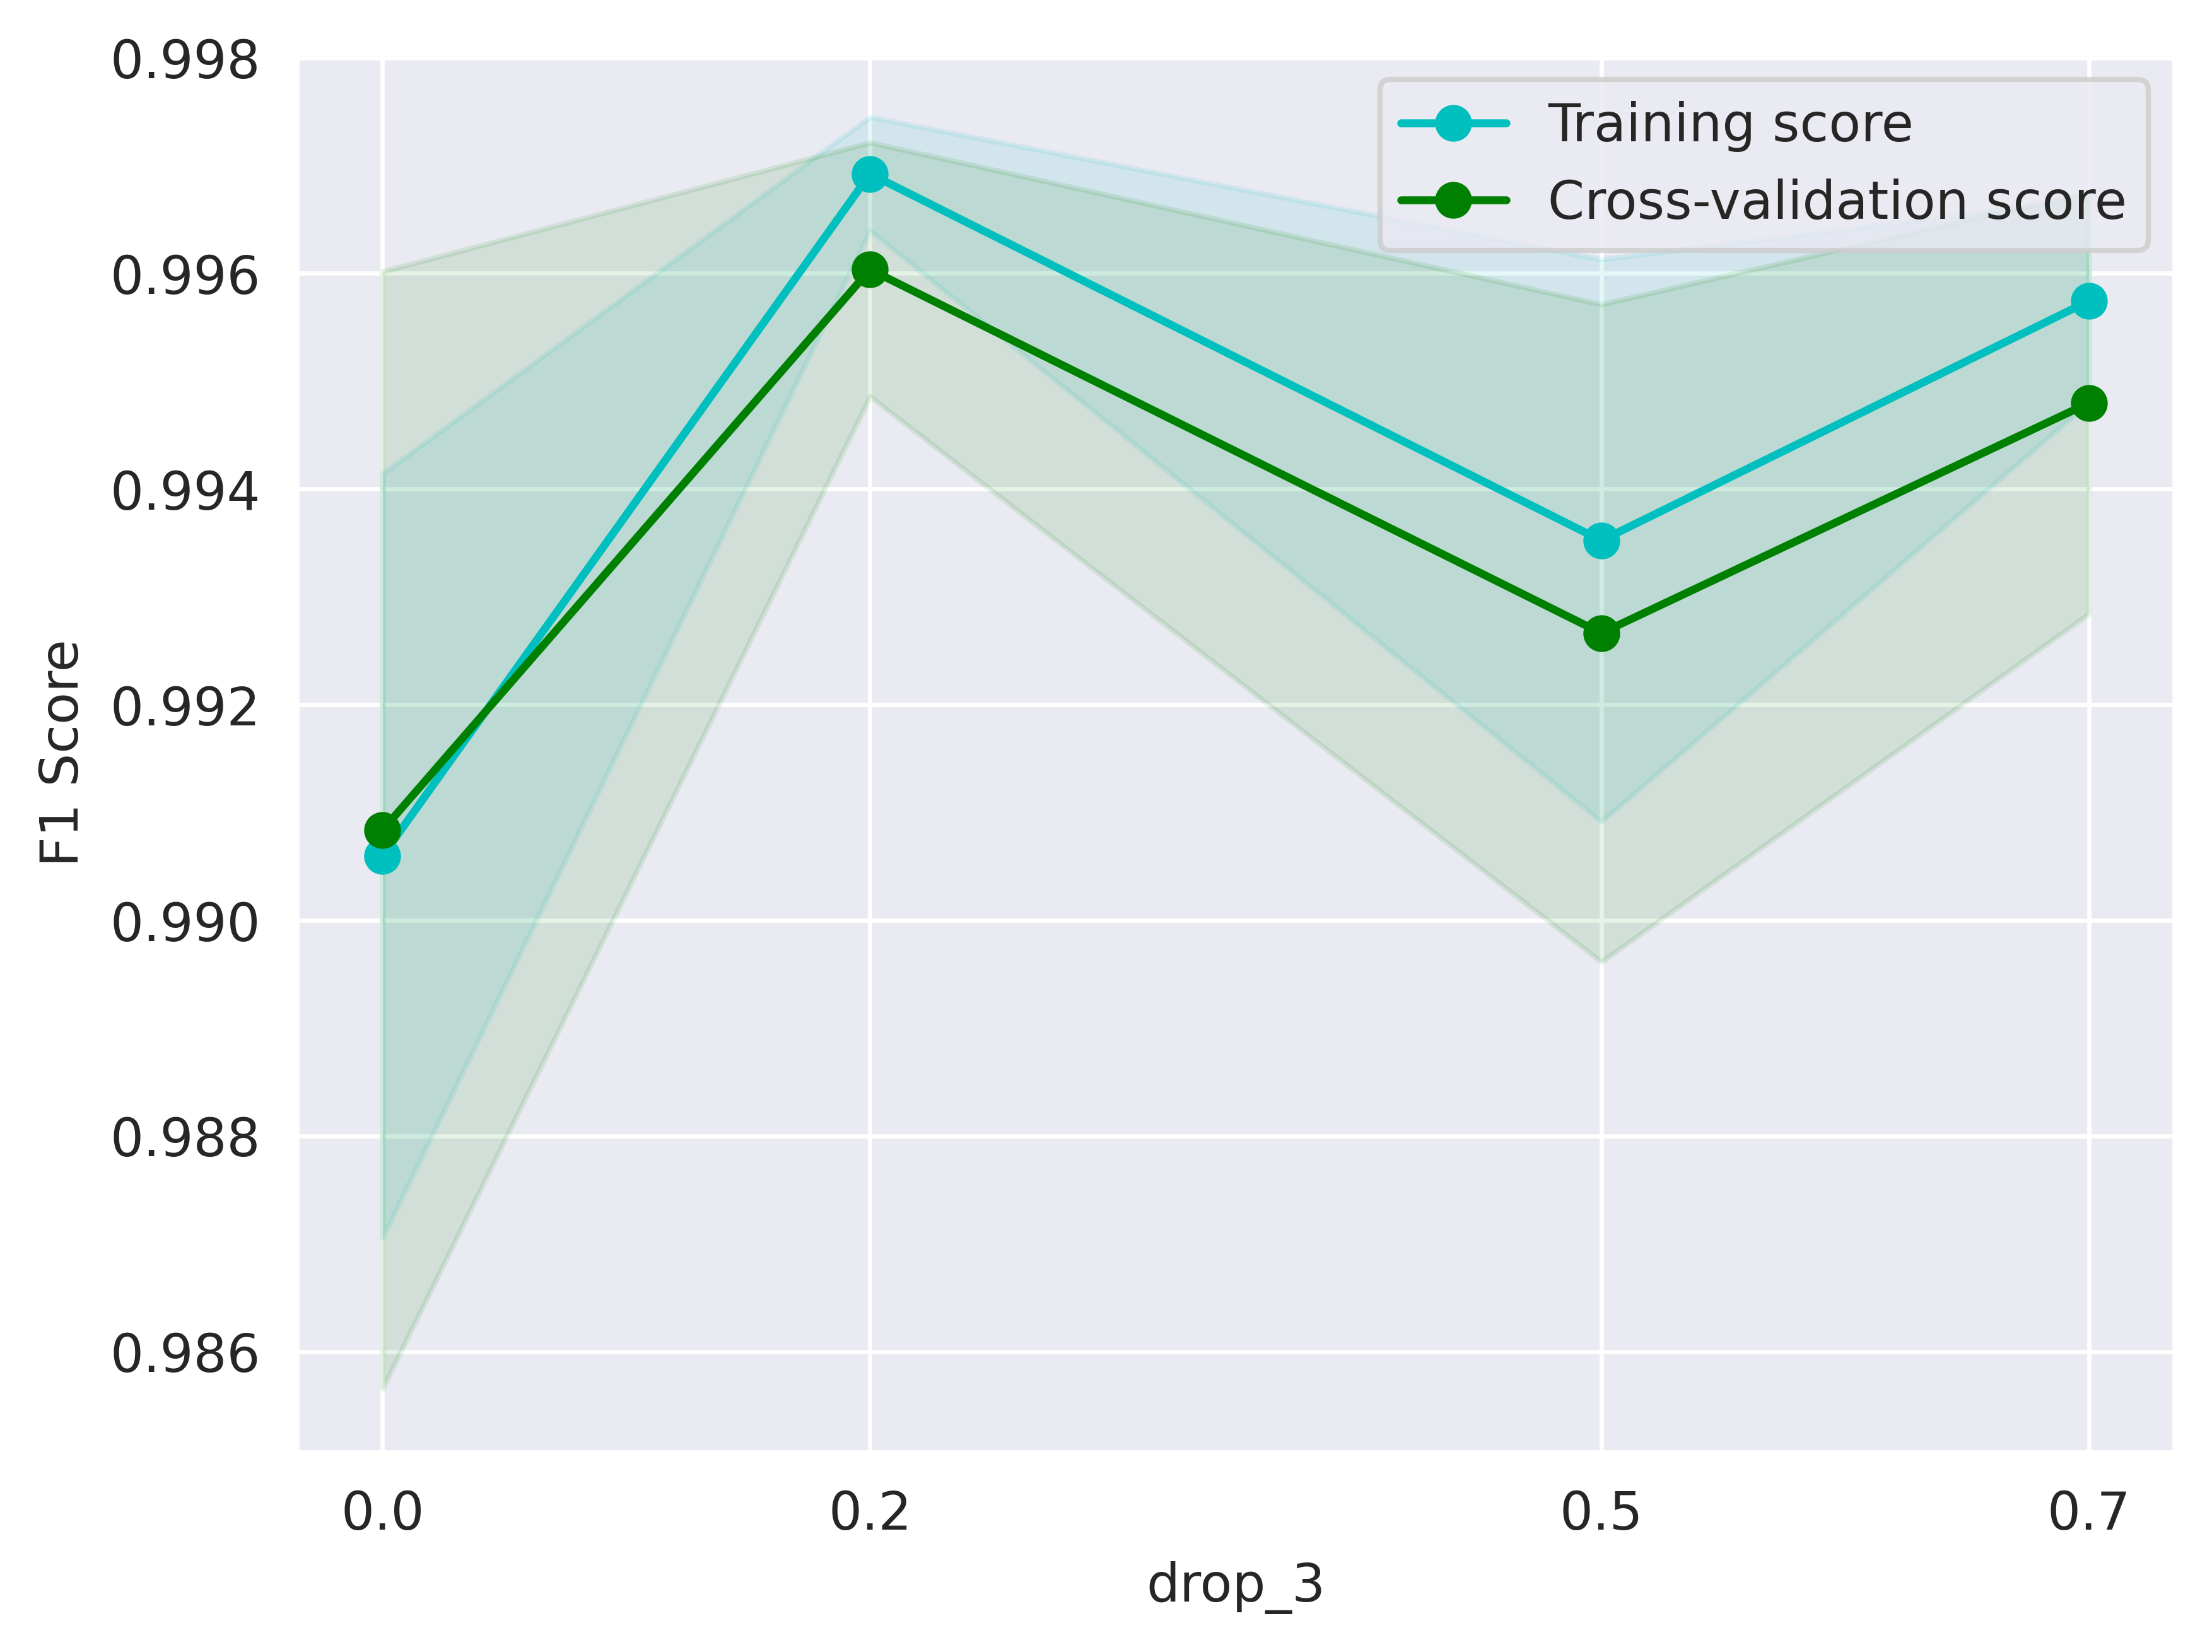

In [20]:
params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"drop_3": 0.0},
    {"drop_3": 0.2},
    {"drop_3": 0.5},
    {"drop_3": 0.7},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Drop_3", cv=sss_validation_curve)

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6982 - accuracy: 0.8967 - val_loss: 0.1262 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1564 - accuracy: 0.9472 - val_loss: 0.0763 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1722 - accuracy: 0.9504 - val_loss: 0.1395 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1435 - accuracy: 0.9512 - val_loss: 0.1026 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1330 - accuracy: 0.9552 - val_loss: 0.0863 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0744 - accuracy: 0.9717 - val_loss: 0.0781 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6587 - accuracy: 0.8930 - val_loss: 0.4724 - val_accuracy: 0.9031 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2104 - accuracy: 0.9325 - val_loss: 0.1514 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1407 - accuracy: 0.9466 - val_loss: 0.1615 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1087 - accuracy: 0.9634 - val_loss: 0.1637 - val_accuracy: 0.9400 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3109 - accuracy: 0.9317 - val_loss: 0.2168 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1258 - accuracy: 0.9621 - val_loss: 0.0608 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6228 - accuracy: 0.8938 - val_loss: 0.1211 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1655 - accuracy: 0.9552 - val_loss: 0.1242 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1040 - accuracy: 0.9693 - val_loss: 0.0641 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0913 - accuracy: 0.9680 - val_loss: 0.0577 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0924 - accuracy: 0.9693 - val_loss: 0.0583 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0777 - accuracy: 0.9760 - val_loss: 0.0578 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5065 - accuracy: 0.9088 - val_loss: 0.1204 - val_accuracy: 0.9606 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1878 - accuracy: 0.9333 - val_loss: 0.2145 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1878 - accuracy: 0.9410 - val_loss: 0.0773 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0887 - accuracy: 0.9608 - val_loss: 0.0760 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2148 - accuracy: 0.9538 - val_loss: 0.0854 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1123 - accuracy: 0.9592 - val_loss: 0.0616 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7273 - accuracy: 0.9080 - val_loss: 0.1067 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1453 - accuracy: 0.9613 - val_loss: 0.2197 - val_accuracy: 0.9525 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2769 - accuracy: 0.9453 - val_loss: 0.1054 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1639 - accuracy: 0.9618 - val_loss: 0.0813 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0978 - accuracy: 0.9536 - val_loss: 0.0641 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0775 - accuracy: 0.9731 - val_loss: 0.1130 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5488 - accuracy: 0.8842 - val_loss: 0.1149 - val_accuracy: 0.9506 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2726 - accuracy: 0.9346 - val_loss: 0.1630 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1208 - accuracy: 0.9600 - val_loss: 0.1529 - val_accuracy: 0.9450 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1768 - accuracy: 0.9490 - val_loss: 0.0958 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2660 - accuracy: 0.9501 - val_loss: 0.1022 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1624 - accuracy: 0.9477 - val_loss: 0.0733 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.8841 - accuracy: 0.8943 - val_loss: 0.0873 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1187 - accuracy: 0.9613 - val_loss: 0.0672 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1356 - accuracy: 0.9512 - val_loss: 0.0686 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0965 - accuracy: 0.9664 - val_loss: 0.0517 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0694 - accuracy: 0.9731 - val_loss: 0.0592 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0891 - accuracy: 0.9757 - val_loss: 0.0369 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6441 - accuracy: 0.8917 - val_loss: 0.4114 - val_accuracy: 0.9231 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2078 - accuracy: 0.9426 - val_loss: 0.0764 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1267 - accuracy: 0.9610 - val_loss: 0.0671 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1003 - accuracy: 0.9699 - val_loss: 0.0665 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2697 - accuracy: 0.9293 - val_loss: 0.0818 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1152 - accuracy: 0.9624 - val_loss: 0.0818 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4956 - accuracy: 0.9039 - val_loss: 0.1491 - val_accuracy: 0.9531 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.9578 - val_loss: 0.1226 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1626 - accuracy: 0.9509 - val_loss: 0.0849 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1279 - accuracy: 0.9661 - val_loss: 0.0973 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1005 - accuracy: 0.9642 - val_loss: 0.0742 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0799 - accuracy: 0.9712 - val_loss: 0.0622 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 2s 7ms/step - loss: 0.7319 - accuracy: 0.9130 - val_loss: 0.5927 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2889 - accuracy: 0.9264 - val_loss: 0.1826 - val_accuracy: 0.9369 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2222 - accuracy: 0.9442 - val_loss: 0.1263 - val_accuracy: 0.9494 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1219 - accuracy: 0.9600 - val_loss: 0.1039 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1266 - accuracy: 0.9634 - val_loss: 0.0847 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0844 - accuracy: 0.9691 - val_loss: 0.0742 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.6901 - accuracy: 0.8519 - val_loss: 0.1502 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1962 - accuracy: 0.9424 - val_loss: 0.1520 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1507 - accuracy: 0.9525 - val_loss: 0.0848 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1163 - accuracy: 0.9589 - val_loss: 0.0741 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1171 - accuracy: 0.9605 - val_loss: 0.0724 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0746 - accuracy: 0.9693 - val_loss: 0.0828 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6523 - accuracy: 0.9053 - val_loss: 0.2217 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1632 - accuracy: 0.9554 - val_loss: 0.2804 - val_accuracy: 0.9112 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1835 - accuracy: 0.9469 - val_loss: 0.0698 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0964 - accuracy: 0.9650 - val_loss: 0.0541 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0974 - accuracy: 0.9661 - val_loss: 0.0576 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0837 - accuracy: 0.9723 - val_loss: 0.0653 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 4ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7219 - accuracy: 0.8679 - val_loss: 0.2477 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2474 - accuracy: 0.9144 - val_loss: 0.0965 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1823 - accuracy: 0.9496 - val_loss: 0.1066 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1244 - accuracy: 0.9570 - val_loss: 0.0770 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1115 - accuracy: 0.9634 - val_loss: 0.1177 - val_accuracy: 0.9762 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1080 - accuracy: 0.9618 - val_loss: 0.0601 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 1.4557 - accuracy: 0.8487 - val_loss: 0.7389 - val_accuracy: 0.9150 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2590 - accuracy: 0.9402 - val_loss: 0.1281 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1874 - accuracy: 0.9458 - val_loss: 0.3580 - val_accuracy: 0.9250 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2107 - accuracy: 0.9522 - val_loss: 0.0849 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1100 - accuracy: 0.9664 - val_loss: 0.0975 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1107 - accuracy: 0.9637 - val_loss: 0.2138 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7790 - accuracy: 0.8901 - val_loss: 0.1607 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1588 - accuracy: 0.9436 - val_loss: 0.1815 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1425 - accuracy: 0.9562 - val_loss: 0.0854 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1303 - accuracy: 0.9520 - val_loss: 0.0786 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1495 - accuracy: 0.9541 - val_loss: 0.0961 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1119 - accuracy: 0.9594 - val_loss: 0.0902 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9436 - accuracy: 0.8455 - val_loss: 0.1840 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2472 - accuracy: 0.9202 - val_loss: 0.1461 - val_accuracy: 0.9413 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1965 - accuracy: 0.9274 - val_loss: 0.0860 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1991 - accuracy: 0.9434 - val_loss: 0.0855 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1385 - accuracy: 0.9520 - val_loss: 0.1233 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1805 - accuracy: 0.9456 - val_loss: 0.1065 - val_accuracy: 0.9694 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.9940 - accuracy: 0.8818 - val_loss: 0.4935 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2610 - accuracy: 0.9205 - val_loss: 0.1754 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1957 - accuracy: 0.9392 - val_loss: 0.0807 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1925 - accuracy: 0.9410 - val_loss: 0.1762 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1461 - accuracy: 0.9490 - val_loss: 0.2749 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1759 - accuracy: 0.9392 - val_loss: 0.1105 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 9ms/step - loss: 1.2550 - accuracy: 0.8647 - val_loss: 0.1728 - val_accuracy: 0.9087 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3398 - accuracy: 0.9186 - val_loss: 0.1190 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 0.9386 - val_loss: 0.1780 - val_accuracy: 0.9275 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1492 - accuracy: 0.9472 - val_loss: 0.0707 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1369 - accuracy: 0.9525 - val_loss: 0.1386 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1363 - accuracy: 0.9501 - val_loss: 0.0685 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5811 - accuracy: 0.8522 - val_loss: 1.2328 - val_accuracy: 0.8994 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.4386 - accuracy: 0.9106 - val_loss: 0.0996 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1748 - accuracy: 0.9389 - val_loss: 0.1210 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1208 - accuracy: 0.9520 - val_loss: 0.1045 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1113 - accuracy: 0.9525 - val_loss: 0.0922 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1362 - accuracy: 0.9570 - val_loss: 0.0752 - val_accuracy: 0.9756 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7877 - accuracy: 0.8343 - val_loss: 0.1557 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2723 - accuracy: 0.9250 - val_loss: 0.1440 - val_accuracy: 0.9588 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2377 - accuracy: 0.9296 - val_loss: 0.7557 - val_accuracy: 0.6275 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3011 - accuracy: 0.9368 - val_loss: 0.0917 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1295 - accuracy: 0.9554 - val_loss: 0.0732 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1063 - accuracy: 0.9576 - val_loss: 0.0709 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

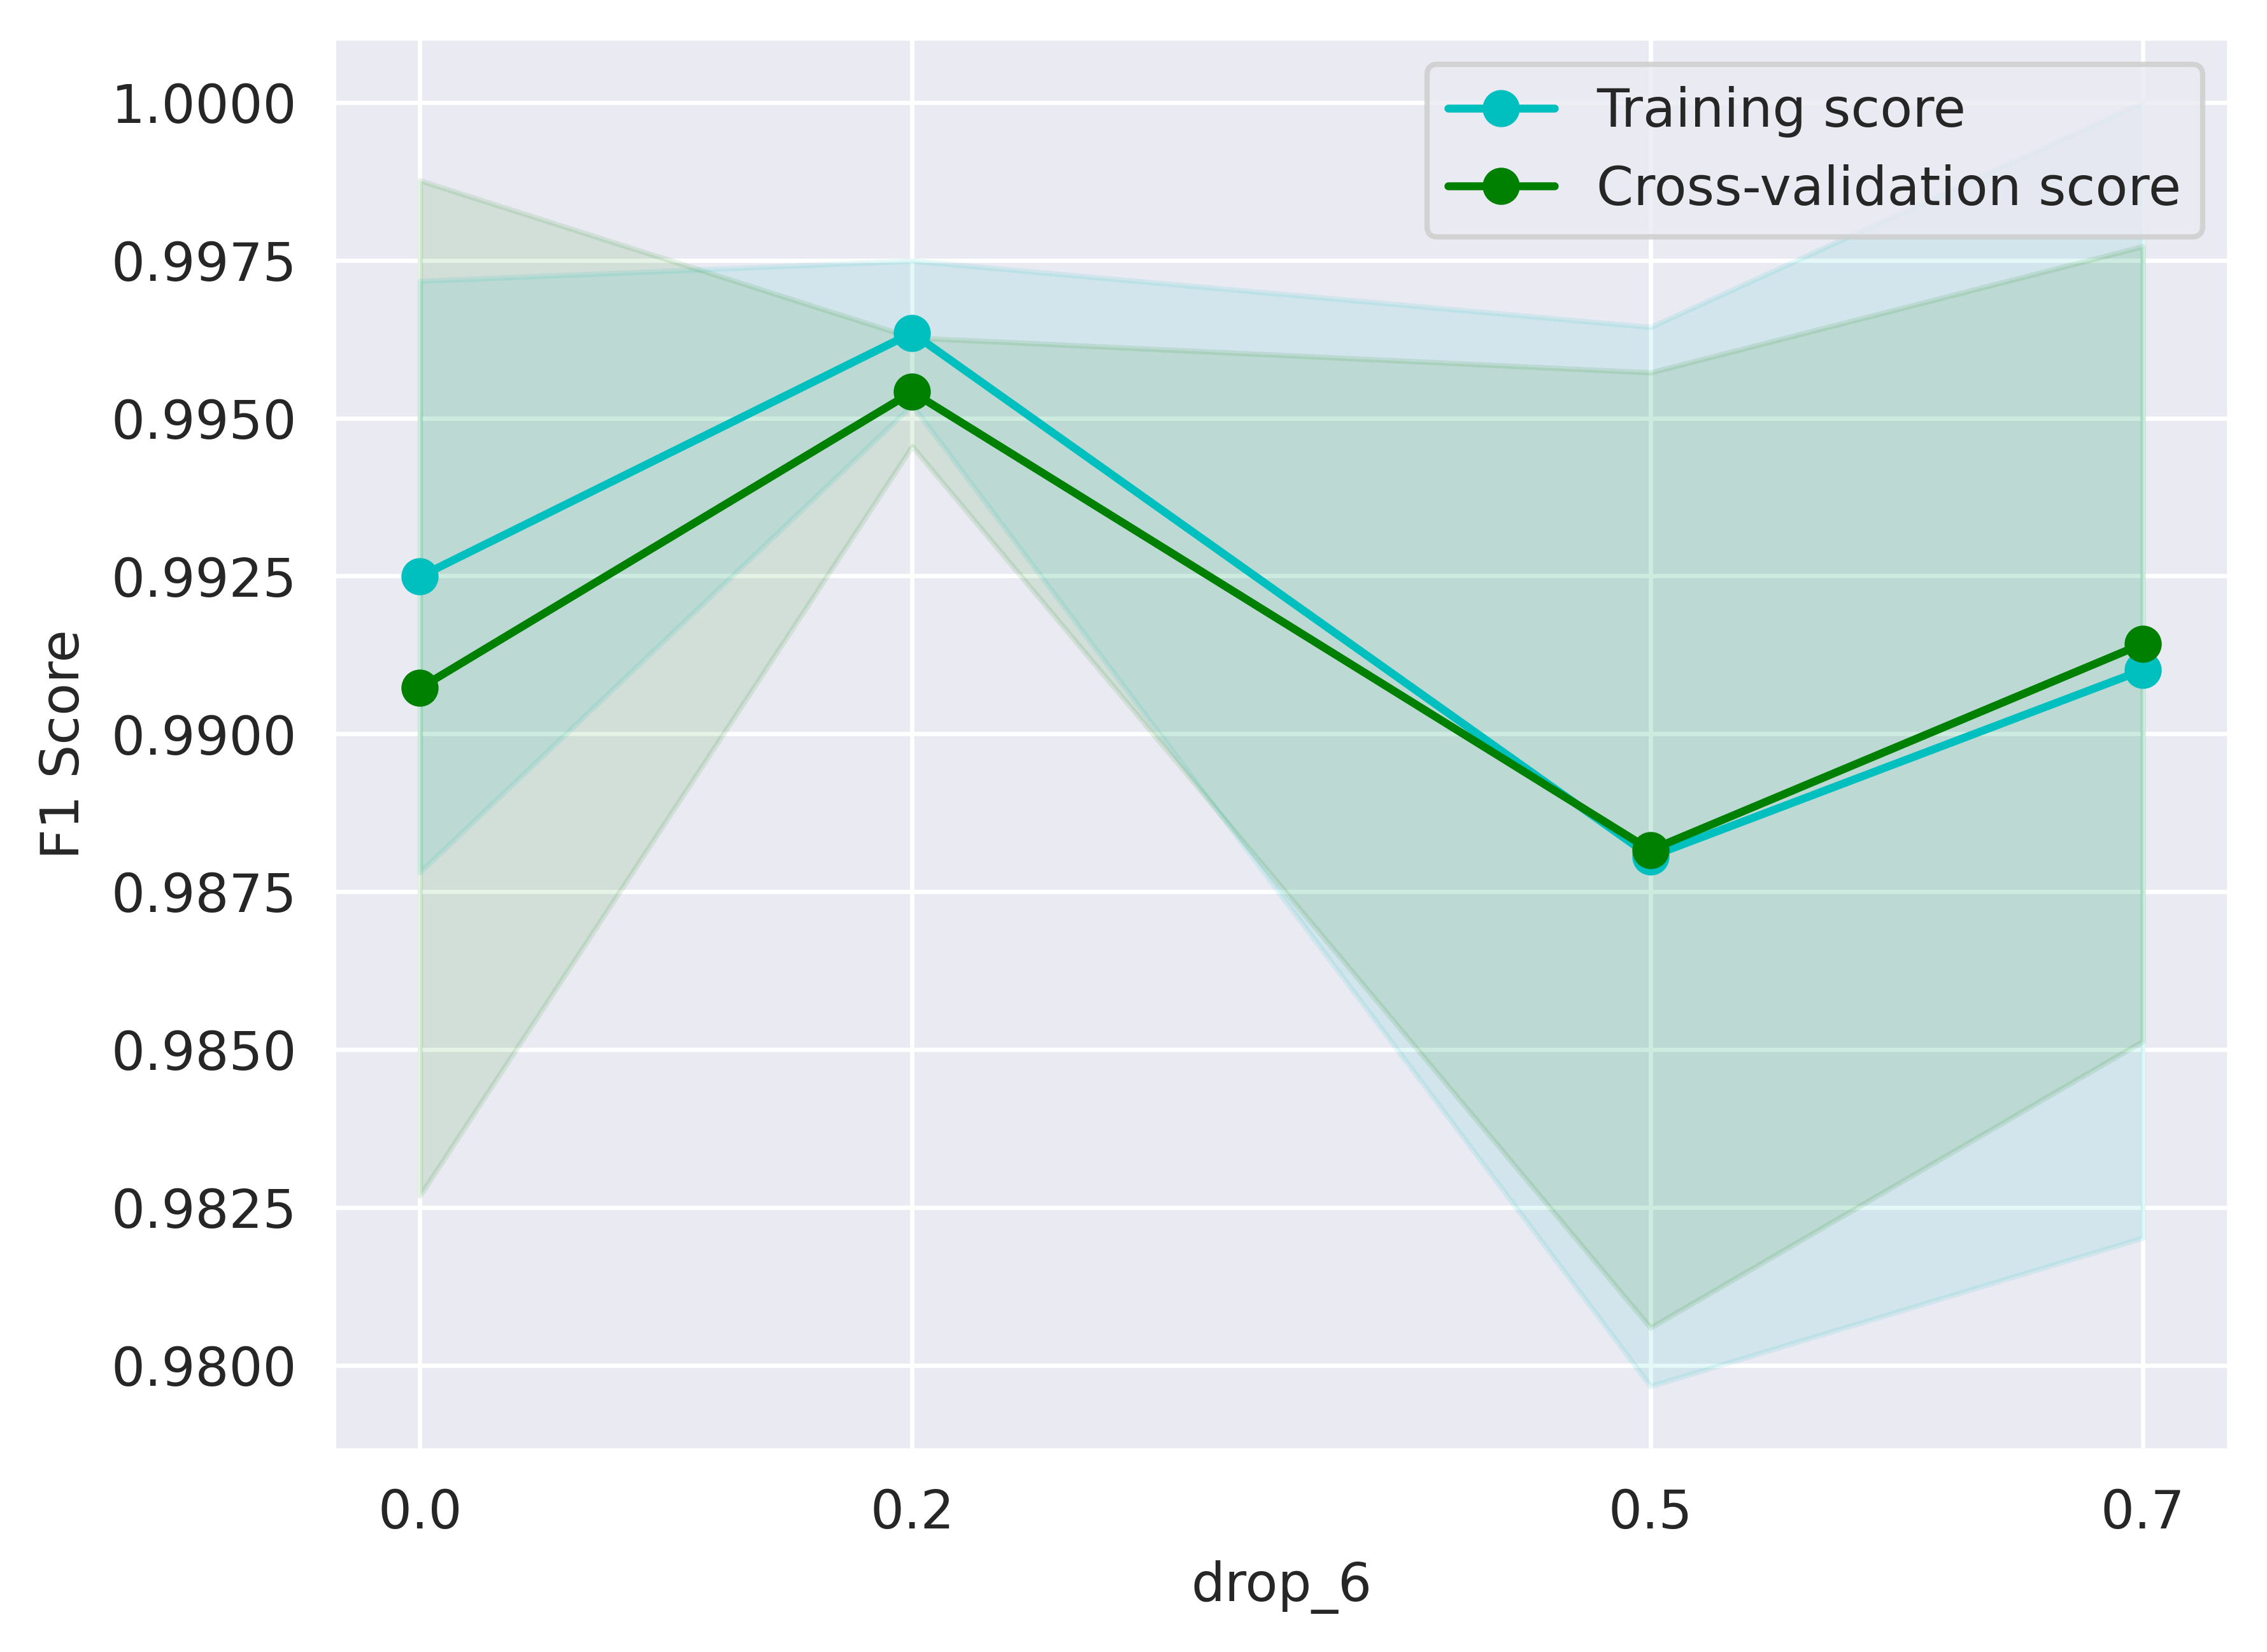

In [21]:
params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"drop_6": 0.0},
    {"drop_6": 0.2},
    {"drop_6": 0.5},
    {"drop_6": 0.7},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Drop_6", cv=sss_validation_curve)

Starting params: {'optimizer': 'adam', 'num_classes': 5, 'layer_1': 512, 'layer_2': 256, 'layer_3': 128, 'drop_1': 0.0, 'drop_2': 0.0, 'drop_3': 0.0, 'drop_4': 0.0, 'drop_5': 0.0, 'drop_6': 0.0, 'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'activation_4': 'relu', 'activation_5': 'relu', 'activation_6': 'relu'}
Removed existing training dir
Found 3780 images belonging to 5 classes.
Found 1620 images belonging to 5 classes.
Optimizer is set to: adam
Epoch 1/1000


/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5961 - accuracy: 0.8839 - val_loss: 0.1116 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3288 - accuracy: 0.9322 - val_loss: 0.1726 - val_accuracy: 0.9544 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3017 - accuracy: 0.9434 - val_loss: 0.0969 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0942 - accuracy: 0.9723 - val_loss: 0.0926 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0794 - accuracy: 0.9731 - val_loss: 0.0702 - val_accuracy: 0.9819 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0631 - accuracy: 0.9715 - val_loss: 0.0549 - val_accuracy: 0.9844 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.5924 - accuracy: 0.9015 - val_loss: 0.2248 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2699 - accuracy: 0.9330 - val_loss: 0.1163 - val_accuracy: 0.9594 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1668 - accuracy: 0.9501 - val_loss: 0.1049 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0954 - accuracy: 0.9650 - val_loss: 0.0787 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0933 - accuracy: 0.9674 - val_loss: 0.0632 - val_accuracy: 0.9712 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0885 - accuracy: 0.9709 - val_loss: 0.0617 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7596 - accuracy: 0.9037 - val_loss: 0.2409 - val_accuracy: 0.9319 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2433 - accuracy: 0.9378 - val_loss: 0.1050 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1735 - accuracy: 0.9490 - val_loss: 0.0885 - val_accuracy: 0.9625 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1837 - accuracy: 0.9608 - val_loss: 0.0780 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1078 - accuracy: 0.9562 - val_loss: 0.0962 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1094 - accuracy: 0.9720 - val_loss: 0.0864 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 1.5625 - accuracy: 0.8506 - val_loss: 0.1249 - val_accuracy: 0.9581 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1437 - accuracy: 0.9576 - val_loss: 0.1447 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1098 - accuracy: 0.9624 - val_loss: 0.0982 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1194 - accuracy: 0.9680 - val_loss: 0.0925 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0834 - accuracy: 0.9699 - val_loss: 0.0798 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1313 - accuracy: 0.9634 - val_loss: 0.1228 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.8593 - accuracy: 0.8933 - val_loss: 0.1339 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1623 - accuracy: 0.9450 - val_loss: 0.0746 - val_accuracy: 0.9800 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1392 - accuracy: 0.9594 - val_loss: 0.2199 - val_accuracy: 0.9237 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1884 - accuracy: 0.9445 - val_loss: 0.0778 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0983 - accuracy: 0.9626 - val_loss: 0.1026 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0828 - accuracy: 0.9704 - val_loss: 0.0584 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.6462 - accuracy: 0.9015 - val_loss: 0.1222 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1467 - accuracy: 0.9442 - val_loss: 0.1295 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2189 - accuracy: 0.9485 - val_loss: 0.2086 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1274 - accuracy: 0.9653 - val_loss: 0.0672 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0725 - accuracy: 0.9712 - val_loss: 0.0746 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0629 - accuracy: 0.9789 - val_loss: 0.0621 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 7ms/step - loss: 0.7848 - accuracy: 0.9088 - val_loss: 0.1446 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1560 - accuracy: 0.9530 - val_loss: 0.0759 - val_accuracy: 0.9656 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0974 - accuracy: 0.9688 - val_loss: 0.3269 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.2275 - accuracy: 0.9354 - val_loss: 0.0670 - val_accuracy: 0.9737 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0865 - accuracy: 0.9645 - val_loss: 0.0548 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0779 - accuracy: 0.9715 - val_loss: 0.0934 - val_accuracy: 0.9825 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7039 - accuracy: 0.8997 - val_loss: 0.1422 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1739 - accuracy: 0.9448 - val_loss: 0.2799 - val_accuracy: 0.9394 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1844 - accuracy: 0.9509 - val_loss: 0.0696 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0957 - accuracy: 0.9656 - val_loss: 0.0636 - val_accuracy: 0.9675 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0779 - accuracy: 0.9658 - val_loss: 0.3514 - val_accuracy: 0.9488 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2239 - accuracy: 0.9506 - val_loss: 0.0577 - val_accuracy: 0.9725 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7999 - accuracy: 0.8677 - val_loss: 0.1946 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1997 - accuracy: 0.9602 - val_loss: 0.0840 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1323 - accuracy: 0.9626 - val_loss: 0.0910 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0989 - accuracy: 0.9688 - val_loss: 0.0727 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0751 - accuracy: 0.9747 - val_loss: 0.0728 - val_accuracy: 0.9769 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1464 - accuracy: 0.9568 - val_loss: 0.1342 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.4841 - accuracy: 0.9042 - val_loss: 0.1252 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1265 - accuracy: 0.9674 - val_loss: 0.1253 - val_accuracy: 0.9613 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1071 - accuracy: 0.9645 - val_loss: 0.0705 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0865 - accuracy: 0.9691 - val_loss: 0.0775 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1007 - accuracy: 0.9693 - val_loss: 0.1073 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2110 - accuracy: 0.9421 - val_loss: 0.0933 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.5814 - accuracy: 0.9050 - val_loss: 0.2135 - val_accuracy: 0.9575 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.1416 - accuracy: 0.9624 - val_loss: 0.1505 - val_accuracy: 0.9644 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1378 - accuracy: 0.9629 - val_loss: 0.0807 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0878 - accuracy: 0.9680 - val_loss: 0.0811 - val_accuracy: 0.9794 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0804 - accuracy: 0.9674 - val_loss: 0.0600 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0565 - accuracy: 0.9731 - val_loss: 0.0716 - val_accuracy: 0.9744 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 10ms/step - loss: 0.7919 - accuracy: 0.8858 - val_loss: 0.1671 - val_accuracy: 0.9556 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1968 - accuracy: 0.9269 - val_loss: 0.1033 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1536 - accuracy: 0.9544 - val_loss: 0.0720 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0927 - accuracy: 0.9618 - val_loss: 0.0663 - val_accuracy: 0.9731 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0764 - accuracy: 0.9699 - val_loss: 0.0683 - val_accuracy: 0.9812 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0909 - accuracy: 0.9645 - val_loss: 0.0532 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - 

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.7187 - accuracy: 0.9117 - val_loss: 0.1669 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1851 - accuracy: 0.9592 - val_loss: 0.3719 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2430 - accuracy: 0.9472 - val_loss: 0.1332 - val_accuracy: 0.9569 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1560 - accuracy: 0.9538 - val_loss: 0.0921 - val_accuracy: 0.9669 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1276 - accuracy: 0.9626 - val_loss: 0.1319 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0983 - accuracy: 0.9669 - val_loss: 0.0645 - val_accuracy: 0.9781 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 6ms/step - loss: 0.9640 - accuracy: 0.8602 - val_loss: 0.2085 - val_accuracy: 0.9444 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3039 - accuracy: 0.9245 - val_loss: 0.1693 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.2062 - accuracy: 0.9442 - val_loss: 0.0860 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1125 - accuracy: 0.9568 - val_loss: 0.0778 - val_accuracy: 0.9663 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 4ms/step - loss: 0.0932 - accuracy: 0.9707 - val_loss: 0.0839 - val_accuracy: 0.9837 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1109 - accuracy: 0.9629 - val_loss: 0.0878 - val_accuracy: 0.9638 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/home/gabriel/anaconda3/envs/pyenvml/lib/python3.10/site-packages/keras/backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


118/118 [==============================] - 1s 8ms/step - loss: 0.6961 - accuracy: 0.9002 - val_loss: 0.3423 - val_accuracy: 0.9169 - lr: 0.0010
Epoch 2/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.3747 - accuracy: 0.9314 - val_loss: 0.0981 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1600 - accuracy: 0.9461 - val_loss: 0.1340 - val_accuracy: 0.9631 - lr: 0.0010
Epoch 4/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1857 - accuracy: 0.9626 - val_loss: 0.1660 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 5/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.1616 - accuracy: 0.9464 - val_loss: 0.0673 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 6/1000
118/118 [==============================] - 1s 5ms/step - loss: 0.0728 - accuracy: 0.9760 - val_loss: 0.0624 - val_accuracy: 0.9787 - lr: 0.0010
Epoch 7/1000
118/118 [==============================] - 1s 5ms/step - l

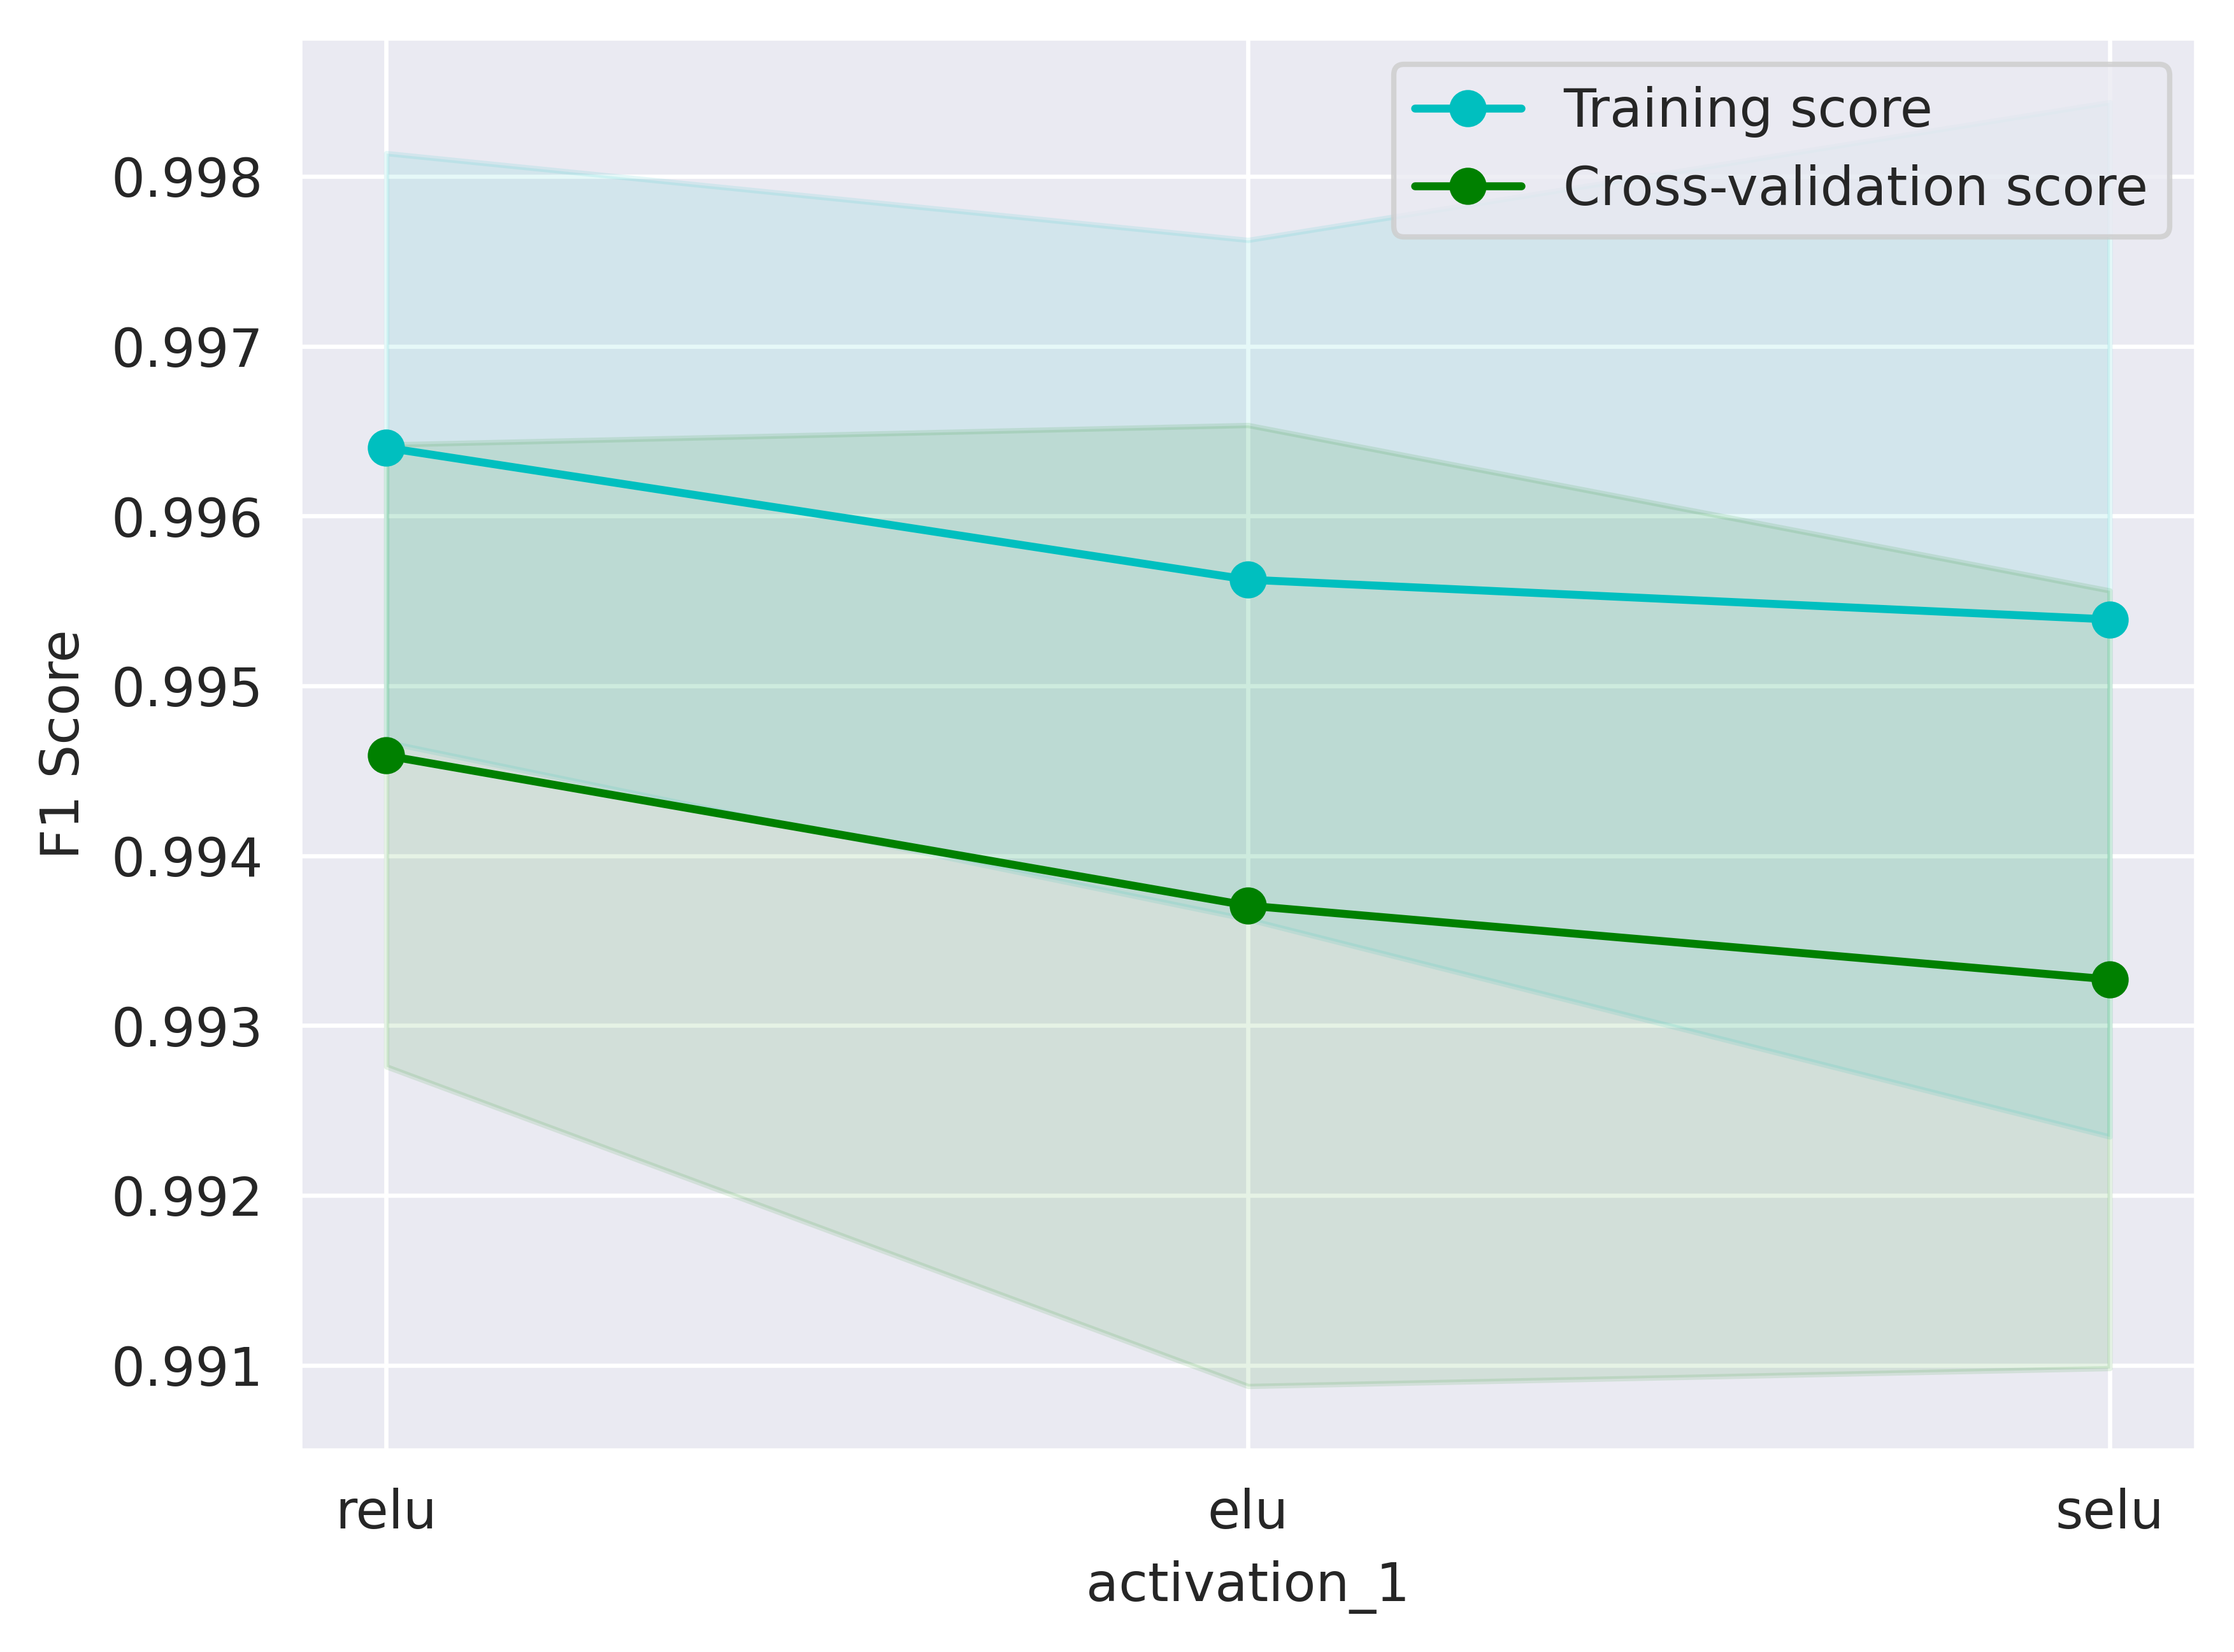

In [22]:
params = {
          "optimizer": 'adam',
          "num_classes": 5,
          # "learning_r": 0.01,
          "layer_1": 512,
          "layer_2": 256,
          "layer_3": 128,
          "drop_1": 0.0,
          "drop_2": 0.0,
          "drop_3": 0.0,
          "drop_4": 0.0,
          "drop_5": 0.0,
          "drop_6": 0.0,
          "activation_1": "relu",
          "activation_2": "relu",
          "activation_3": "relu",
          "activation_4": "relu",
          "activation_5": "relu",
          "activation_6": "relu",
          }

param_range = [
    {"activation_1": 'relu'},
    {"activation_1": 'elu'},
    {"activation_1": 'selu'},
]

ml_method = 'cnn_single_subsample'

param_learning_curve(X, y, params, param_range, ml_method, label="Activation_1", cv=sss_validation_curve)